In [105]:
import torch
import numpy as np
import torch.nn as nn 
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from enum import Enum
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
import pandas as pd
from skimage.util import random_noise
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(2024)

## Datasets

### MNIST

In [515]:
transform_EMNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.T),
    transforms.Lambda(lambda x : x.reshape(-1))
])

In [2]:
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

In [516]:
emnist_train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=False, transform=transform_EMNIST)
emnist_test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=False, transform=transform_EMNIST)

In [4]:
fashionmnist_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_MNIST)
fashionmnist_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_MNIST)

### CIFAR

In [5]:
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar100_train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar)
cifar100_test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Dataloaders

In [517]:
emnist_train_loader = DataLoader(emnist_train_dataset, batch_size=1, shuffle=True)
emnist_test_loader = DataLoader(emnist_test_dataset, batch_size=1, shuffle=True)
fashionmnist_train_loader = DataLoader(fashionmnist_train_dataset, batch_size=1, shuffle=True)
fashionmnist_test_loader = DataLoader(fashionmnist_test_dataset, batch_size=1, shuffle=True)
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=True)
cifar100_train_loader = DataLoader(cifar100_train_dataset, batch_size=1, shuffle=True)
cifar100_test_loader = DataLoader(cifar100_test_dataset, batch_size=1, shuffle=True)

## Data Augmentation

imgcorruptlike sub-library require image data at least 32x32 pixels

In [559]:
def gaussian(img, mean, var):
    return torch.tensor(random_noise(img, mode='gaussian', mean=mean, var=var, rng=2024), dtype=torch.float32)

def speckle(img, mean, var):
    return torch.tensor(random_noise(img, mode='speckle', mean=mean, var=var, rng=2024), dtype=torch.float32) 

def occlusion(image, level):
    image = denormalize_grayscale_image(image)
    occlusion = iaa.Cutout(nb_iterations=1, size=level, fill_mode='constant', cval=0, random_state=2024, position='center')
    noisy_input = occlusion(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def averageblur(image, level):
    image = denormalize_grayscale_image(image)
    averageblur = iaa.AverageBlur(k=(2,level), random_state=2024)
    noisy_input = averageblur(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

### The following noises cannot be applied to MNIST images


def snow(image, level):
    image = denormalize_grayscale_image(image)
    snow = iaa.imgcorruptlike.Snow(severity=level, random_state=2024)
    noisy_input = snow(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def glassblur(image, level):
    image = denormalize_grayscale_image(image)
    glassblur = iaa.imgcorruptlike.GlassBlur(severity=level, random_state=2024)
    noisy_input = glassblur(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def defocusblur(image, level):
    image = denormalize_grayscale_image(image)
    defocusblur = iaa.imgcorruptlike.DefocusBlur(severity=level, random_state=2024)
    noisy_input = defocusblur(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def spatter(image, level):
    image = denormalize_grayscale_image(image)
    spatter = iaa.imgcorruptlike.DefocusBlur(severity=level, random_state=2024)
    noisy_input = spatter(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

In [531]:
variance_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
severity = [1,2,3,4,5]
averageblur_levels = [5, 10, 15, 20, 25]

In [555]:
occlusion_levels = [0.17, 0.24, 0.31, 0.38, 0.45]

In [532]:
emnist_test_dataset_gaussian = [[(gaussian(img, 0, lev), label)for img, label in emnist_test_dataset] for lev in variance_levels]
emnist_test_dataset_speckle = [[(speckle(img, 0, lev), label)for img, label in emnist_test_dataset] for lev in variance_levels]
emnist_test_dataset_averageblur = [[(averageblur(img, lev), label)for img, label in emnist_test_dataset] for lev in averageblur_levels]

In [560]:
emnist_test_dataset_occlusion = [[(occlusion(img, lev), label)for img, label in emnist_test_dataset] for lev in occlusion_levels]

In [561]:
emnist_test_dataloader_gaussian = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_gaussian]
emnist_test_dataloader_speckle = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_speckle]
emnist_test_dataloader_averageblur = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_averageblur]
emnist_test_dataloader_occlusion = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_occlusion]

In [562]:
fashionmnist_test_dataset_gaussian = [[(gaussian(img, 0, lev), label)for img, label in fashionmnist_test_dataset] for lev in variance_levels]
fashionmnist_test_dataset_speckle = [[(speckle(img, 0, lev), label)for img, label in fashionmnist_test_dataset] for lev in variance_levels]
fashionmnist_test_dataset_averageblur = [[(averageblur(img, lev), label)for img, label in fashionmnist_test_dataset] for lev in averageblur_levels]
fashionmnist_test_dataset_occlusion = [[(occlusion(img, lev), label)for img, label in fashionmnist_test_dataset] for lev in occlusion_levels]

In [563]:
fashionmnist_test_dataloader_gaussian = [DataLoader(dt, batch_size=1, shuffle=True) for dt in fashionmnist_test_dataset_gaussian]
fashionmnist_test_dataloader_speckle = [DataLoader(dt, batch_size=1, shuffle=True) for dt in fashionmnist_test_dataset_speckle]
fashionmnist_test_dataloader_averageblur = [DataLoader(dt, batch_size=1, shuffle=True) for dt in fashionmnist_test_dataset_averageblur]
fashionmnist_test_dataloader_occlusion = [DataLoader(dt, batch_size=1, shuffle=True) for dt in fashionmnist_test_dataset_occlusion]

## Models

In [8]:
def denormalize_grayscale_image(img):
    img = (img * 255).to(torch.uint8)
    img = img.view(28, 28).numpy()
    return img

def denormalize_rgb_image(img):
    img = img.permute(0, 2, 3, 1)
    di = ((img * 0.5 + 0.5) * 255).to(torch.uint8)
    return di.squeeze().numpy()

In [86]:
def normalize_grayscale_image(img):
    return torch.from_numpy(img).view(-1).unsqueeze(0).to(torch.float32) / 255.0

In [1087]:
def oneHotEncode(labels, num_classes):
    one_hot_encoded = torch.zeros(len(labels), num_classes)
    one_hot_encoded.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot_encoded.squeeze()

def smoothEncode(labels, num_classes, default=0.8):
    smooth_encoded = torch.full((len(labels), num_classes), (1-default)/(num_classes-1))
    smooth_encoded.squeeze()[labels.item()] = default
    return smooth_encoded

def print_weight(model):
    for l in model.layers.values():
        print(l.feedforward.weight)

In [664]:
class Learning(Enum):
    Hebbian = 1
    Exp_Hebbian = 2
    Sanger = 3
    FullyOrthogonal = 4
    Contrastive = 5

class DatasetName(Enum):
    EMNIST = 1
    FashionMNIST = 2
    CIFAR10 = 3
    CIFAR100 = 4

class ImageType(Enum):
    Gray = 1
    RGB = 2

In [1065]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleDict()
        self.iteration = 3
    
    def add_layer(self, name, layer):
        self.layers[name] = layer

    def visualize_weights(self):
        for layer_name, module in self.layers.items():
            module.visualize_weights()

    def forward(self, x, clamped, learning):
        for layer in self.layers.values():
            x = layer(x, clamped, learning)
        return x
    
    def Hebbian_test(self, x):
        for layer in self.layers.values():
            x = layer.forward_test(x)
        return x
    
    def set_iteration(self, i):
        self.iteration = i
    
    def forward_clamped(self, x, clamped):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for iter in range(self.iteration):
            hlist[-1] = clamped
            x = input
            for idx in range(nb_layers-1):
                w_topdown = layers[idx+1].feedforward.weight.detach().clone()
                h_topdown = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w_topdown, h_topdown)
                hlist[idx] = x
        return hlist

    def forward_free(self, x):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for _ in range(self.iteration):
            x = input
            for idx in range(nb_layers-1):
                w = layers[idx+1].feedforward.weight.detach().clone()
                h_l = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w, h_l)
                hlist[idx] = x
            x_L = layers[-1].forward_test(hlist[-2])
            hlist[-1] = x_L
        return x_L
    
    def hebclass_forward(self, x):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for _ in range(self.iteration):
            x = input
            for idx in range(nb_layers-1):
                w = layers[idx+1].feedforward.weight.detach().clone()
                h_l = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w, h_l)
                hlist[idx] = x
            x_L = layers[-1].forward_test(hlist[-2])
            hlist[-1] = x_L
        return hlist

    def hebheb_forward(self, x):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for _ in range(self.iteration):
            x = input
            for idx in range(nb_layers-1):
                w = layers[idx+1].feedforward.weight.detach().clone()
                h_l = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w, h_l)
                hlist[idx] = x
            x_L = layers[-1].contrastive_forward(hlist[-2])
            hlist[-1] = x_L
        return hlist
    
    def update_weights_Contrastive(self, input, zero_clamped_hlist, label_clamped_hlist):
        #print(zero_clamped_hlist)
        #print(label_clamped_hlist)
        layers = list(self.layers.values())
        nb_layers = len(layers)
        for idx in range(nb_layers):
            if idx == 0:
                layers[idx].update_weights_FullyOrthogonal(input.squeeze(0), label_clamped_hlist[idx].squeeze(0))
                layers[idx].weight_decay()
            elif idx == (nb_layers-1):
                layers[idx].update_weights_FullyOrthogonal(label_clamped_hlist[idx-1].squeeze(0), label_clamped_hlist[idx].squeeze(0))
            else : 
                layers[idx].update_weights_FullyOrthogonal(label_clamped_hlist[idx-1].squeeze(0)-zero_clamped_hlist[idx-1].squeeze(0), label_clamped_hlist[idx].squeeze(0)-zero_clamped_hlist[idx].squeeze(0))
                layers[idx].weight_decay()
            # if idx == 0:
            #     outer_label = torch.outer(label_clamped_hlist[idx].squeeze(0), input.squeeze(0))
            #     outer_zero = torch.outer(zero_clamped_hlist[idx].squeeze(0), input.squeeze(0))
            #     delta_weight = layers[idx].lr*(outer_label - outer_zero)

            #     # delta_bias = label_clamped_hlist[idx].squeeze(0) - zero_clamped_hlist[idx].squeeze(0)

            #     # print(outer_label - outer_zero)
            #     # if torch.isnan(delta_weight).all():
            #     #     print("NaN delta W on layer 0")
            #     #     print("Clamped Input Signal :")
            #     #     print(input.squeeze(0))
            #     #     print("Zero Clamped hs:")
            #     #     print(zero_clamped_hlist)
            #     #     print("Label Clamped hs:")
            #     #     print(label_clamped_hlist)
            #     #     print("Weights:")
            #     #     print(layers[idx].feedforward.weight)

            # elif idx == (nb_layers-1):
            #     layers[idx].update_weights_FullyOrthogonal(label_clamped_hlist[idx-1].squeeze(0), label_clamped_hlist[idx].squeeze(0))
            #     # outer_label = torch.outer(label_clamped_hlist[idx].squeeze(0), label_clamped_hlist[idx-1].squeeze(0))
            #     # delta_weight = layers[idx].lr*(outer_label)

            #     # delta_bias = label_clamped_hlist[idx].squeeze(0)
            #     # print(outer_label - outer_zero)
               
            # else:
            #     outer_label = torch.outer(label_clamped_hlist[idx].squeeze(0), label_clamped_hlist[idx-1].squeeze(0))
            #     outer_zero = torch.outer(zero_clamped_hlist[idx].squeeze(0), zero_clamped_hlist[idx-1].squeeze(0))
            #     delta_weight = layers[idx].lr*(outer_label - outer_zero)

            #     # delta_bias = label_clamped_hlist[idx].squeeze(0) - zero_clamped_hlist[idx].squeeze(0)
            #     # print(outer_label - outer_zero)

            # initial_weights = layers[idx].feedforward.weight.detach().clone()
            # layers[idx].feedforward.weight=nn.Parameter(torch.add(initial_weights, delta_weight), requires_grad=False)
            # # initial_biases = layers[idx].feedforward.bias.detach().clone()
            # # layers[idx].feedforward.bias=nn.Parameter(torch.add(initial_biases, delta_bias), requires_grad=False)
            # return delta_weight
    
    def update_weights(self, input, all_hlist, learning, output):
        allh = [input] + all_hlist
        allh[-1] = allh[-1].unsqueeze(0)
        layers = list(self.layers.values())
        layer_names = list(self.layers.keys())
        nb_layers = len(layers)
        if learning == Learning.Hebbian:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_Hebb(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()
        elif learning == Learning.Exp_Hebbian:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_Hebb_exp(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()
        elif learning == Learning.Sanger:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_Sanger(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()
        elif learning == Learning.FullyOrthogonal:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_FullyOrthogonal(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()


    def contrastive(self, x, labels):
        input = x.detach().clone()
        all_hlist_label = self.forward_clamped(x, labels)
        all_hlist_zero = self.forward_clamped(x, None)
        self.update_weights_Contrastive(input, all_hlist_zero, all_hlist_label)
    
    def contrastive_hebclass(self, x, labels, learning):
        input = x.detach().clone()
        all_hlist = self.hebclass_forward(x)
        self.update_weights(input, all_hlist, learning, labels)

    def contrastive_hebheb(self, x, labels, learning):
        input = x.detach().clone()
        all_hlist = self.hebheb_forward(x)
        self.update_weights(input, all_hlist, learning, labels)
        

In [1064]:
class Hebbian_Layer(nn.Module):
    def __init__(self, inputdim, outputdim, lr, lamb, w_decrease, gamma, eps, is_output_layer=False):
        super(Hebbian_Layer, self).__init__()
        self.input_dim = inputdim
        self.output_dim = outputdim
        self.lr = lr
        self.lamb = lamb
        self.decrease = w_decrease
        self.gamma = gamma
        self.epsilon = eps
        self.is_output_layer = is_output_layer

        self.feedforward = nn.Linear(self.input_dim, self.output_dim, bias=False)

        for param in self.feedforward.parameters():
            param=torch.nn.init.uniform_(param, a=0.0, b=1.0)
            param.requires_grad_(False)
        

        # self.itensors=self.createITensors()
        self.exponential_average=torch.zeros(self.output_dim)

    # def createITensors(self):
    #     itensors=torch.zeros(self.output_dim, self.output_dim, self.output_dim, dtype=torch.float)
    #     for i in range(0, self.output_dim):
    #         identity = torch.eye(i+1)
    #         padded_identity = torch.nn.functional.pad(identity, (0, self.output_dim - i-1, 0, 
    #                                                              self.output_dim - i-1))
    #         itensors[i]=padded_identity
    #     return itensors

    def inhibition(self, x):
        x=nn.ReLU()(x)
        max_ele=torch.max(x).item()
        x=torch.pow(x, self.lamb)
        x/=abs(max_ele)**self.lamb
        return x

    # Classic Hebbian
    def update_weights_Hebb(self, input, output):
        x=input.detach().clone().squeeze()
        y=output.detach().clone().squeeze()
        outer_prod=torch.outer(y, x)
        delta_weight = self.lr*(outer_prod)
        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)
    
    # Exponential Hebbian 
    def update_weights_Hebb_exp(self, input, output):
        x=input.detach().clone().squeeze()
        y=output.detach().clone().squeeze()
        outer_prod=torch.outer(y, x)
        initial_weights = self.feedforward.weight.detach().clone()
        delta_weight = self.lr*(outer_prod - initial_weights)
        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)

    # # Sanger's rule
    # def update_weights_Sanger(self, input, output):
    #     x=input.detach().clone().squeeze()
    #     y=output.detach().clone().squeeze()
    #     outer_prod=torch.outer(y, x)
    #     initial_weight=torch.transpose(self.feedforward.weight.detach().clone(), 0,1)
    #     A=torch.einsum('jk, lkm, m -> lj', initial_weight, self.itensors, y)
    #     A=A*(y.unsqueeze(1))
    #     delta_weight=self.lr*(outer_prod-A)
    #     self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
    #     self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)


    '''
    Sanger's rule
    -------------

    input : [batch_size, features]
    output : [batch_size, dim]

    projections : [batch_size, features]
    output[:, :i+1] : [batch_size] 
    input - projections : [batch_size, features]

    element-wise multiplication of y_i over (input - projections) 
    '''
    def update_weights_Sanger(self, input, output):

        y=output.detach().clone().squeeze()
    
        weights = self.feedforward.weight.detach()
        output_dim = weights.shape[0]

        delta_weights = torch.zeros_like(weights)

        for i in range(output_dim):
            projections = torch.matmul(output[:, :i+1], weights[:i+1])
            delta_w = self.lr * torch.mean((output[:, i].unsqueeze(1) * (input - projections)), dim=0)
            delta_weights[i] = delta_w

        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weights), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)
        

    # Fully orthogonal Sanger variant
    def update_weights_FullyOrthogonal(self, input, output):
        x=input.detach().clone().squeeze()
        y=output.detach().clone().squeeze()
        initial_weight = self.feedforward.weight.detach().clone()
        outer_prod = torch.outer(y, x)
        ytw = torch.matmul(y.unsqueeze(0), initial_weight)
        norm_term = torch.outer(y.squeeze(0), ytw.squeeze(0))
        delta_weight = self.lr*(outer_prod - norm_term)
        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)
        # self.updateBias(output)
        

    def weight_decay(self):
        average=torch.mean(self.exponential_average).item()
        A=self.exponential_average/average
        growth_factor_positive=self.epsilon*nn.Tanh()(-self.epsilon*(A-1))+1
        growth_factor_negative=torch.reciprocal(growth_factor_positive)
        positive_weights=torch.where(self.feedforward.weight>0, self.feedforward.weight, 0.0)
        negative_weights=torch.where(self.feedforward.weight<0, self.feedforward.weight, 0.0)
        positive_weights=positive_weights*growth_factor_positive.unsqueeze(1)
        negative_weights=negative_weights*growth_factor_negative.unsqueeze(1)
        self.feedforward.weight=nn.Parameter(torch.add(positive_weights, negative_weights), requires_grad=False)

    def visualize_weights(self):
        nb = int(math.ceil(math.sqrt(self.output_dim)))
        if not self.is_output_layer:
            fig, axes = plt.subplots(nb, nb, figsize=(32,32))
            nb_ele = self.output_dim
        else :
            nb_ele = self.feedforward.weight.size(0)
            fig, axes = plt.subplots(nb, nb, figsize=(32,32))
            
        weight = self.feedforward.weight
        for ele in range(nb_ele):
            random_feature_selector = weight[ele]
            heatmap = random_feature_selector.view(int(math.sqrt(weight.size(1))),
                                                    int(math.sqrt(weight.size(1))))
            ax = axes[ele // nb, ele % nb]
            im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
            fig.colorbar(im, ax=ax)
            ax.set_title(f'Weight {ele}')

        plt.tight_layout()
        plt.show()
            

    def forward(self, x, clamped=None, learning=1):
        input = x.detach().clone()
        x = self.feedforward(x)
        x = self.inhibition(x)
        if self.is_output_layer:
            self.update_weights_FullyOrthogonal(input, clamped)
        else:
            if learning == Learning.Hebbian:
                self.update_weights_Hebb(input, x)
            elif learning == Learning.Exp_Hebbian:
                self.update_weights_Hebb_exp(input, x)
            elif learning == Learning.Sanger:
                self.update_weights_Sanger(input, x)
            elif learning == Learning.FullyOrthogonal:
                self.update_weights_FullyOrthogonal(input, x)
        #if not self.is_output_layer: 
        self.weight_decay()
        return x
            
    def forward_test(self, x):
        x = self.feedforward(x)
        x = self.inhibition(x)
        return x
    
    def contrastive_forward(self, x, w, h_l):
        if h_l == None:
            h = self.feedforward(x)
        else :
            w = self.decrease*w
            h = self.feedforward(x) + torch.matmul(h_l, w)
        return self.inhibition(h)

In [856]:
class Classifier_Layer(nn.Module):
    def __init__(self, inputdim, outputdim, lr):
        super(Classifier_Layer, self).__init__()
        self.input_dim = inputdim
        self.output_dim = outputdim
        self.lr = lr

        self.feedforward = nn.Linear(self.input_dim, self.output_dim, bias=False)

        for param in self.feedforward.parameters():
            param=torch.nn.init.uniform_(param, a=0.0, b=1.0)
            param.requires_grad_(False)

    
    def update_weights(self, input, output, clamped):
        u=output.detach().clone().squeeze()
        x=input.detach().clone().squeeze()
        y=torch.softmax(u, dim=0)
        A=None
        if clamped != None:
            outer_prod=torch.outer(clamped-y,x)
            u_times_y=torch.mul(u,y)
            A=outer_prod-self.feedforward.weight*(u_times_y.unsqueeze(1))
        else:
            A=torch.outer(y,x)
        A=self.feedforward.weight+self.lr*A
        weight_maxes=torch.max(A, dim=1).values
        self.feedforward.weight=nn.Parameter(A/weight_maxes.unsqueeze(1), requires_grad=False)
        self.feedforward.weight[:, 0] = 0
    
    def forward(self, x, clamped, learning=None):
        input = x.detach().clone()
        x=self.feedforward(x)
        self.update_weights(input, x, clamped)
        x=nn.Softmax(dim=-1)(x)
        return x
    
    def forward_test(self, x):
        x = self.feedforward(x)
        x=nn.Softmax(dim=-1)(x)
        return x

    def contrastive_forward(self, x, wT, xhat, clamped):
        input = x.detach().clone()
        if wT == None and xhat == None:
            h = self.feedforward(x)
        else : 
            h = self.feedforward(x) + torch.matmul(xhat,wT)
        self.update_weights(input, h, clamped)
        h = nn.Softmax()(h)
        return h

    def visualize_weights(self):
        weight = self.feedforward.weight
        nb_ele = self.feedforward.weight.size(0)
        nb = math.ceil(math.sqrt(nb_ele))
        fig, axes = plt.subplots(nb, nb, figsize=(32,32))
        for ele in range(nb_ele):
            random_feature_selector = weight[ele]
            heatmap = random_feature_selector.view(int(math.sqrt(self.feedforward.weight.size(1))),
                                                    int(math.sqrt(self.feedforward.weight.size(1))))
            ax = axes[ele // nb, ele % nb]
            im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
            fig.colorbar(im, ax=ax)
            ax.set_title(f'Weight {ele}')
        plt.tight_layout()
        plt.show()

## MLP-Baseline

In [1007]:
def MLPBaseline_Experiment(epoch, hsize, lamb, lr, learning, e, dataloader, nclasses):

    mymodel = NeuralNet()
    heb_layer = Hebbian_Layer(784, hsize, lr, lamb, 0, 0.98, e)
    #heb_layer2 = Hebbian_Layer(hsize, nclasses, lr, lamb, 0, 0.98, e, is_output_layer=True)
    class_layer = Classifier_Layer(hsize, nclasses, lr)

    mymodel.add_layer("Hebbian1", heb_layer)
    #mymodel.add_layer("Hebbian2", heb_layer2)
    mymodel.add_layer("Class", class_layer)

    mymodel.train()

    for _ in range(epoch):
        for data in tqdm(dataloader):
            inputs, labels=data
            mymodel.forward(inputs, oneHotEncode(labels, nclasses), learning)
    
    return mymodel

def MLPBaseline_Experiment_hebheb(epoch, hsize, lamb, lr, learning, e, dataloader, nclasses):

    mymodel = NeuralNet()
    heb_layer = Hebbian_Layer(784, hsize, lr, lamb, 0, 0.98, e)
    heb_layer2 = Hebbian_Layer(hsize, nclasses, lr, lamb, 0, 0.98, e, is_output_layer=True)
    #class_layer = Classifier_Layer(hsize, nclasses, lr)

    mymodel.add_layer("Hebbian1", heb_layer)
    mymodel.add_layer("Hebbian2", heb_layer2)
    #mymodel.add_layer("Class", class_layer)

    mymodel.train()

    for _ in range(epoch):
        for data in tqdm(dataloader):
            inputs, labels=data
            mymodel.forward(inputs, oneHotEncode(labels, nclasses), learning)
    
    return mymodel

In [15]:
def MLPBaseline_test_accuracy(mymodel, data_loader):
    yes = 0
    tot = 0
    da = {}
    for data in tqdm(data_loader):
        inputs, labels = data
        output = torch.argmax(mymodel.Hebbian_test(inputs))
        if labels.item() not in da:
            da[labels.item()] = (0, 0)
        r, t = da[labels.item()]
        if output.item() == labels.item():
            yes += 1
            da[labels.item()] = (r+1, t+1)
        else :
            da[labels.item()] = (r, t+1)
        tot += 1
    return (yes/tot), da

## MLP 3 Layer

In [730]:
def MLP3Layer_Experiment(epoch, hsize, lamb, lr, learning, e, dataloader, nclasses):

    mymodel = NeuralNet()
    heb_layer = Hebbian_Layer(784, hsize, lr, lamb, 0.99, 0.98, e)
    heb_layer2 = Hebbian_Layer(hsize, hsize, lr, lamb, 0.99, 0.98, e)
    class_layer = Classifier_Layer(hsize, nclasses, lr)

    mymodel.add_layer("Hebbian1", heb_layer)
    mymodel.add_layer("Hebbian2", heb_layer2)
    mymodel.add_layer("Class", class_layer)

    mymodel.train()

    for _ in range(epoch):
        for data in tqdm(dataloader):
            inputs, labels=data
            mymodel.forward(inputs, oneHotEncode(labels, nclasses), learning)
    
    return mymodel

## Top Down

In [1057]:
def TopDownBaseline_Experiment(epoch, hsize, lamb, lr, learning, e, wtdecrease, dataloader, nclasses):

    mymodel = NeuralNet()
    heb_layer = Hebbian_Layer(784, hsize, lr, lamb, wtdecrease, 0.98, e)
    class_layer = Classifier_Layer(hsize, nclasses, lr)

    mymodel.add_layer("Hebbian1", heb_layer)
    mymodel.add_layer("Classifier", class_layer)

    mymodel.train()

    for _ in range(epoch):
        for data in tqdm(dataloader):
            inputs, labels=data
            mymodel.contrastive_hebclass(inputs, smoothEncode(labels, nclasses), learning)
    
    return mymodel

def TopDown2Heb_Experiment(epoch, hsize, lamb, lr, learning, e, wtdecrease, dataloader, nclasses):

    mymodel = NeuralNet()
    heb_layer = Hebbian_Layer(784, hsize, lr, lamb, wtdecrease, 0.98, e)
    heb_layer2 = Hebbian_Layer(hsize, nclasses, lr, lamb, wtdecrease, 0.98, e)

    mymodel.add_layer("Hebbian1", heb_layer)
    mymodel.add_layer("Hebbian2", heb_layer2)

    mymodel.train()

    for _ in range(epoch):
        for data in tqdm(dataloader):
            inputs, labels=data
            mymodel.contrastive(inputs, smoothEncode(labels, nclasses))
    
    return mymodel

def TopDown3LayerBaseline_Experiment(epoch, hsize, lamb, lr, learning, e, dataloader, nclasses):

    mymodel = NeuralNet()
    heb_layer = Hebbian_Layer(784, hsize, lr, lamb, 0.99, 0.98, e)
    heb_layer2 = Hebbian_Layer(hsize, hsize, lr, lamb, 0.99, 0.98, e)
    class_layer = Classifier_Layer(hsize, nclasses, lr)

    mymodel.add_layer("Hebbian1", heb_layer)
    mymodel.add_layer("Hebbian2", heb_layer2)
    mymodel.add_layer("Classifier", class_layer)

    mymodel.train()

    for _ in range(epoch):
        for data in tqdm(dataloader):
            inputs, labels=data
            mymodel.contrastive_hebclass(inputs, oneHotEncode(labels, nclasses), learning)
    
    return mymodel

In [792]:
def TopDownBaseline_test_accuracy(mymodel, data_loader):
    yes = 0
    tot = 0
    da = {}
    for data in tqdm(data_loader):
        inputs, labels = data
        # print(inputs)
        # plt.imshow(denormalize_grayscale_image(inputs))
        # plt.show()
        output = mymodel.forward_free(inputs)
        # print(labels.item())
        output = torch.argmax(output)
        # print(output.item())
        if labels.item() not in da:
            da[labels.item()] = (0, 0)
        r, t = da[labels.item()]
        if output.item() == labels.item():
            yes += 1
            da[labels.item()] = (r+1, t+1)
        else :
            da[labels.item()] = (r, t+1)
        tot += 1
    return (yes/tot), da

# EMNIST - Experiments

## Noise Visualization

### Gaussian

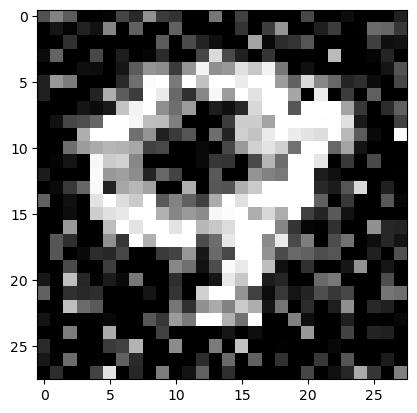

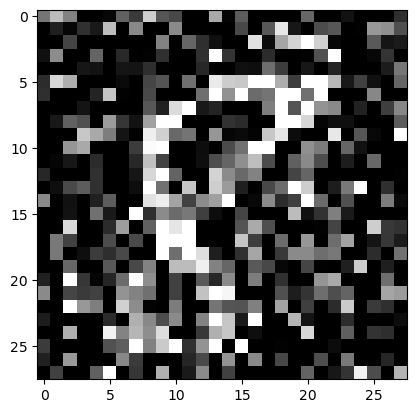

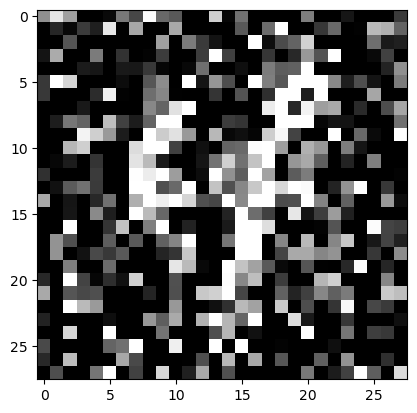

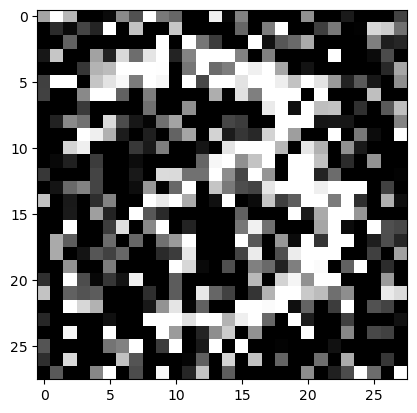

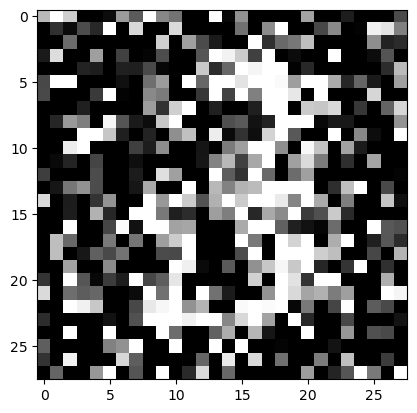

In [564]:
for idx in range(5):
    for data in emnist_test_dataloader_gaussian[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

### Speckle

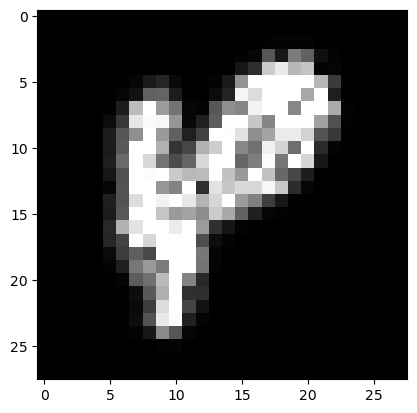

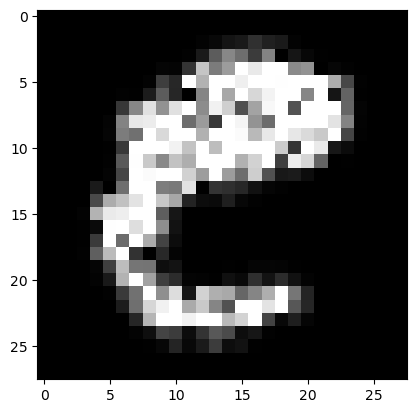

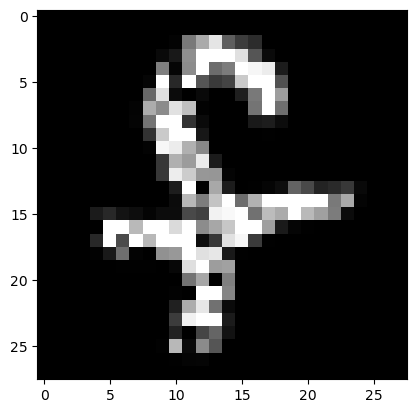

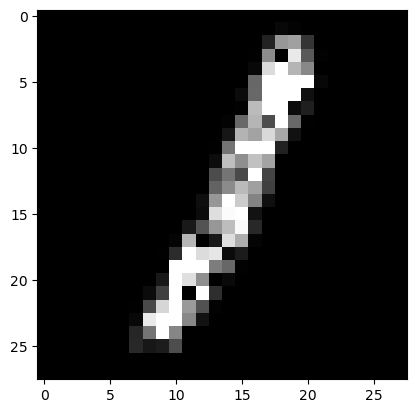

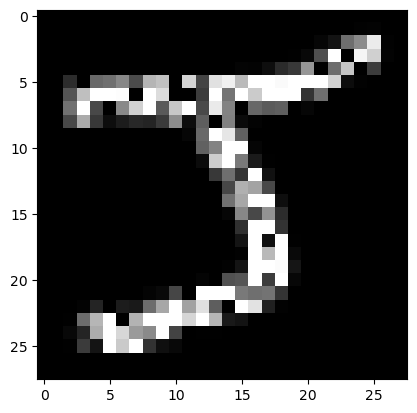

In [565]:
for idx in range(5):
    for data in emnist_test_dataloader_speckle[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

### Occlusion

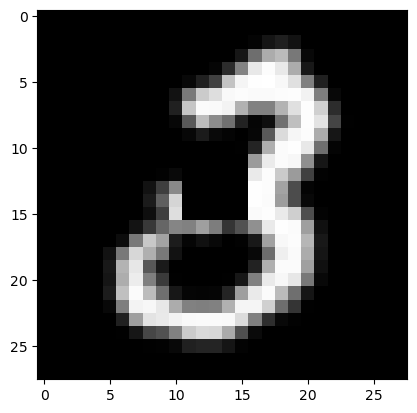

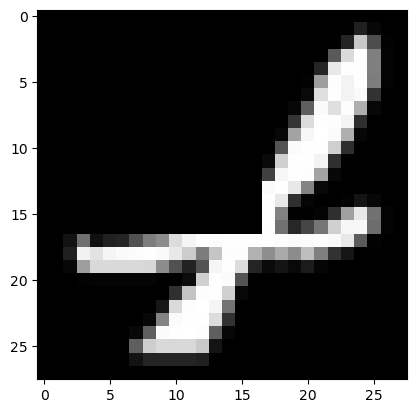

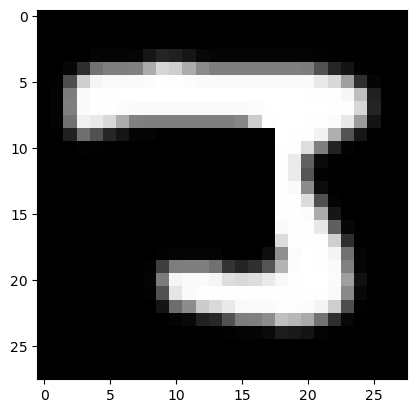

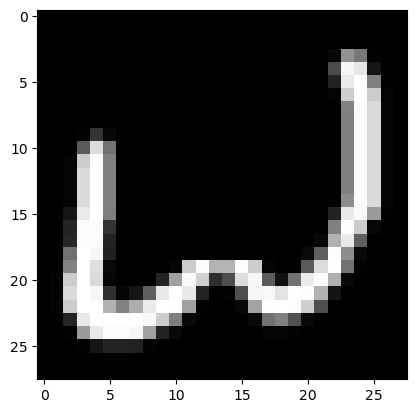

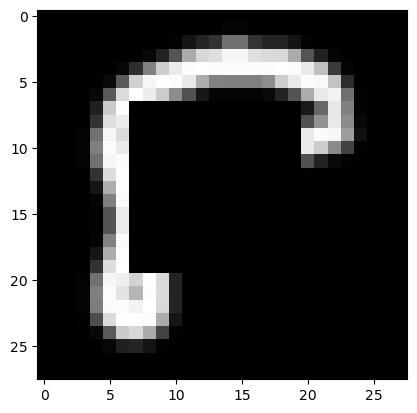

In [567]:
for idx in range(5):
    for data in emnist_test_dataloader_occlusion[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

### Average Blur

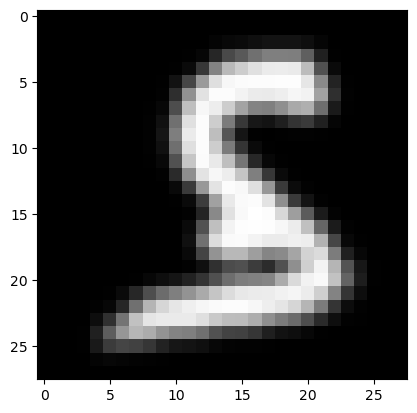

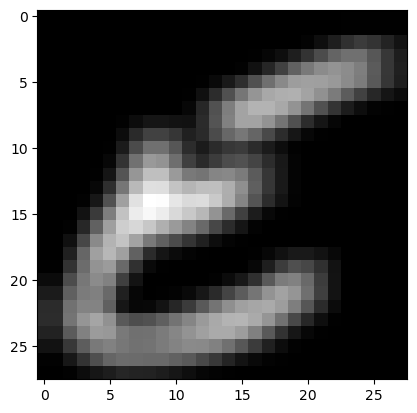

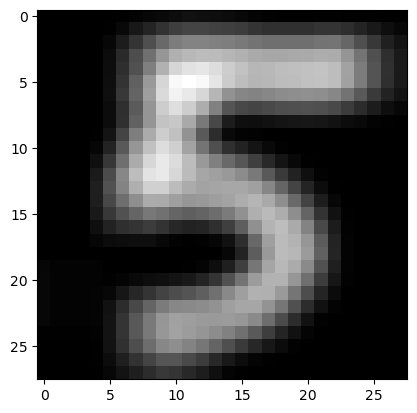

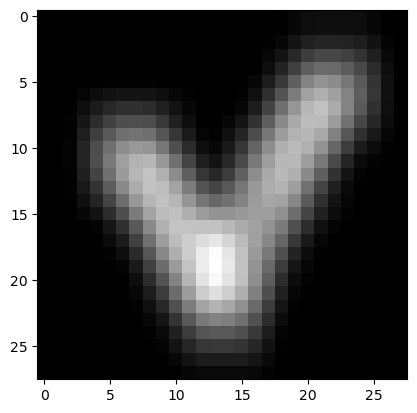

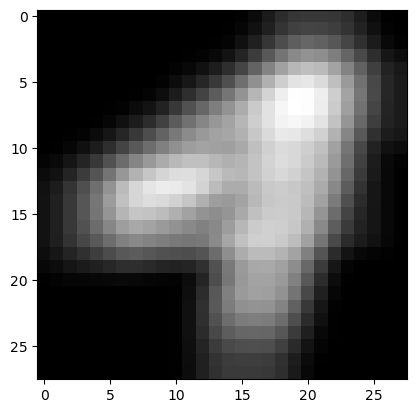

In [568]:
for idx in range(5):
    for data in emnist_test_dataloader_averageblur[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

## Fix

### helper

In [1099]:
def forward_free3(self, x):
    input = x.detach().clone()
    layers = list(self.layers.values())
    nb_layers = len(layers)
    hlist = [None]*nb_layers
    for _ in range(self.iteration):
        x = input
        for idx in range(nb_layers-1):
            w = layers[idx+1].feedforward.weight.detach().clone()
            h_l = hlist[idx+1]
            x = contrastive_forward3(layers[idx], x, w, h_l)
            hlist[idx] = x
        x_L = layers[-1].forward_test(hlist[-2])
        hlist[-1] = x_L
    return x_L

def contrastive_forward3(self, x, w, h_l):
    if h_l == None:
        h = self.feedforward(x)
    else :
        w = 0*w
        # print(self.feedforward(x))
        # print(h_l)
        # print(torch.matmul(h_l, w))
        h = self.feedforward(x) + torch.matmul(h_l, w)
    # print(h)
    h = self.inhibition(h)
    # print(h)
    return h

def TopDownBaseline_test_accuracy_fix(mymodel, data_loader):
    yes = 0
    tot = 0
    da = {}
    for data in tqdm(data_loader):
        inputs, labels = data
        # print(inputs)
        # plt.imshow(denormalize_grayscale_image(inputs))
        # plt.show()
        output = forward_free3(mymodel, inputs)
        # print(labels.item())
        output = torch.argmax(output)
        # print(output.item())
        if labels.item() not in da:
            da[labels.item()] = (0, 0)
        r, t = da[labels.item()]
        if output.item() == labels.item():
            yes += 1
            da[labels.item()] = (r+1, t+1)
        else :
            da[labels.item()] = (r, t+1)
        tot += 1
        #return 0
    return (yes/tot), da

def forward_free4(self, x):
    input = x.detach().clone()
    layers = list(self.layers.values())
    nb_layers = len(layers)
    hlist = [None]*nb_layers
    for _ in range(self.iteration):
        x = input
        for idx in range(nb_layers-1):
            w = layers[idx+1].feedforward.weight.detach().clone()
            h_l = hlist[idx+1]
            x = contrastive_forward4(layers[idx], x, w, h_l)
            hlist[idx] = x
        x_L = layers[-1].forward_test(hlist[-2])
        hlist[-1] = x_L
    return x_L

def contrastive_forward4(self, x, w, h_l):
    if h_l == None:
        h = self.feedforward(x)
    else :
        print("This is w before scaling")
        print(w)
        w = 1000*w
        print("This is x")
        print(x)
        print("This is current layer weight")
        print(self.feedforward.weight)
        print("This is next layer weight")
        print(w)
        print("This is h")
        print(h_l)
        print("This is feedforward result")
        print(self.feedforward(x))
        print("This is topdown result")
        print(torch.matmul(h_l, w))
        h = self.feedforward(x) + torch.matmul(h_l, w)
    print("This is pre inhibition")
    print(h)
    h = self.inhibition(h)
    print("This is after inhibition")
    print(h)
    return h

def TopDownBaseline_test_accuracy_view_wt(mymodel, data_loader):
    yes = 0
    tot = 0
    da = {}
    for data in tqdm(data_loader):
        inputs, labels = data
        # print(inputs)
        # plt.imshow(denormalize_grayscale_image(inputs))
        # plt.show()
        output = forward_free4(mymodel, inputs)
        # print(labels.item())
        output = torch.argmax(output)
        # print(output.item())
        if labels.item() not in da:
            da[labels.item()] = (0, 0)
        r, t = da[labels.item()]
        if output.item() == labels.item():
            yes += 1
            da[labels.item()] = (r+1, t+1)
        else :
            da[labels.item()] = (r, t+1)
        tot += 1
        return 0
    return (yes/tot), da

### Test

#### MLP 2 Heb

In [1004]:
emnist_mlp = MLPBaseline_Experiment_hebheb(epoch=3, hsize=64, lamb=15, lr=0.005, learning=Learning.FullyOrthogonal, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [1006]:
print(MLPBaseline_test_accuracy(emnist_mlp, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4071808510638298, {17: (155, 400), 3: (255, 400), 32: (323, 400), 34: (40, 400), 36: (180, 400), 44: (6, 400), 19: (35, 400), 23: (175, 400), 7: (235, 400), 35: (261, 400), 18: (209, 400), 28: (185, 400), 25: (218, 400), 31: (179, 400), 12: (70, 400), 26: (168, 400), 29: (210, 400), 16: (207, 400), 15: (93, 400), 14: (71, 400), 38: (161, 400), 8: (121, 400), 40: (167, 400), 6: (264, 400), 33: (273, 400), 20: (156, 400), 39: (250, 400), 2: (199, 400), 42: (141, 400), 21: (0, 400), 27: (22, 400), 46: (116, 400), 13: (7, 400), 30: (197, 400), 10: (179, 400), 1: (123, 400), 45: (231, 400), 43: (239, 400), 41: (0, 400), 4: (124, 400), 5: (118, 400), 9: (226, 400), 0: (261, 400), 37: (136, 400), 24: (209, 400), 22: (339, 400), 11: (121, 400)})


In [1008]:
emnist_mlp = MLPBaseline_Experiment(epoch=3, hsize=64, lamb=15, lr=0.005, learning=Learning.FullyOrthogonal, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [1009]:
print(MLPBaseline_test_accuracy(emnist_mlp, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3872340425531915, {27: (139, 400), 37: (146, 400), 26: (149, 400), 30: (199, 400), 21: (199, 400), 20: (94, 400), 46: (63, 400), 17: (147, 400), 35: (255, 400), 18: (10, 400), 36: (176, 400), 12: (97, 400), 7: (165, 400), 43: (149, 400), 28: (152, 400), 32: (305, 400), 45: (166, 400), 5: (100, 400), 39: (221, 400), 14: (235, 400), 19: (97, 400), 10: (209, 400), 13: (199, 400), 1: (60, 400), 44: (93, 400), 34: (160, 400), 3: (137, 400), 42: (159, 400), 6: (216, 400), 0: (36, 400), 38: (293, 400), 29: (233, 400), 31: (151, 400), 15: (78, 400), 40: (44, 400), 2: (190, 400), 16: (136, 400), 22: (332, 400), 23: (189, 400), 8: (162, 400), 4: (111, 400), 25: (214, 400), 24: (33, 400), 11: (175, 400), 33: (202, 400), 9: (101, 400), 41: (103, 400)})


#### TOP DOWN 2 Heb

In [1088]:
emnist_topdown = TopDown2Heb_Experiment(epoch=3, hsize=64, lamb=15, lr=0.005, learning=Learning.FullyOrthogonal, e=0.01, wtdecrease=10, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [1089]:
print(TopDownBaseline_test_accuracy(emnist_topdown, emnist_test_loader))
print(TopDownBaseline_test_accuracy_fix(emnist_topdown, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4542553191489362, {12: (159, 400), 40: (199, 400), 30: (220, 400), 17: (111, 400), 39: (215, 400), 28: (186, 400), 22: (339, 400), 42: (204, 400), 8: (200, 400), 38: (284, 400), 46: (179, 400), 29: (207, 400), 45: (255, 400), 15: (5, 400), 6: (293, 400), 33: (233, 400), 11: (175, 400), 31: (182, 400), 18: (222, 400), 43: (254, 400), 9: (28, 400), 20: (153, 400), 4: (94, 400), 24: (285, 400), 35: (270, 400), 41: (38, 400), 10: (195, 400), 14: (153, 400), 21: (0, 400), 1: (111, 400), 36: (164, 400), 23: (234, 400), 32: (335, 400), 16: (215, 400), 2: (227, 400), 3: (290, 400), 0: (2, 400), 13: (184, 400), 7: (310, 400), 5: (215, 400), 25: (191, 400), 27: (76, 400), 44: (21, 400), 34: (130, 400), 19: (132, 400), 26: (192, 400), 37: (173, 400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4575531914893617, {13: (184, 400), 38: (284, 400), 3: (286, 400), 18: (200, 400), 1: (129, 400), 7: (299, 400), 43: (252, 400), 20: (152, 400), 2: (226, 400), 6: (297, 400), 14: (157, 400), 35: (266, 400), 5: (216, 400), 25: (192, 400), 21: (2, 400), 31: (177, 400), 33: (228, 400), 8: (199, 400), 44: (32, 400), 22: (338, 400), 26: (189, 400), 34: (133, 400), 32: (335, 400), 17: (115, 400), 24: (254, 400), 41: (40, 400), 29: (204, 400), 19: (133, 400), 23: (232, 400), 10: (198, 400), 16: (212, 400), 0: (64, 400), 45: (251, 400), 39: (211, 400), 9: (67, 400), 12: (161, 400), 15: (10, 400), 40: (196, 400), 46: (177, 400), 27: (80, 400), 11: (176, 400), 4: (98, 400), 36: (168, 400), 30: (224, 400), 42: (206, 400), 37: (167, 400), 28: (185, 400)})


In [1096]:
print(TopDownBaseline_test_accuracy_fix(emnist_topdown, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

tensor([[-1.4395e+00,  7.5348e-01, -1.7459e+00,  4.9147e+02, -2.4892e+00,
         -2.3126e+00,  4.8157e+01, -3.1519e+00, -3.6832e+00, -4.0052e+00,
         -4.0390e+00, -7.0470e+00, -4.4688e+00, -5.5975e+00, -4.5042e+00,
         -5.6816e+00,  2.9365e+00, -8.2466e-01, -3.6353e+00, -1.8874e+00,
         -3.5168e+00, -6.5972e+00, -2.7957e+00,  1.0914e+00, -5.1790e+00,
          1.0162e+01, -3.7856e+00, -5.6631e+00, -6.0577e+00, -3.6521e+00,
         -2.0426e+00, -4.4816e+00,  1.0316e+00, -6.1969e+00,  2.3474e+01,
          3.1143e+00, -7.0390e-02,  1.9401e+01,  7.1284e+01,  9.4333e-02,
          1.3291e+01,  4.0038e+00,  3.2479e+01,  7.2537e+02, -4.4308e+00,
          3.0459e+01, -3.6026e+00, -5.8683e+00, -8.5839e-01, -3.4476e+00,
         -4.2595e+00, -2.2083e+00, -4.6516e+00,  1.1577e+01,  4.9727e+01,
         -5.9672e+00, -3.6157e+00,  4.7118e+00, -2.5396e+00, -5.7997e+00,
          7.0096e+00, -2.1976e+00,  1.8018e+01, -6.0849e+00]])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, 

In [1072]:
print_weight(emnist_topdown)

Parameter containing:
tensor([[-1.1859e-08, -5.0931e-10,  2.0919e-10,  ...,  2.8758e-09,
         -1.2926e-09, -4.6312e-09],
        [-4.6110e-09,  4.3439e-09, -1.1150e-10,  ..., -2.2877e-10,
          3.5216e-09, -4.0892e-09],
        [ 3.6766e-09, -6.8660e-09, -9.5630e-10,  ...,  5.3202e-09,
          1.2861e-09, -1.8610e-08],
        ...,
        [-2.8865e-09, -3.2963e-11, -1.2567e-09,  ..., -7.3065e-09,
          5.7211e-09, -9.8330e-09],
        [-2.5119e-08, -2.7249e-09,  5.8795e-09,  ..., -2.3443e-08,
         -4.3830e-09,  4.4550e-08],
        [-6.3267e-09, -1.4937e-10, -6.3812e-10,  ..., -8.3372e-09,
         -5.8899e-10, -4.7471e-09]])
Parameter containing:
tensor([[ 2.0555e-02, -3.7055e-03,  4.7943e-03,  ..., -5.9127e-04,
          1.1283e-02,  3.6713e-03],
        [ 3.7370e-03,  1.8385e-01, -5.0463e-03,  ..., -5.5376e-04,
          2.1473e-02, -4.9902e-03],
        [ 1.6345e-02, -1.7337e-04,  2.7044e-01,  ..., -1.4759e-03,
          1.6495e-01,  3.3133e-02],
        ...,
  

In [1100]:
TopDownBaseline_test_accuracy_view_wt(emnist_topdown, emnist_test_loader)

  0%|          | 0/18800 [00:00<?, ?it/s]

This is pre inhibition
tensor([[24.1256, 24.9008, 43.2930, 27.2971, 19.0107, 38.6576, 26.6312, 36.3452,
         13.4508, 40.5714, 16.9634, 26.5257, 28.5641, 32.6081, 33.1884, 22.5927,
         16.0175, 26.1148, 27.6409, 33.0325, 18.9053, 25.6273, 20.4658, 18.7889,
          9.4548, 36.3329, 38.6577, 20.4656, 11.9376, 34.8820, 30.9562, 18.9057,
         19.9486, 21.2959, 22.9077, 15.4821, 33.6507, 29.7558, 35.4460, 26.8892,
         30.7784, 29.4654, 26.6973, 17.7683, 28.1444, 50.2862, 42.4091, 30.4072,
         36.6733,  7.7700, 27.3584, 37.4355, 19.2394, 25.9019, 21.9961,  9.1417,
         29.1772, 18.5270, 19.6478, 16.8231, 16.7265, 20.8945, 43.8221, 35.0372]])
This is after inhibition
tensor([[1.6423e-05, 2.6392e-05, 1.0581e-01, 1.0472e-04, 4.6053e-07, 1.9355e-02,
         7.2299e-05, 7.6733e-03, 2.5674e-09, 3.9955e-02, 8.3363e-08, 6.8119e-05,
         2.0681e-04, 1.5072e-03, 1.9637e-03, 6.1346e-06, 3.5254e-08, 5.3898e-05,
         1.2634e-04, 1.8298e-03, 4.2367e-07, 4.0628e-05, 1.

0

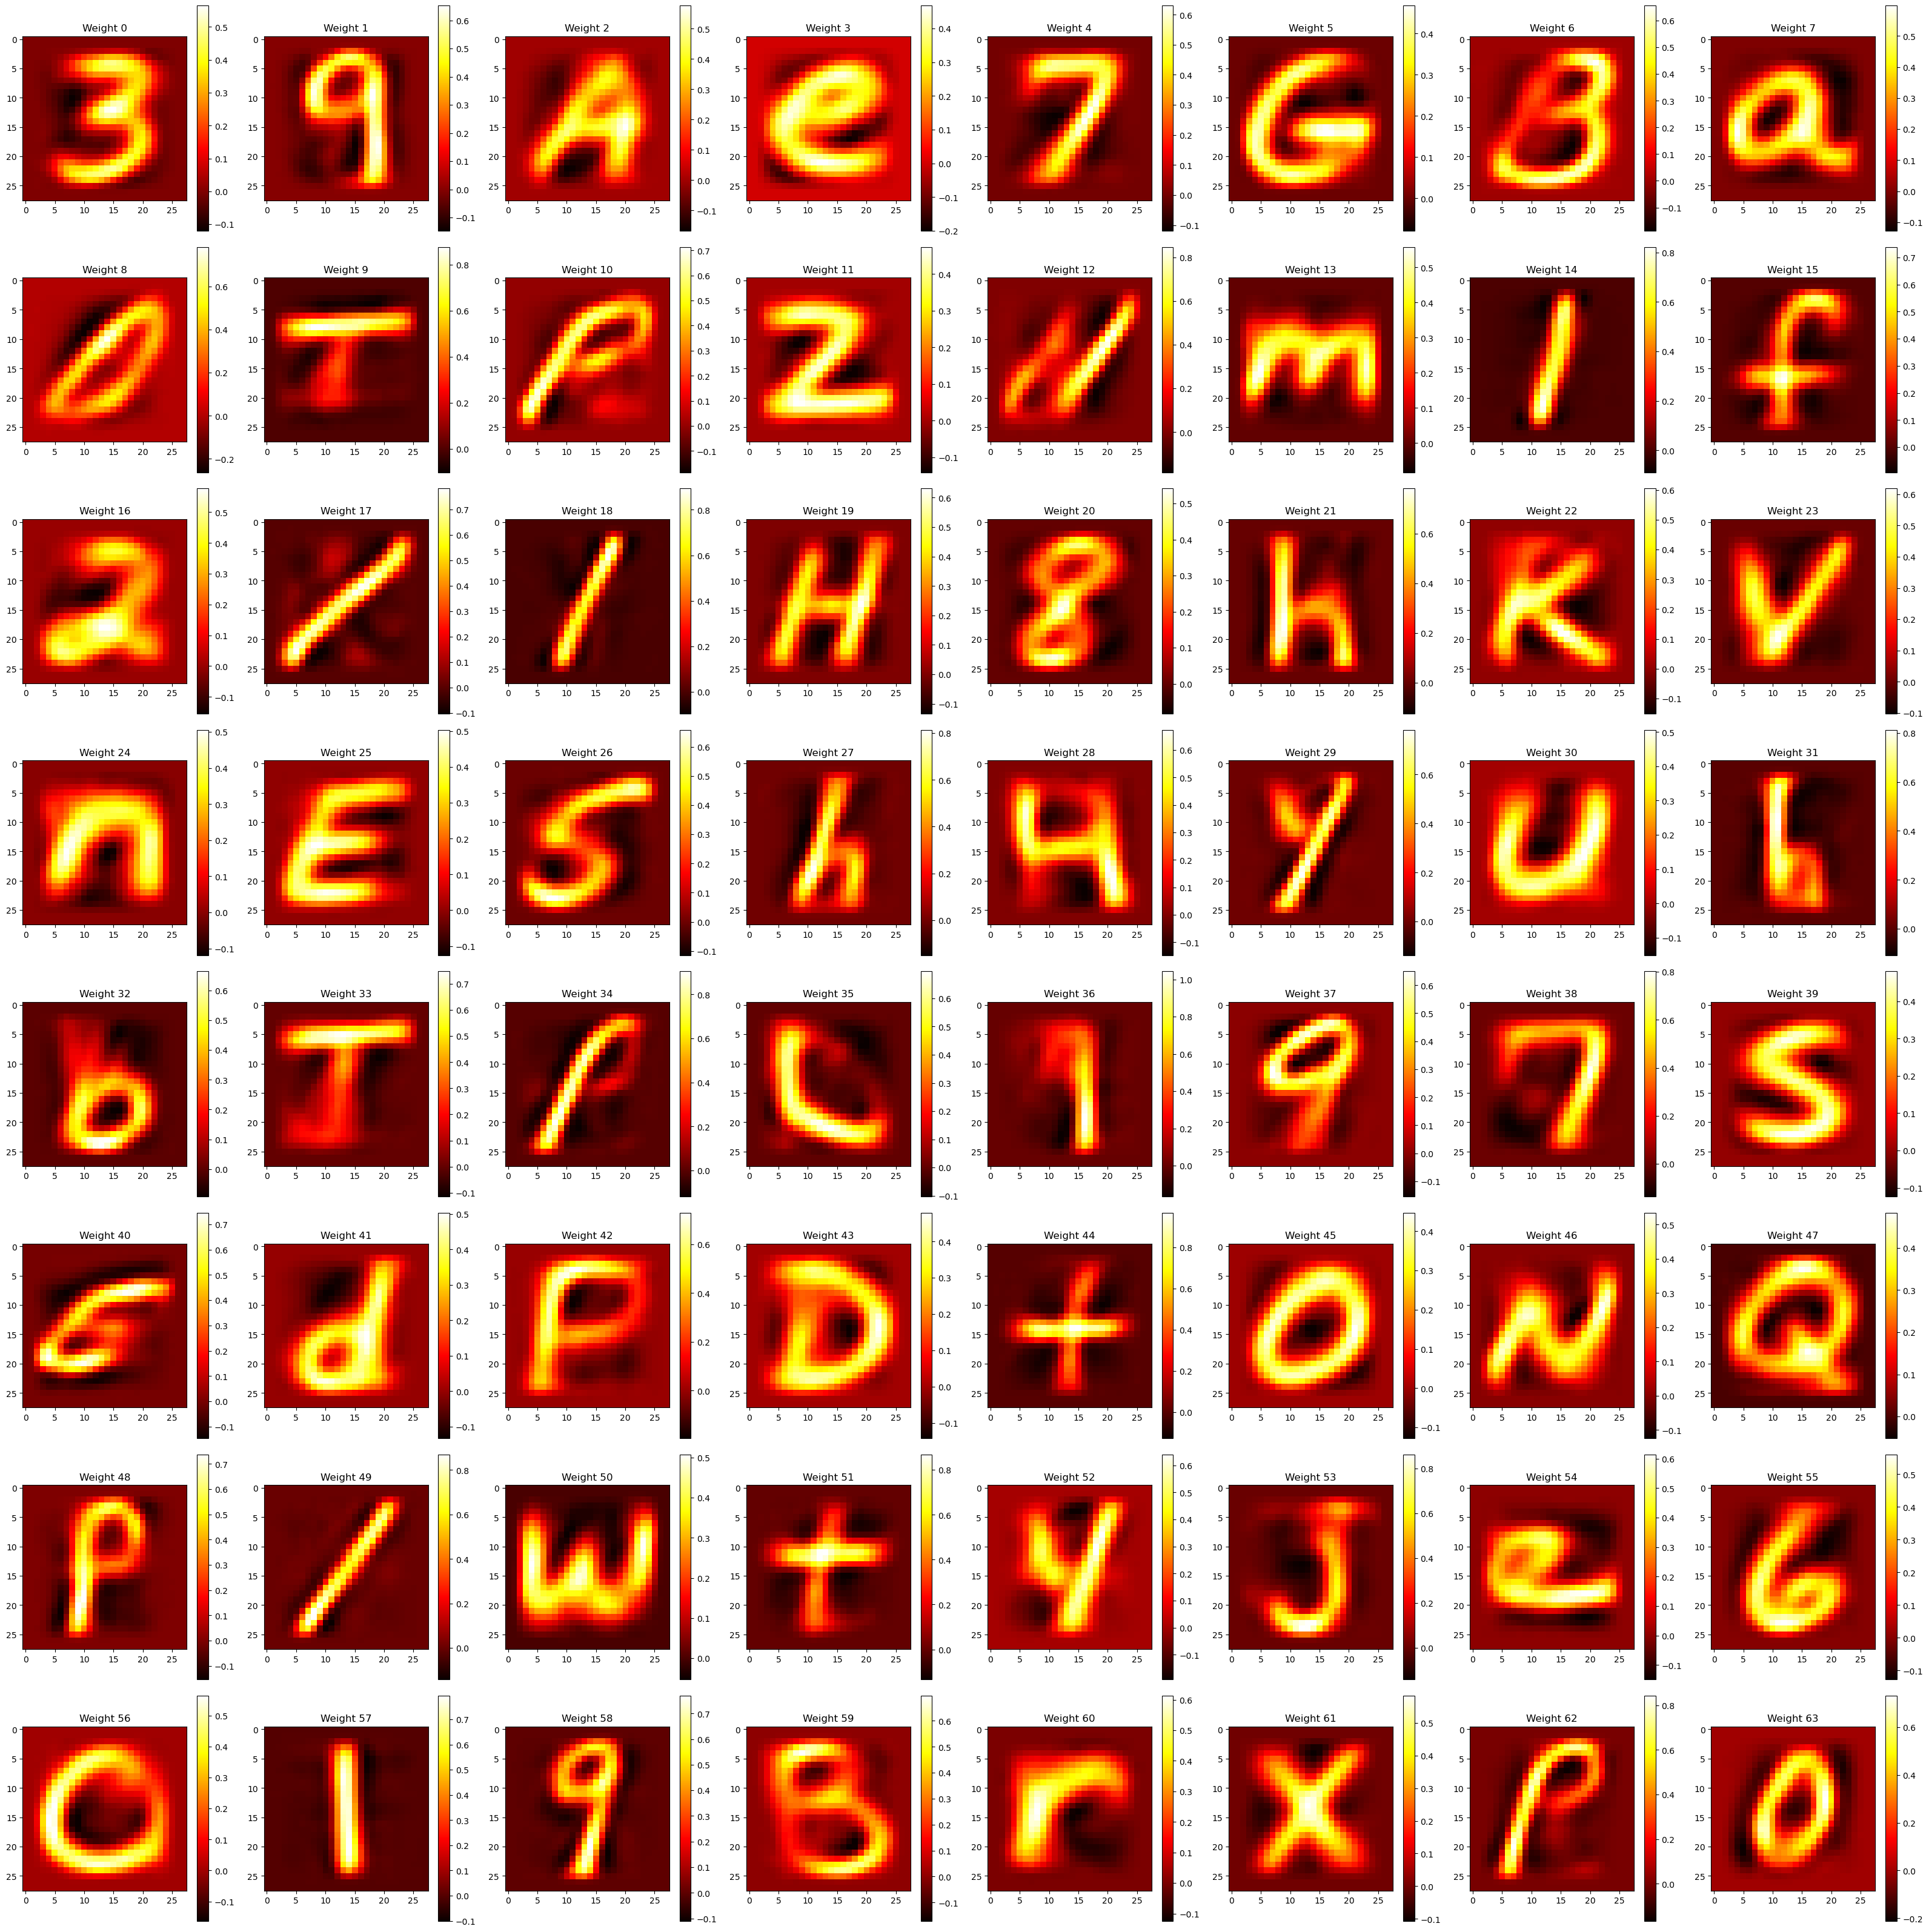

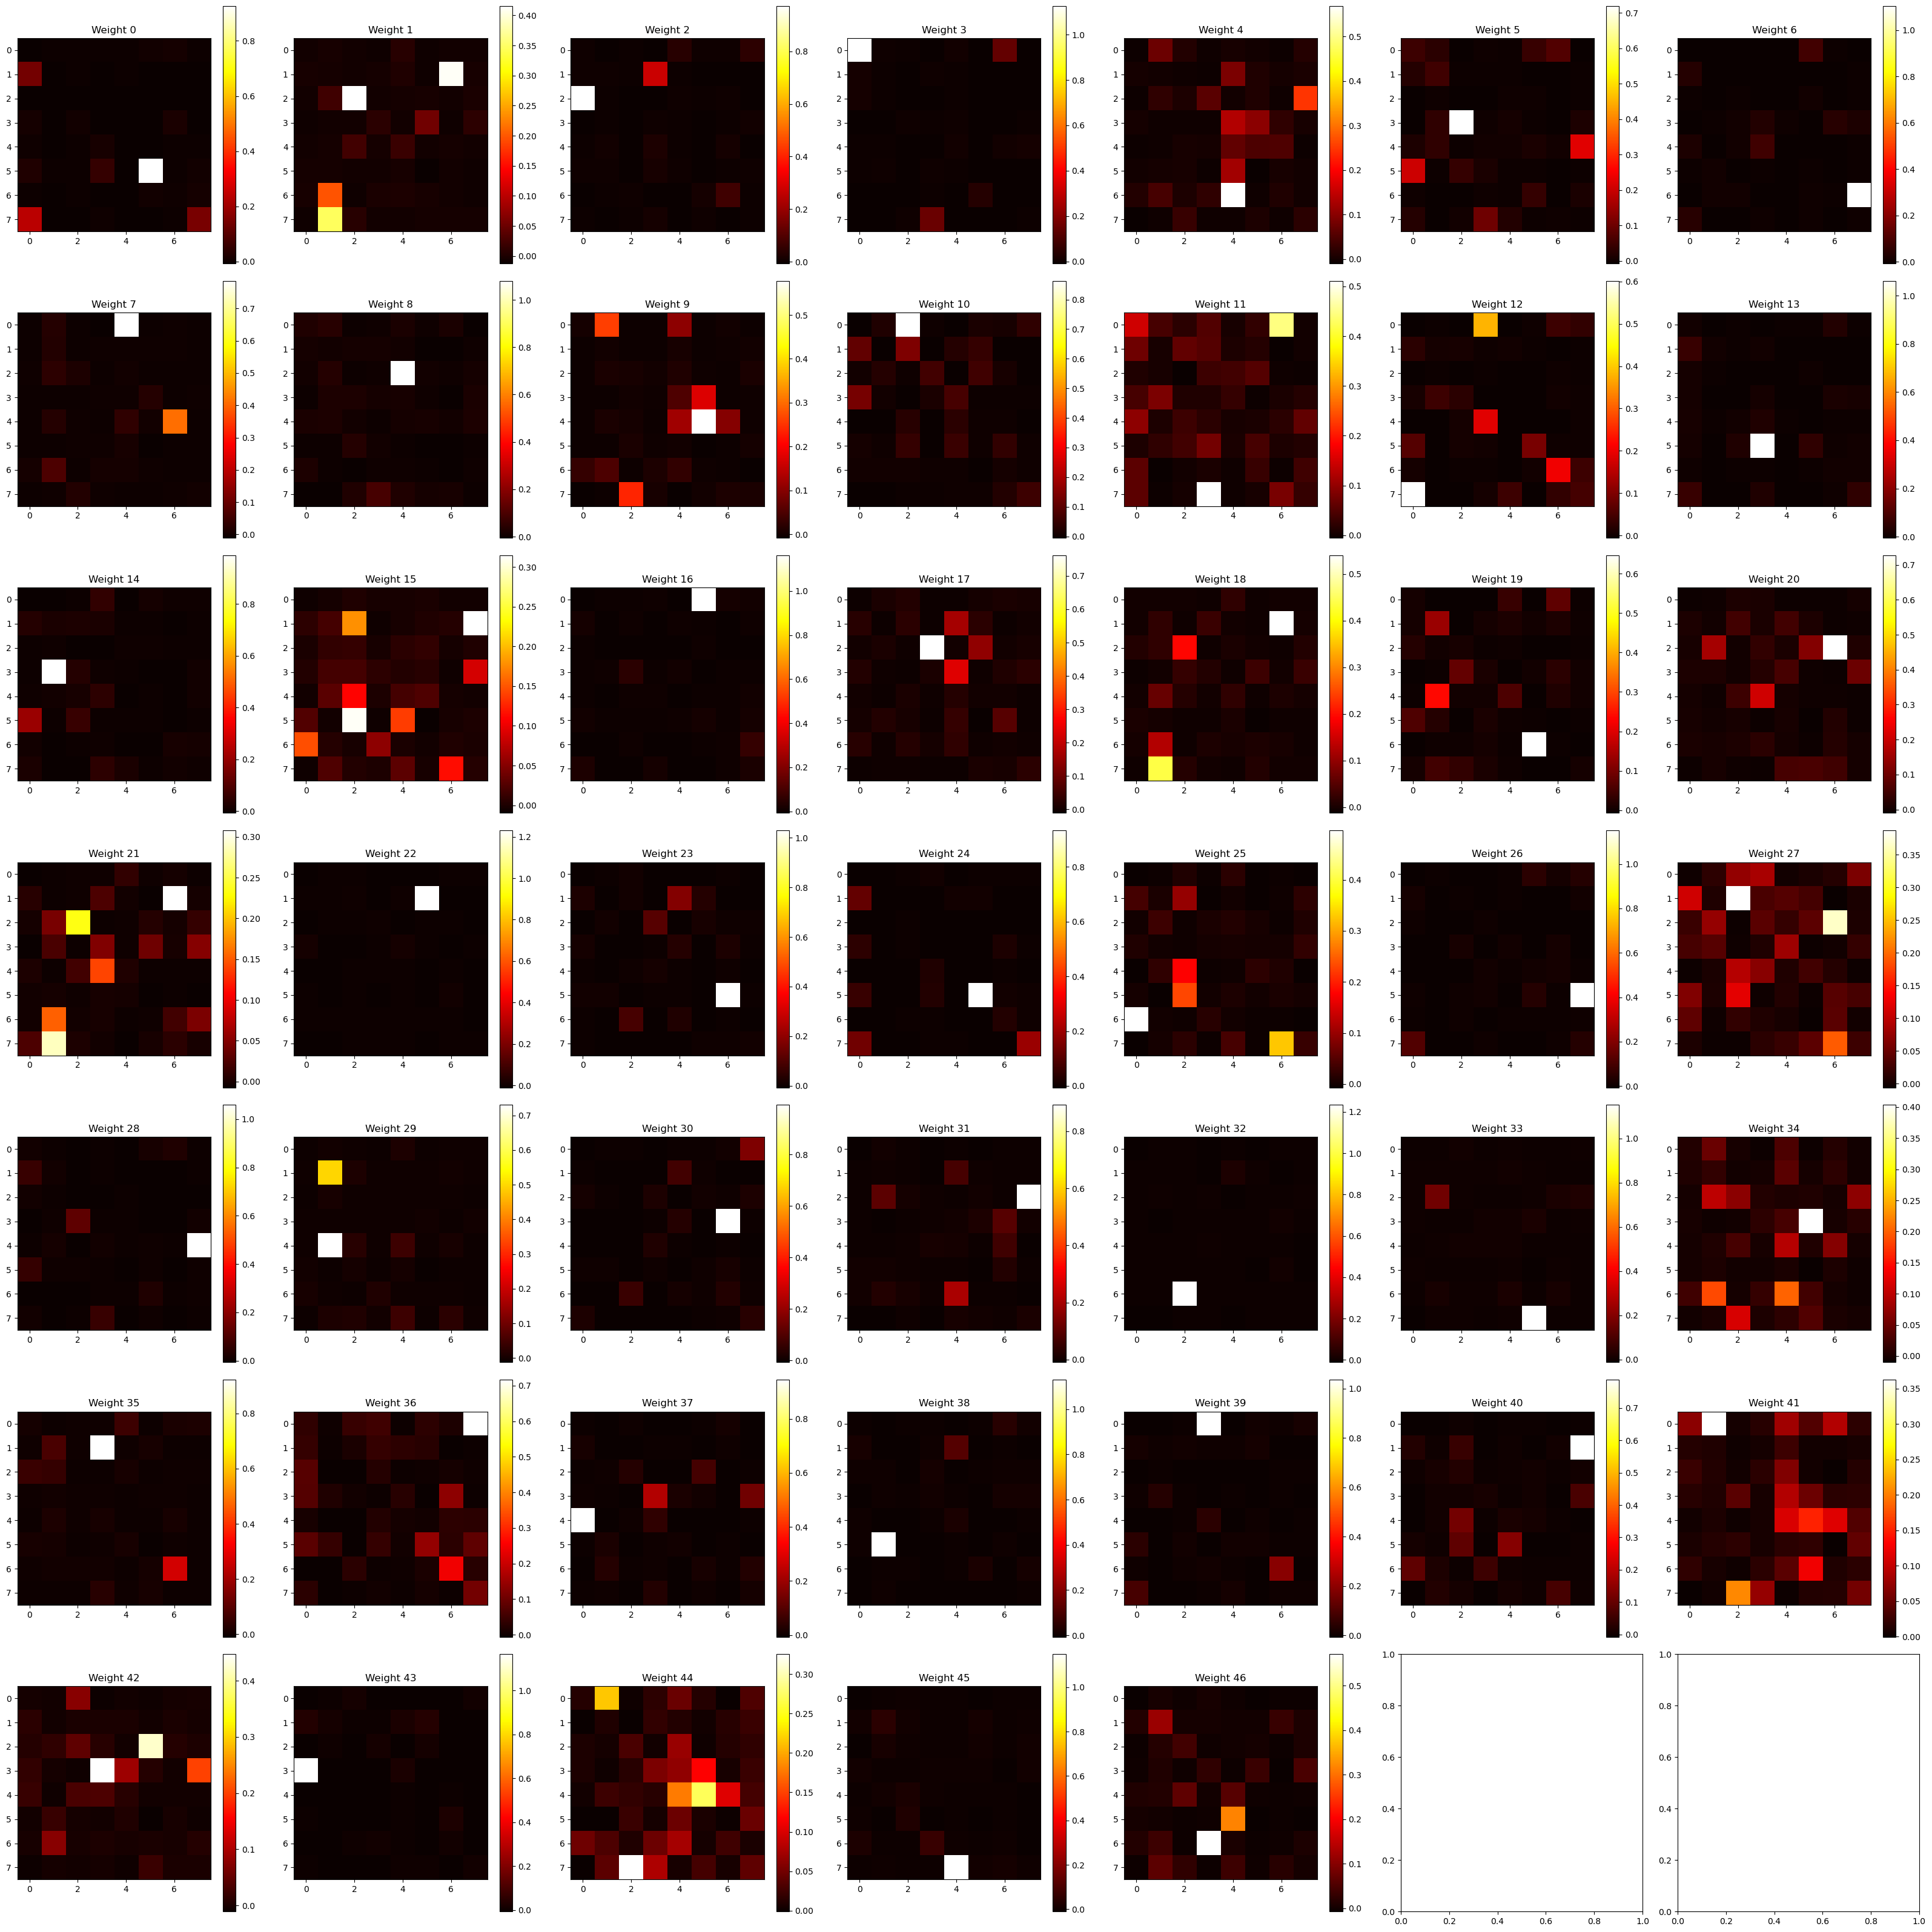

In [1082]:
emnist_topdown.visualize_weights()

## MLP

### No Noise

In [583]:
lambs = [1, 2, 3, 10, 14, 15, 16]
eps = [0.0001, 0.001, 0.01, 0.1]

In [584]:
for l in lambs:
    for e in eps:
        MLPBaseline_EMNIST_MP = MLPBaseline_Experiment(3, 256, l, 0.005, Learning.FullyOrthogonal, e, emnist_train_loader, 47)
        print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_loader))

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.26180851063829785, {18: (0, 400), 28: (41, 400), 22: (193, 400), 46: (108, 400), 5: (0, 400), 17: (24, 400), 4: (123, 400), 27: (43, 400), 0: (189, 400), 21: (29, 400), 1: (223, 400), 8: (312, 400), 12: (151, 400), 38: (144, 400), 44: (75, 400), 37: (160, 400), 11: (35, 400), 29: (262, 400), 7: (121, 400), 19: (65, 400), 3: (132, 400), 43: (190, 400), 16: (111, 400), 41: (41, 400), 45: (47, 400), 30: (46, 400), 31: (110, 400), 32: (296, 400), 10: (133, 400), 2: (26, 400), 33: (2, 400), 42: (146, 400), 20: (123, 400), 9: (8, 400), 36: (34, 400), 24: (0, 400), 23: (200, 400), 35: (89, 400), 40: (114, 400), 15: (138, 400), 39: (166, 400), 26: (24, 400), 6: (108, 400), 25: (0, 400), 13: (101, 400), 14: (48, 400), 34: (191, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.39063829787234045, {11: (132, 400), 16: (145, 400), 38: (203, 400), 3: (157, 400), 31: (117, 400), 42: (157, 400), 5: (171, 400), 17: (184, 400), 26: (149, 400), 46: (120, 400), 34: (148, 400), 2: (181, 400), 29: (207, 400), 7: (142, 400), 10: (107, 400), 35: (74, 400), 21: (38, 400), 22: (227, 400), 36: (224, 400), 25: (74, 400), 1: (24, 400), 40: (199, 400), 44: (31, 400), 15: (102, 400), 12: (71, 400), 33: (319, 400), 27: (55, 400), 28: (193, 400), 32: (251, 400), 45: (249, 400), 41: (74, 400), 23: (173, 400), 19: (181, 400), 4: (146, 400), 9: (146, 400), 18: (232, 400), 20: (92, 400), 6: (139, 400), 13: (178, 400), 14: (58, 400), 24: (54, 400), 8: (319, 400), 0: (216, 400), 37: (260, 400), 39: (180, 400), 30: (201, 400), 43: (244, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4554787234042553, {26: (138, 400), 31: (200, 400), 34: (145, 400), 30: (86, 400), 7: (224, 400), 44: (100, 400), 9: (180, 400), 24: (74, 400), 13: (209, 400), 36: (196, 400), 17: (174, 400), 29: (268, 400), 15: (98, 400), 28: (279, 400), 33: (238, 400), 38: (227, 400), 40: (151, 400), 6: (237, 400), 32: (294, 400), 37: (280, 400), 2: (208, 400), 19: (158, 400), 35: (164, 400), 41: (96, 400), 3: (292, 400), 46: (166, 400), 14: (221, 400), 18: (99, 400), 21: (29, 400), 4: (137, 400), 22: (274, 400), 25: (214, 400), 12: (109, 400), 5: (106, 400), 42: (187, 400), 20: (189, 400), 10: (199, 400), 0: (217, 400), 1: (185, 400), 27: (199, 400), 43: (283, 400), 16: (235, 400), 45: (267, 400), 8: (133, 400), 23: (137, 400), 11: (126, 400), 39: (135, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {33: (0, 400), 31: (0, 400), 5: (0, 400), 34: (0, 400), 39: (0, 400), 19: (0, 400), 9: (0, 400), 41: (0, 400), 4: (0, 400), 30: (0, 400), 40: (0, 400), 0: (400, 400), 26: (0, 400), 44: (0, 400), 36: (0, 400), 6: (0, 400), 28: (0, 400), 46: (0, 400), 20: (0, 400), 42: (0, 400), 12: (0, 400), 37: (0, 400), 16: (0, 400), 23: (0, 400), 32: (0, 400), 3: (0, 400), 35: (0, 400), 27: (0, 400), 22: (0, 400), 24: (0, 400), 7: (0, 400), 14: (0, 400), 18: (0, 400), 15: (0, 400), 38: (0, 400), 8: (0, 400), 25: (0, 400), 2: (0, 400), 45: (0, 400), 13: (0, 400), 10: (0, 400), 17: (0, 400), 11: (0, 400), 43: (0, 400), 21: (0, 400), 1: (0, 400), 29: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.17712765957446808, {39: (132, 400), 46: (17, 400), 25: (0, 400), 24: (0, 400), 22: (231, 400), 17: (81, 400), 5: (16, 400), 45: (128, 400), 19: (60, 400), 13: (17, 400), 14: (3, 400), 2: (26, 400), 27: (35, 400), 36: (49, 400), 29: (99, 400), 18: (103, 400), 31: (18, 400), 6: (2, 400), 38: (111, 400), 1: (122, 400), 26: (0, 400), 12: (112, 400), 42: (108, 400), 30: (52, 400), 16: (152, 400), 20: (30, 400), 4: (51, 400), 9: (1, 400), 33: (51, 400), 23: (140, 400), 7: (167, 400), 37: (9, 400), 28: (63, 400), 3: (1, 400), 32: (201, 400), 43: (0, 400), 0: (218, 400), 11: (58, 400), 10: (50, 400), 40: (92, 400), 41: (16, 400), 15: (50, 400), 35: (1, 400), 8: (336, 400), 44: (47, 400), 34: (51, 400), 21: (23, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2302659574468085, {22: (237, 400), 44: (46, 400), 6: (85, 400), 36: (97, 400), 28: (76, 400), 1: (269, 400), 29: (91, 400), 5: (22, 400), 24: (0, 400), 42: (88, 400), 41: (35, 400), 14: (57, 400), 45: (113, 400), 16: (231, 400), 32: (275, 400), 10: (45, 400), 19: (110, 400), 43: (76, 400), 9: (55, 400), 0: (0, 400), 11: (12, 400), 34: (153, 400), 23: (23, 400), 25: (127, 400), 18: (34, 400), 7: (149, 400), 13: (48, 400), 30: (129, 400), 39: (129, 400), 15: (2, 400), 21: (56, 400), 2: (144, 400), 35: (48, 400), 46: (37, 400), 31: (54, 400), 33: (151, 400), 3: (108, 400), 38: (120, 400), 26: (62, 400), 8: (207, 400), 20: (31, 400), 17: (89, 400), 37: (103, 400), 12: (13, 400), 27: (40, 400), 40: (127, 400), 4: (125, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4479787234042553, {29: (252, 400), 2: (156, 400), 35: (182, 400), 30: (188, 400), 43: (173, 400), 45: (222, 400), 14: (129, 400), 7: (263, 400), 10: (172, 400), 38: (231, 400), 1: (212, 400), 24: (82, 400), 23: (271, 400), 18: (145, 400), 26: (150, 400), 8: (142, 400), 6: (255, 400), 15: (93, 400), 20: (124, 400), 33: (211, 400), 11: (114, 400), 13: (115, 400), 37: (268, 400), 19: (145, 400), 42: (140, 400), 22: (321, 400), 9: (133, 400), 17: (169, 400), 5: (145, 400), 46: (122, 400), 21: (6, 400), 36: (219, 400), 28: (267, 400), 31: (209, 400), 40: (130, 400), 39: (279, 400), 0: (218, 400), 25: (262, 400), 4: (189, 400), 12: (227, 400), 44: (133, 400), 32: (230, 400), 34: (194, 400), 41: (49, 400), 3: (264, 400), 27: (37, 400), 16: (184, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.11718085106382979, {3: (54, 400), 12: (29, 400), 24: (2, 400), 17: (50, 400), 35: (62, 400), 18: (54, 400), 0: (102, 400), 46: (53, 400), 11: (7, 400), 28: (111, 400), 9: (42, 400), 36: (59, 400), 30: (22, 400), 42: (52, 400), 10: (10, 400), 45: (26, 400), 31: (0, 400), 26: (62, 400), 29: (15, 400), 5: (51, 400), 19: (37, 400), 33: (77, 400), 14: (99, 400), 4: (94, 400), 8: (96, 400), 41: (13, 400), 44: (16, 400), 43: (77, 400), 13: (3, 400), 32: (7, 400), 38: (43, 400), 25: (128, 400), 6: (19, 400), 1: (6, 400), 37: (137, 400), 27: (51, 400), 34: (10, 400), 39: (36, 400), 22: (171, 400), 2: (27, 400), 40: (7, 400), 20: (13, 400), 7: (25, 400), 15: (29, 400), 23: (58, 400), 16: (57, 400), 21: (4, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.09420212765957447, {11: (18, 400), 31: (55, 400), 19: (9, 400), 30: (84, 400), 44: (18, 400), 28: (14, 400), 13: (114, 400), 10: (121, 400), 0: (0, 400), 41: (1, 400), 45: (70, 400), 5: (40, 400), 27: (17, 400), 9: (18, 400), 24: (0, 400), 21: (1, 400), 25: (0, 400), 2: (8, 400), 42: (0, 400), 35: (0, 400), 40: (44, 400), 32: (184, 400), 7: (31, 400), 36: (1, 400), 33: (5, 400), 38: (62, 400), 46: (0, 400), 26: (3, 400), 34: (12, 400), 8: (367, 400), 16: (12, 400), 43: (85, 400), 20: (0, 400), 14: (0, 400), 4: (37, 400), 1: (0, 400), 29: (33, 400), 23: (27, 400), 17: (0, 400), 15: (33, 400), 37: (3, 400), 39: (10, 400), 18: (38, 400), 3: (0, 400), 6: (17, 400), 12: (1, 400), 22: (178, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.16611702127659575, {28: (2, 400), 36: (76, 400), 1: (232, 400), 21: (2, 400), 25: (14, 400), 8: (0, 400), 20: (29, 400), 4: (3, 400), 37: (40, 400), 13: (9, 400), 19: (103, 400), 35: (13, 400), 40: (35, 400), 29: (168, 400), 2: (96, 400), 6: (7, 400), 17: (70, 400), 46: (102, 400), 14: (6, 400), 32: (143, 400), 45: (103, 400), 0: (31, 400), 38: (29, 400), 22: (196, 400), 3: (29, 400), 18: (15, 400), 39: (207, 400), 34: (1, 400), 15: (28, 400), 16: (206, 400), 5: (115, 400), 10: (43, 400), 26: (49, 400), 27: (31, 400), 44: (14, 400), 43: (125, 400), 41: (24, 400), 12: (0, 400), 24: (39, 400), 30: (91, 400), 42: (65, 400), 31: (141, 400), 11: (67, 400), 7: (37, 400), 23: (0, 400), 9: (215, 400), 33: (72, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3956914893617021, {32: (305, 400), 34: (126, 400), 46: (140, 400), 33: (204, 400), 11: (111, 400), 45: (250, 400), 22: (288, 400), 41: (50, 400), 25: (120, 400), 1: (167, 400), 7: (206, 400), 16: (146, 400), 13: (158, 400), 29: (131, 400), 21: (2, 400), 2: (186, 400), 36: (140, 400), 14: (226, 400), 30: (127, 400), 43: (130, 400), 6: (174, 400), 4: (181, 400), 19: (60, 400), 20: (132, 400), 10: (111, 400), 37: (202, 400), 27: (131, 400), 23: (179, 400), 18: (212, 400), 17: (148, 400), 42: (183, 400), 40: (160, 400), 3: (331, 400), 31: (215, 400), 5: (72, 400), 9: (117, 400), 12: (261, 400), 28: (264, 400), 39: (317, 400), 38: (121, 400), 26: (113, 400), 44: (81, 400), 0: (1, 400), 35: (97, 400), 24: (178, 400), 8: (138, 400), 15: (47, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.1573404255319149, {0: (110, 400), 24: (20, 400), 33: (62, 400), 27: (68, 400), 26: (51, 400), 30: (79, 400), 5: (83, 400), 10: (20, 400), 15: (30, 400), 36: (32, 400), 42: (61, 400), 38: (49, 400), 22: (133, 400), 17: (16, 400), 12: (66, 400), 31: (122, 400), 41: (15, 400), 1: (0, 400), 40: (1, 400), 6: (145, 400), 21: (32, 400), 46: (25, 400), 3: (86, 400), 20: (26, 400), 8: (122, 400), 2: (167, 400), 16: (4, 400), 44: (19, 400), 25: (12, 400), 13: (52, 400), 34: (6, 400), 45: (42, 400), 28: (30, 400), 4: (9, 400), 29: (172, 400), 35: (137, 400), 43: (21, 400), 19: (4, 400), 37: (95, 400), 11: (245, 400), 23: (47, 400), 14: (170, 400), 18: (100, 400), 32: (4, 400), 7: (13, 400), 9: (97, 400), 39: (58, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {36: (0, 400), 37: (0, 400), 19: (0, 400), 11: (0, 400), 4: (0, 400), 45: (0, 400), 27: (0, 400), 14: (0, 400), 20: (0, 400), 18: (0, 400), 16: (0, 400), 8: (0, 400), 24: (0, 400), 31: (0, 400), 26: (0, 400), 22: (0, 400), 10: (0, 400), 23: (400, 400), 0: (0, 400), 34: (0, 400), 44: (0, 400), 33: (0, 400), 40: (0, 400), 17: (0, 400), 21: (0, 400), 7: (0, 400), 5: (0, 400), 9: (0, 400), 35: (0, 400), 29: (0, 400), 28: (0, 400), 3: (0, 400), 2: (0, 400), 15: (0, 400), 32: (0, 400), 30: (0, 400), 41: (0, 400), 39: (0, 400), 43: (0, 400), 25: (0, 400), 1: (0, 400), 42: (0, 400), 6: (0, 400), 38: (0, 400), 13: (0, 400), 46: (0, 400), 12: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02271276595744681, {32: (0, 400), 34: (2, 400), 36: (0, 400), 1: (0, 400), 16: (2, 400), 3: (0, 400), 2: (0, 400), 41: (0, 400), 18: (0, 400), 11: (0, 400), 42: (0, 400), 33: (0, 400), 19: (0, 400), 21: (0, 400), 22: (2, 400), 12: (0, 400), 43: (0, 400), 25: (391, 400), 14: (2, 400), 20: (0, 400), 30: (0, 400), 5: (2, 400), 24: (1, 400), 28: (0, 400), 46: (0, 400), 17: (1, 400), 13: (0, 400), 39: (0, 400), 31: (0, 400), 45: (0, 400), 6: (0, 400), 9: (0, 400), 15: (0, 400), 38: (0, 400), 23: (0, 400), 26: (1, 400), 29: (0, 400), 7: (19, 400), 40: (0, 400), 10: (0, 400), 8: (0, 400), 37: (0, 400), 27: (0, 400), 4: (3, 400), 0: (0, 400), 35: (0, 400), 44: (1, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5118085106382979, {41: (90, 400), 37: (291, 400), 40: (231, 400), 34: (147, 400), 28: (212, 400), 33: (290, 400), 39: (177, 400), 27: (181, 400), 21: (118, 400), 35: (276, 400), 43: (239, 400), 7: (311, 400), 46: (171, 400), 12: (124, 400), 6: (254, 400), 18: (143, 400), 1: (147, 400), 36: (251, 400), 30: (199, 400), 20: (172, 400), 19: (129, 400), 14: (294, 400), 11: (256, 400), 10: (244, 400), 29: (282, 400), 2: (238, 400), 5: (132, 400), 38: (268, 400), 17: (215, 400), 26: (211, 400), 13: (163, 400), 23: (223, 400), 0: (8, 400), 8: (224, 400), 42: (156, 400), 24: (188, 400), 9: (186, 400), 45: (242, 400), 3: (256, 400), 44: (173, 400), 32: (286, 400), 4: (142, 400), 31: (236, 400), 22: (293, 400), 16: (233, 400), 15: (67, 400), 25: (253, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3027127659574468, {7: (188, 400), 25: (100, 400), 16: (51, 400), 31: (140, 400), 23: (41, 400), 42: (155, 400), 18: (2, 400), 37: (156, 400), 2: (84, 400), 8: (147, 400), 1: (323, 400), 28: (163, 400), 27: (78, 400), 10: (58, 400), 13: (29, 400), 43: (113, 400), 30: (169, 400), 12: (213, 400), 41: (7, 400), 11: (45, 400), 21: (3, 400), 5: (55, 400), 46: (77, 400), 6: (11, 400), 19: (88, 400), 44: (102, 400), 35: (44, 400), 0: (219, 400), 45: (90, 400), 22: (241, 400), 38: (96, 400), 9: (36, 400), 33: (279, 400), 24: (182, 400), 29: (314, 400), 40: (98, 400), 14: (226, 400), 15: (76, 400), 4: (116, 400), 26: (150, 400), 17: (106, 400), 34: (39, 400), 3: (216, 400), 20: (150, 400), 36: (30, 400), 39: (68, 400), 32: (317, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {2: (0, 400), 7: (0, 400), 25: (0, 400), 28: (0, 400), 24: (0, 400), 12: (0, 400), 3: (0, 400), 8: (0, 400), 22: (0, 400), 18: (0, 400), 26: (0, 400), 33: (0, 400), 45: (0, 400), 15: (0, 400), 19: (0, 400), 14: (0, 400), 35: (0, 400), 41: (0, 400), 40: (0, 400), 34: (0, 400), 23: (0, 400), 11: (400, 400), 42: (0, 400), 30: (0, 400), 10: (0, 400), 44: (0, 400), 32: (0, 400), 38: (0, 400), 0: (0, 400), 46: (0, 400), 39: (0, 400), 20: (0, 400), 36: (0, 400), 21: (0, 400), 27: (0, 400), 9: (0, 400), 43: (0, 400), 13: (0, 400), 17: (0, 400), 37: (0, 400), 4: (0, 400), 1: (0, 400), 6: (0, 400), 29: (0, 400), 5: (0, 400), 16: (0, 400), 31: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.053351063829787236, {12: (0, 400), 28: (0, 400), 9: (0, 400), 0: (0, 400), 38: (305, 400), 46: (0, 400), 14: (0, 400), 20: (0, 400), 18: (221, 400), 8: (0, 400), 34: (24, 400), 1: (0, 400), 7: (0, 400), 40: (0, 400), 27: (0, 400), 16: (0, 400), 22: (228, 400), 17: (0, 400), 3: (0, 400), 6: (0, 400), 19: (1, 400), 4: (0, 400), 35: (0, 400), 30: (0, 400), 44: (0, 400), 31: (0, 400), 2: (0, 400), 5: (0, 400), 36: (1, 400), 10: (0, 400), 13: (0, 400), 23: (3, 400), 11: (0, 400), 29: (3, 400), 21: (1, 400), 15: (172, 400), 37: (0, 400), 32: (0, 400), 25: (0, 400), 43: (43, 400), 42: (0, 400), 41: (0, 400), 26: (0, 400), 24: (1, 400), 45: (0, 400), 39: (0, 400), 33: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5422872340425532, {27: (159, 400), 2: (170, 400), 3: (256, 400), 5: (180, 400), 28: (263, 400), 18: (124, 400), 43: (202, 400), 41: (115, 400), 33: (204, 400), 21: (192, 400), 20: (269, 400), 40: (202, 400), 16: (262, 400), 6: (300, 400), 10: (228, 400), 42: (250, 400), 7: (278, 400), 0: (169, 400), 23: (241, 400), 22: (335, 400), 44: (177, 400), 45: (292, 400), 14: (259, 400), 26: (232, 400), 31: (198, 400), 34: (185, 400), 29: (278, 400), 39: (230, 400), 37: (233, 400), 17: (244, 400), 11: (250, 400), 1: (153, 400), 12: (213, 400), 30: (223, 400), 32: (319, 400), 19: (121, 400), 46: (142, 400), 25: (225, 400), 4: (235, 400), 38: (257, 400), 36: (198, 400), 13: (194, 400), 8: (171, 400), 15: (105, 400), 35: (287, 400), 24: (227, 400), 9: (148, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {13: (0, 400), 45: (0, 400), 21: (0, 400), 8: (0, 400), 44: (0, 400), 4: (0, 400), 6: (0, 400), 3: (0, 400), 31: (0, 400), 24: (0, 400), 33: (0, 400), 37: (0, 400), 11: (0, 400), 9: (0, 400), 25: (0, 400), 17: (0, 400), 41: (0, 400), 16: (0, 400), 36: (0, 400), 2: (0, 400), 22: (0, 400), 34: (0, 400), 15: (0, 400), 27: (0, 400), 43: (0, 400), 46: (0, 400), 10: (0, 400), 29: (0, 400), 32: (0, 400), 39: (0, 400), 35: (0, 400), 23: (0, 400), 42: (0, 400), 5: (0, 400), 18: (0, 400), 20: (0, 400), 1: (0, 400), 38: (0, 400), 28: (0, 400), 0: (400, 400), 12: (0, 400), 30: (0, 400), 14: (0, 400), 40: (0, 400), 26: (0, 400), 19: (0, 400), 7: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {5: (0, 400), 34: (0, 400), 15: (0, 400), 37: (0, 400), 8: (0, 400), 4: (0, 400), 28: (0, 400), 40: (0, 400), 46: (0, 400), 27: (0, 400), 29: (0, 400), 31: (0, 400), 17: (0, 400), 2: (0, 400), 41: (0, 400), 9: (0, 400), 6: (0, 400), 23: (0, 400), 45: (0, 400), 30: (0, 400), 7: (0, 400), 13: (0, 400), 11: (0, 400), 24: (0, 400), 21: (0, 400), 42: (0, 400), 3: (0, 400), 35: (0, 400), 14: (0, 400), 44: (0, 400), 19: (0, 400), 36: (0, 400), 1: (0, 400), 18: (0, 400), 43: (0, 400), 25: (0, 400), 12: (0, 400), 20: (0, 400), 32: (0, 400), 26: (0, 400), 39: (0, 400), 38: (400, 400), 22: (0, 400), 10: (0, 400), 16: (0, 400), 0: (0, 400), 33: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.033829787234042556, {33: (0, 400), 42: (0, 400), 26: (2, 400), 7: (131, 400), 25: (0, 400), 32: (5, 400), 44: (6, 400), 31: (0, 400), 0: (0, 400), 17: (0, 400), 3: (0, 400), 45: (0, 400), 36: (29, 400), 35: (0, 400), 19: (11, 400), 5: (0, 400), 14: (0, 400), 10: (0, 400), 38: (3, 400), 46: (0, 400), 13: (0, 400), 6: (0, 400), 8: (0, 400), 12: (0, 400), 24: (0, 400), 23: (85, 400), 4: (0, 400), 21: (0, 400), 20: (0, 400), 9: (0, 400), 40: (340, 400), 34: (0, 400), 1: (0, 400), 16: (0, 400), 2: (0, 400), 27: (0, 400), 15: (0, 400), 18: (1, 400), 41: (0, 400), 37: (0, 400), 11: (0, 400), 30: (0, 400), 43: (0, 400), 22: (1, 400), 29: (22, 400), 39: (0, 400), 28: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5485106382978724, {28: (249, 400), 24: (226, 400), 27: (152, 400), 21: (114, 400), 35: (316, 400), 33: (247, 400), 9: (107, 400), 31: (276, 400), 30: (130, 400), 18: (81, 400), 39: (274, 400), 0: (187, 400), 20: (199, 400), 3: (279, 400), 13: (233, 400), 43: (262, 400), 19: (175, 400), 14: (235, 400), 17: (232, 400), 10: (248, 400), 34: (171, 400), 2: (228, 400), 22: (333, 400), 29: (186, 400), 11: (182, 400), 46: (217, 400), 41: (108, 400), 40: (161, 400), 23: (222, 400), 26: (230, 400), 8: (198, 400), 15: (147, 400), 32: (352, 400), 7: (315, 400), 36: (223, 400), 42: (169, 400), 1: (256, 400), 16: (257, 400), 38: (294, 400), 4: (178, 400), 25: (229, 400), 6: (284, 400), 45: (304, 400), 37: (279, 400), 5: (189, 400), 12: (205, 400), 44: (173, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {25: (0, 400), 10: (0, 400), 45: (0, 400), 9: (0, 400), 43: (0, 400), 11: (0, 400), 39: (0, 400), 21: (0, 400), 46: (0, 400), 8: (0, 400), 38: (0, 400), 5: (0, 400), 42: (0, 400), 28: (0, 400), 30: (0, 400), 24: (0, 400), 19: (0, 400), 2: (0, 400), 17: (0, 400), 7: (0, 400), 6: (0, 400), 27: (0, 400), 18: (0, 400), 26: (0, 400), 15: (0, 400), 22: (0, 400), 36: (0, 400), 0: (400, 400), 4: (0, 400), 41: (0, 400), 44: (0, 400), 33: (0, 400), 1: (0, 400), 20: (0, 400), 40: (0, 400), 34: (0, 400), 31: (0, 400), 35: (0, 400), 14: (0, 400), 29: (0, 400), 32: (0, 400), 3: (0, 400), 12: (0, 400), 23: (0, 400), 13: (0, 400), 37: (0, 400), 16: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {12: (0, 400), 2: (0, 400), 35: (0, 400), 13: (0, 400), 46: (0, 400), 25: (0, 400), 39: (0, 400), 28: (0, 400), 20: (0, 400), 24: (0, 400), 17: (0, 400), 45: (0, 400), 37: (0, 400), 29: (0, 400), 31: (0, 400), 19: (0, 400), 32: (0, 400), 16: (0, 400), 9: (0, 400), 44: (0, 400), 43: (0, 400), 18: (0, 400), 40: (400, 400), 33: (0, 400), 42: (0, 400), 34: (0, 400), 10: (0, 400), 11: (0, 400), 21: (0, 400), 14: (0, 400), 38: (0, 400), 30: (0, 400), 8: (0, 400), 4: (0, 400), 23: (0, 400), 27: (0, 400), 36: (0, 400), 0: (0, 400), 5: (0, 400), 26: (0, 400), 7: (0, 400), 1: (0, 400), 41: (0, 400), 3: (0, 400), 22: (0, 400), 15: (0, 400), 6: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.04680851063829787, {18: (3, 400), 5: (0, 400), 7: (370, 400), 3: (0, 400), 27: (0, 400), 37: (0, 400), 10: (0, 400), 43: (0, 400), 28: (0, 400), 30: (1, 400), 42: (0, 400), 19: (3, 400), 11: (0, 400), 1: (234, 400), 34: (0, 400), 6: (0, 400), 35: (0, 400), 26: (0, 400), 40: (2, 400), 41: (0, 400), 39: (0, 400), 20: (1, 400), 21: (16, 400), 8: (0, 400), 17: (0, 400), 38: (0, 400), 15: (0, 400), 0: (0, 400), 12: (10, 400), 9: (2, 400), 44: (0, 400), 36: (0, 400), 13: (24, 400), 24: (0, 400), 46: (10, 400), 32: (179, 400), 14: (0, 400), 2: (0, 400), 31: (0, 400), 25: (0, 400), 16: (0, 400), 4: (0, 400), 33: (0, 400), 29: (7, 400), 23: (14, 400), 22: (0, 400), 45: (4, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5381914893617021, {1: (125, 400), 2: (260, 400), 33: (242, 400), 27: (94, 400), 38: (262, 400), 46: (160, 400), 5: (220, 400), 4: (180, 400), 16: (210, 400), 8: (173, 400), 7: (321, 400), 26: (202, 400), 9: (114, 400), 18: (82, 400), 17: (283, 400), 19: (178, 400), 41: (117, 400), 13: (200, 400), 37: (231, 400), 35: (295, 400), 28: (274, 400), 44: (168, 400), 15: (207, 400), 40: (40, 400), 14: (188, 400), 12: (231, 400), 30: (230, 400), 3: (291, 400), 34: (173, 400), 25: (256, 400), 31: (287, 400), 42: (182, 400), 0: (268, 400), 20: (206, 400), 29: (253, 400), 22: (320, 400), 21: (218, 400), 43: (249, 400), 11: (215, 400), 10: (210, 400), 39: (230, 400), 6: (337, 400), 24: (196, 400), 23: (189, 400), 36: (179, 400), 45: (286, 400), 32: (286, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {28: (0, 400), 44: (0, 400), 46: (0, 400), 29: (0, 400), 5: (0, 400), 2: (0, 400), 25: (0, 400), 23: (0, 400), 31: (0, 400), 21: (0, 400), 7: (0, 400), 12: (0, 400), 26: (0, 400), 1: (0, 400), 36: (0, 400), 10: (0, 400), 33: (0, 400), 15: (0, 400), 43: (0, 400), 22: (0, 400), 14: (0, 400), 3: (0, 400), 38: (0, 400), 20: (0, 400), 0: (400, 400), 32: (0, 400), 35: (0, 400), 42: (0, 400), 30: (0, 400), 8: (0, 400), 4: (0, 400), 27: (0, 400), 24: (0, 400), 11: (0, 400), 41: (0, 400), 45: (0, 400), 6: (0, 400), 37: (0, 400), 9: (0, 400), 19: (0, 400), 34: (0, 400), 39: (0, 400), 18: (0, 400), 17: (0, 400), 40: (0, 400), 13: (0, 400), 16: (0, 400)})


Lambda 15 and Epsilon 0.01 gave the highest accuracy

#### 144

In [592]:
MLPBaseline_EMNIST_MP = MLPBaseline_Experiment(3, 144, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_loader, 47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [593]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.49813829787234043, {34: (138, 400), 33: (225, 400), 40: (165, 400), 39: (238, 400), 15: (97, 400), 44: (129, 400), 2: (177, 400), 26: (145, 400), 12: (221, 400), 36: (194, 400), 43: (265, 400), 37: (167, 400), 4: (145, 400), 38: (259, 400), 35: (313, 400), 8: (179, 400), 30: (144, 400), 1: (248, 400), 14: (237, 400), 24: (181, 400), 7: (258, 400), 21: (96, 400), 16: (291, 400), 41: (133, 400), 3: (245, 400), 32: (291, 400), 46: (137, 400), 11: (181, 400), 10: (182, 400), 18: (80, 400), 22: (306, 400), 9: (175, 400), 25: (248, 400), 23: (211, 400), 5: (119, 400), 45: (290, 400), 6: (203, 400), 42: (258, 400), 28: (170, 400), 0: (246, 400), 13: (172, 400), 19: (133, 400), 17: (207, 400), 27: (167, 400), 31: (285, 400), 20: (206, 400), 29: (208, 400)})


In [586]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.47686170212765955, {26: (169, 400), 21: (227, 400), 20: (187, 400), 35: (256, 400), 13: (196, 400), 19: (127, 400), 44: (122, 400), 30: (132, 400), 8: (152, 400), 25: (233, 400), 5: (123, 400), 24: (182, 400), 42: (252, 400), 7: (165, 400), 3: (192, 400), 27: (146, 400), 41: (74, 400), 28: (216, 400), 40: (29, 400), 34: (139, 400), 22: (310, 400), 12: (253, 400), 36: (206, 400), 23: (180, 400), 0: (249, 400), 2: (228, 400), 32: (276, 400), 9: (190, 400), 6: (296, 400), 46: (129, 400), 4: (215, 400), 31: (217, 400), 43: (186, 400), 1: (116, 400), 33: (120, 400), 10: (250, 400), 14: (250, 400), 11: (198, 400), 45: (290, 400), 37: (199, 400), 18: (56, 400), 17: (216, 400), 38: (294, 400), 39: (158, 400), 29: (192, 400), 15: (139, 400), 16: (233, 400)})


#### 256

In [594]:
MLPBaseline_EMNIST_MP = MLPBaseline_Experiment(3, 256, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_loader, 47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

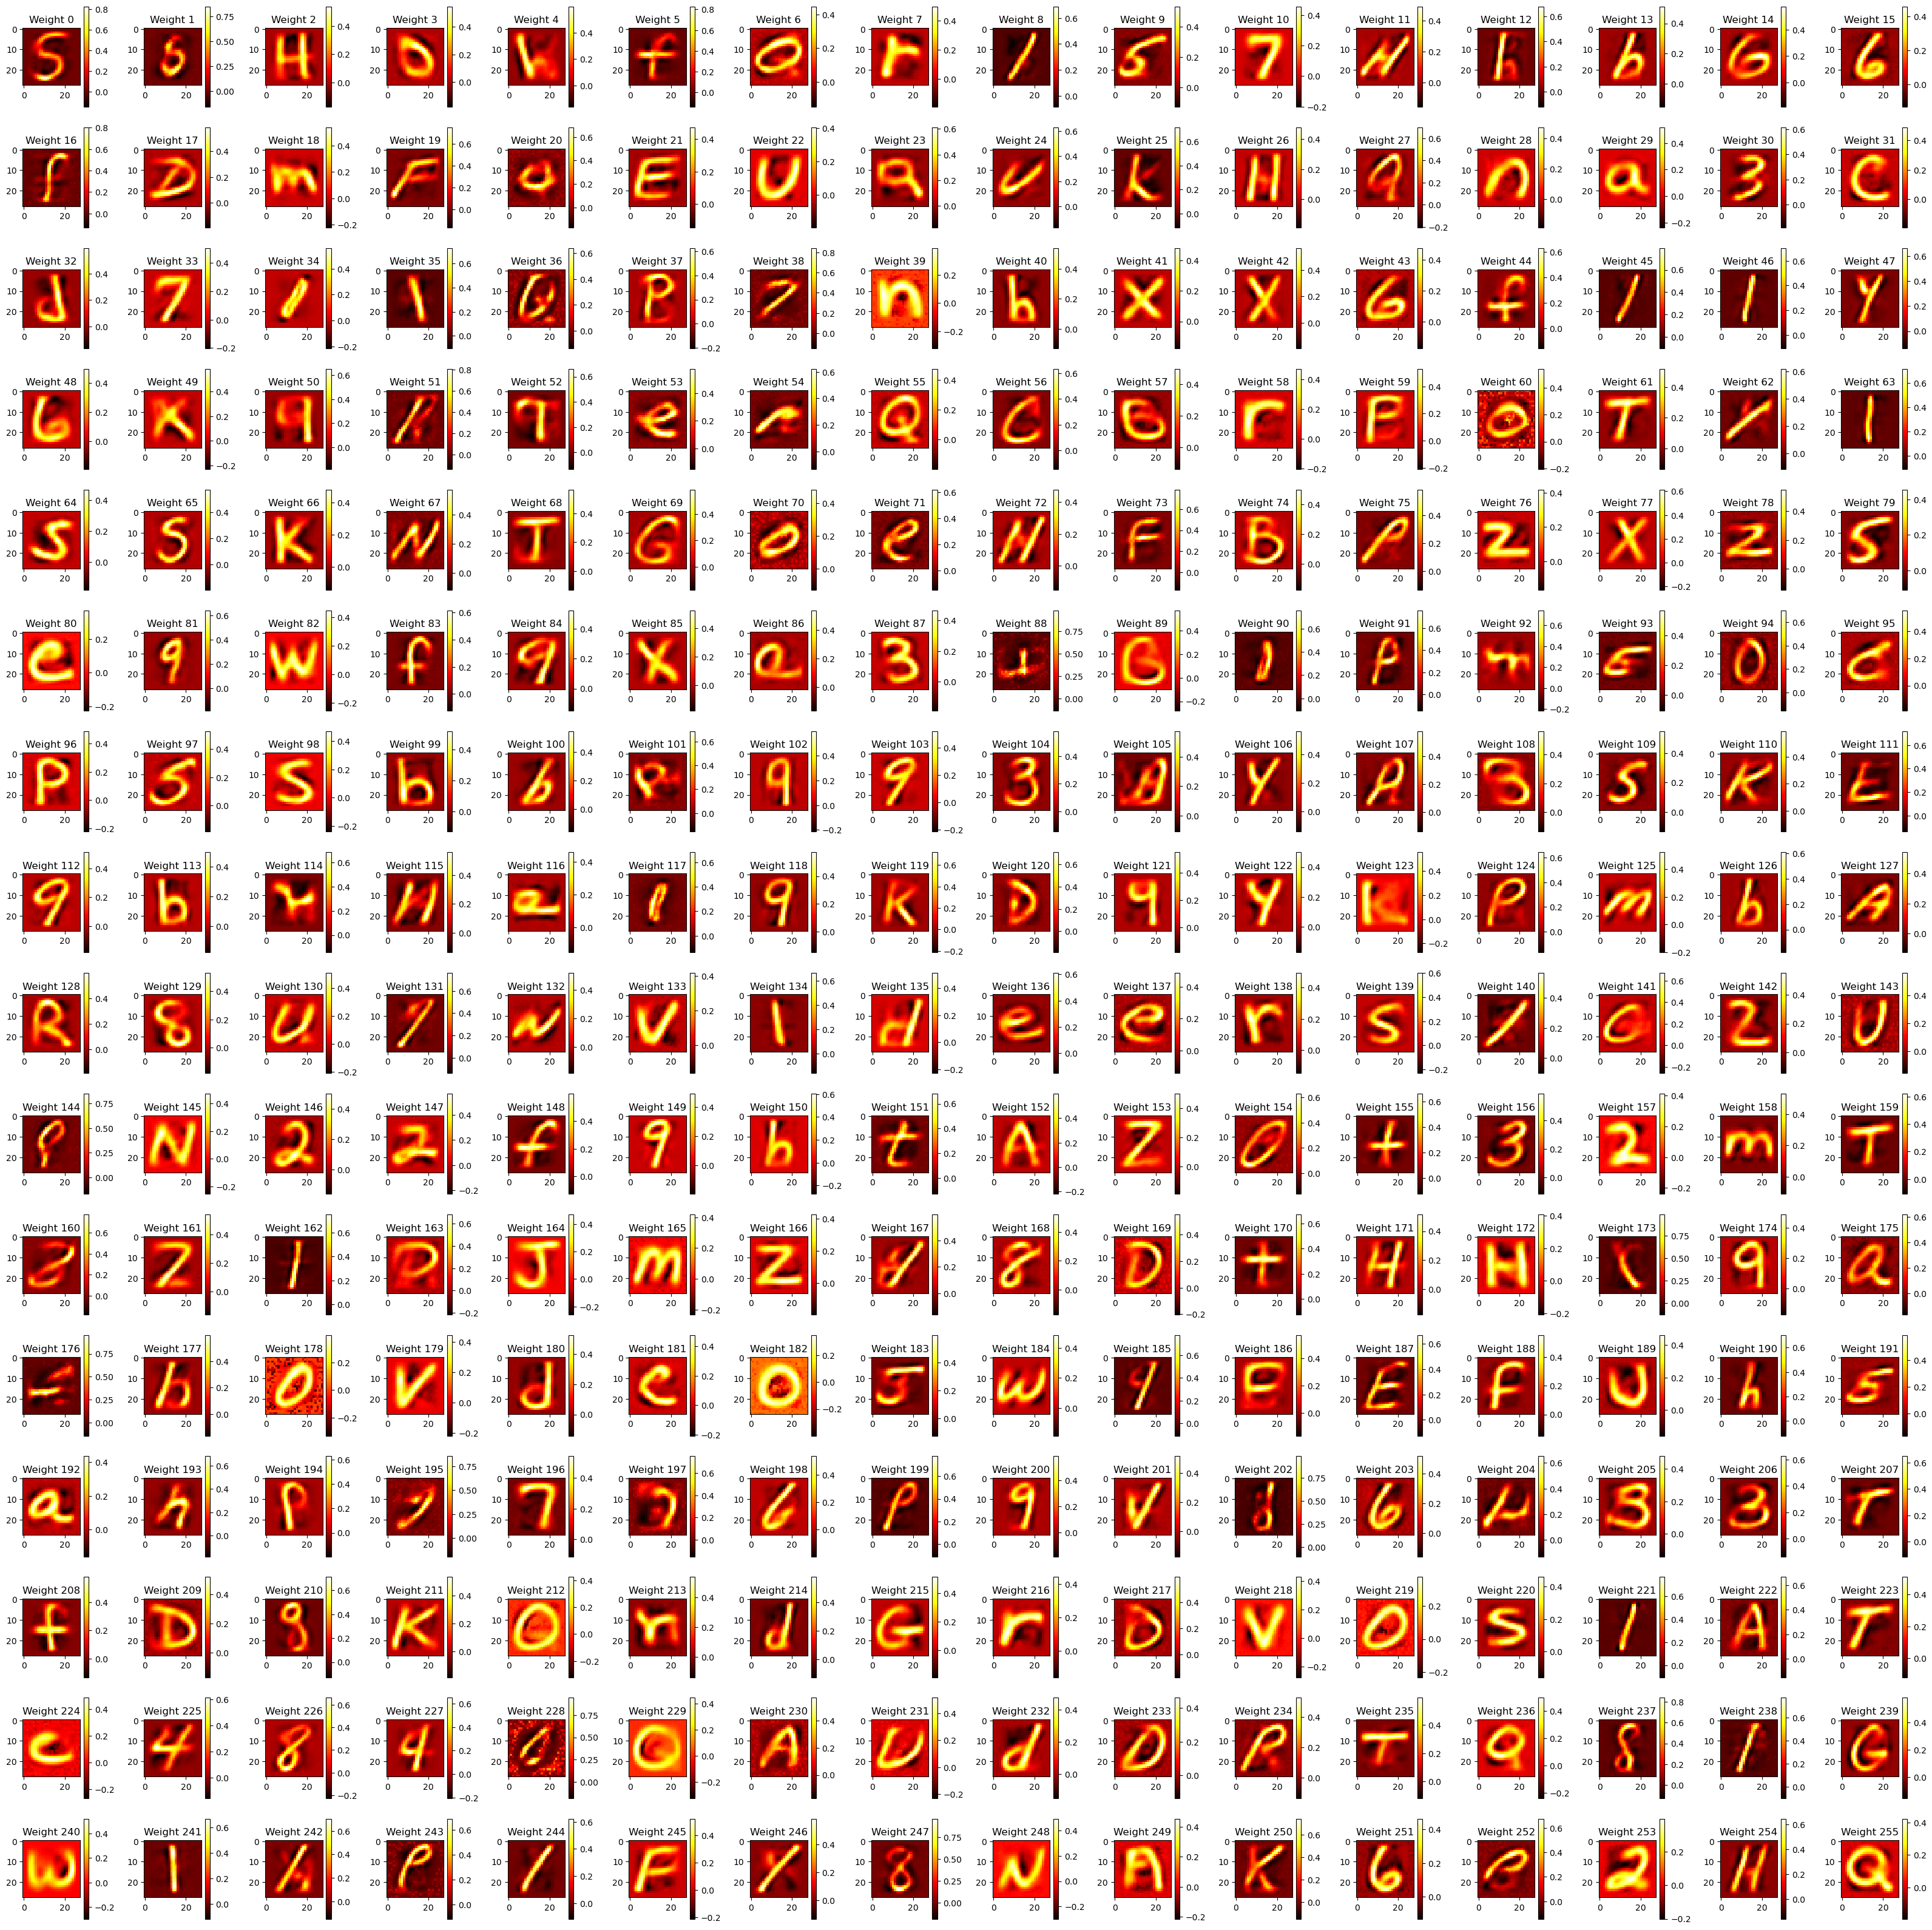

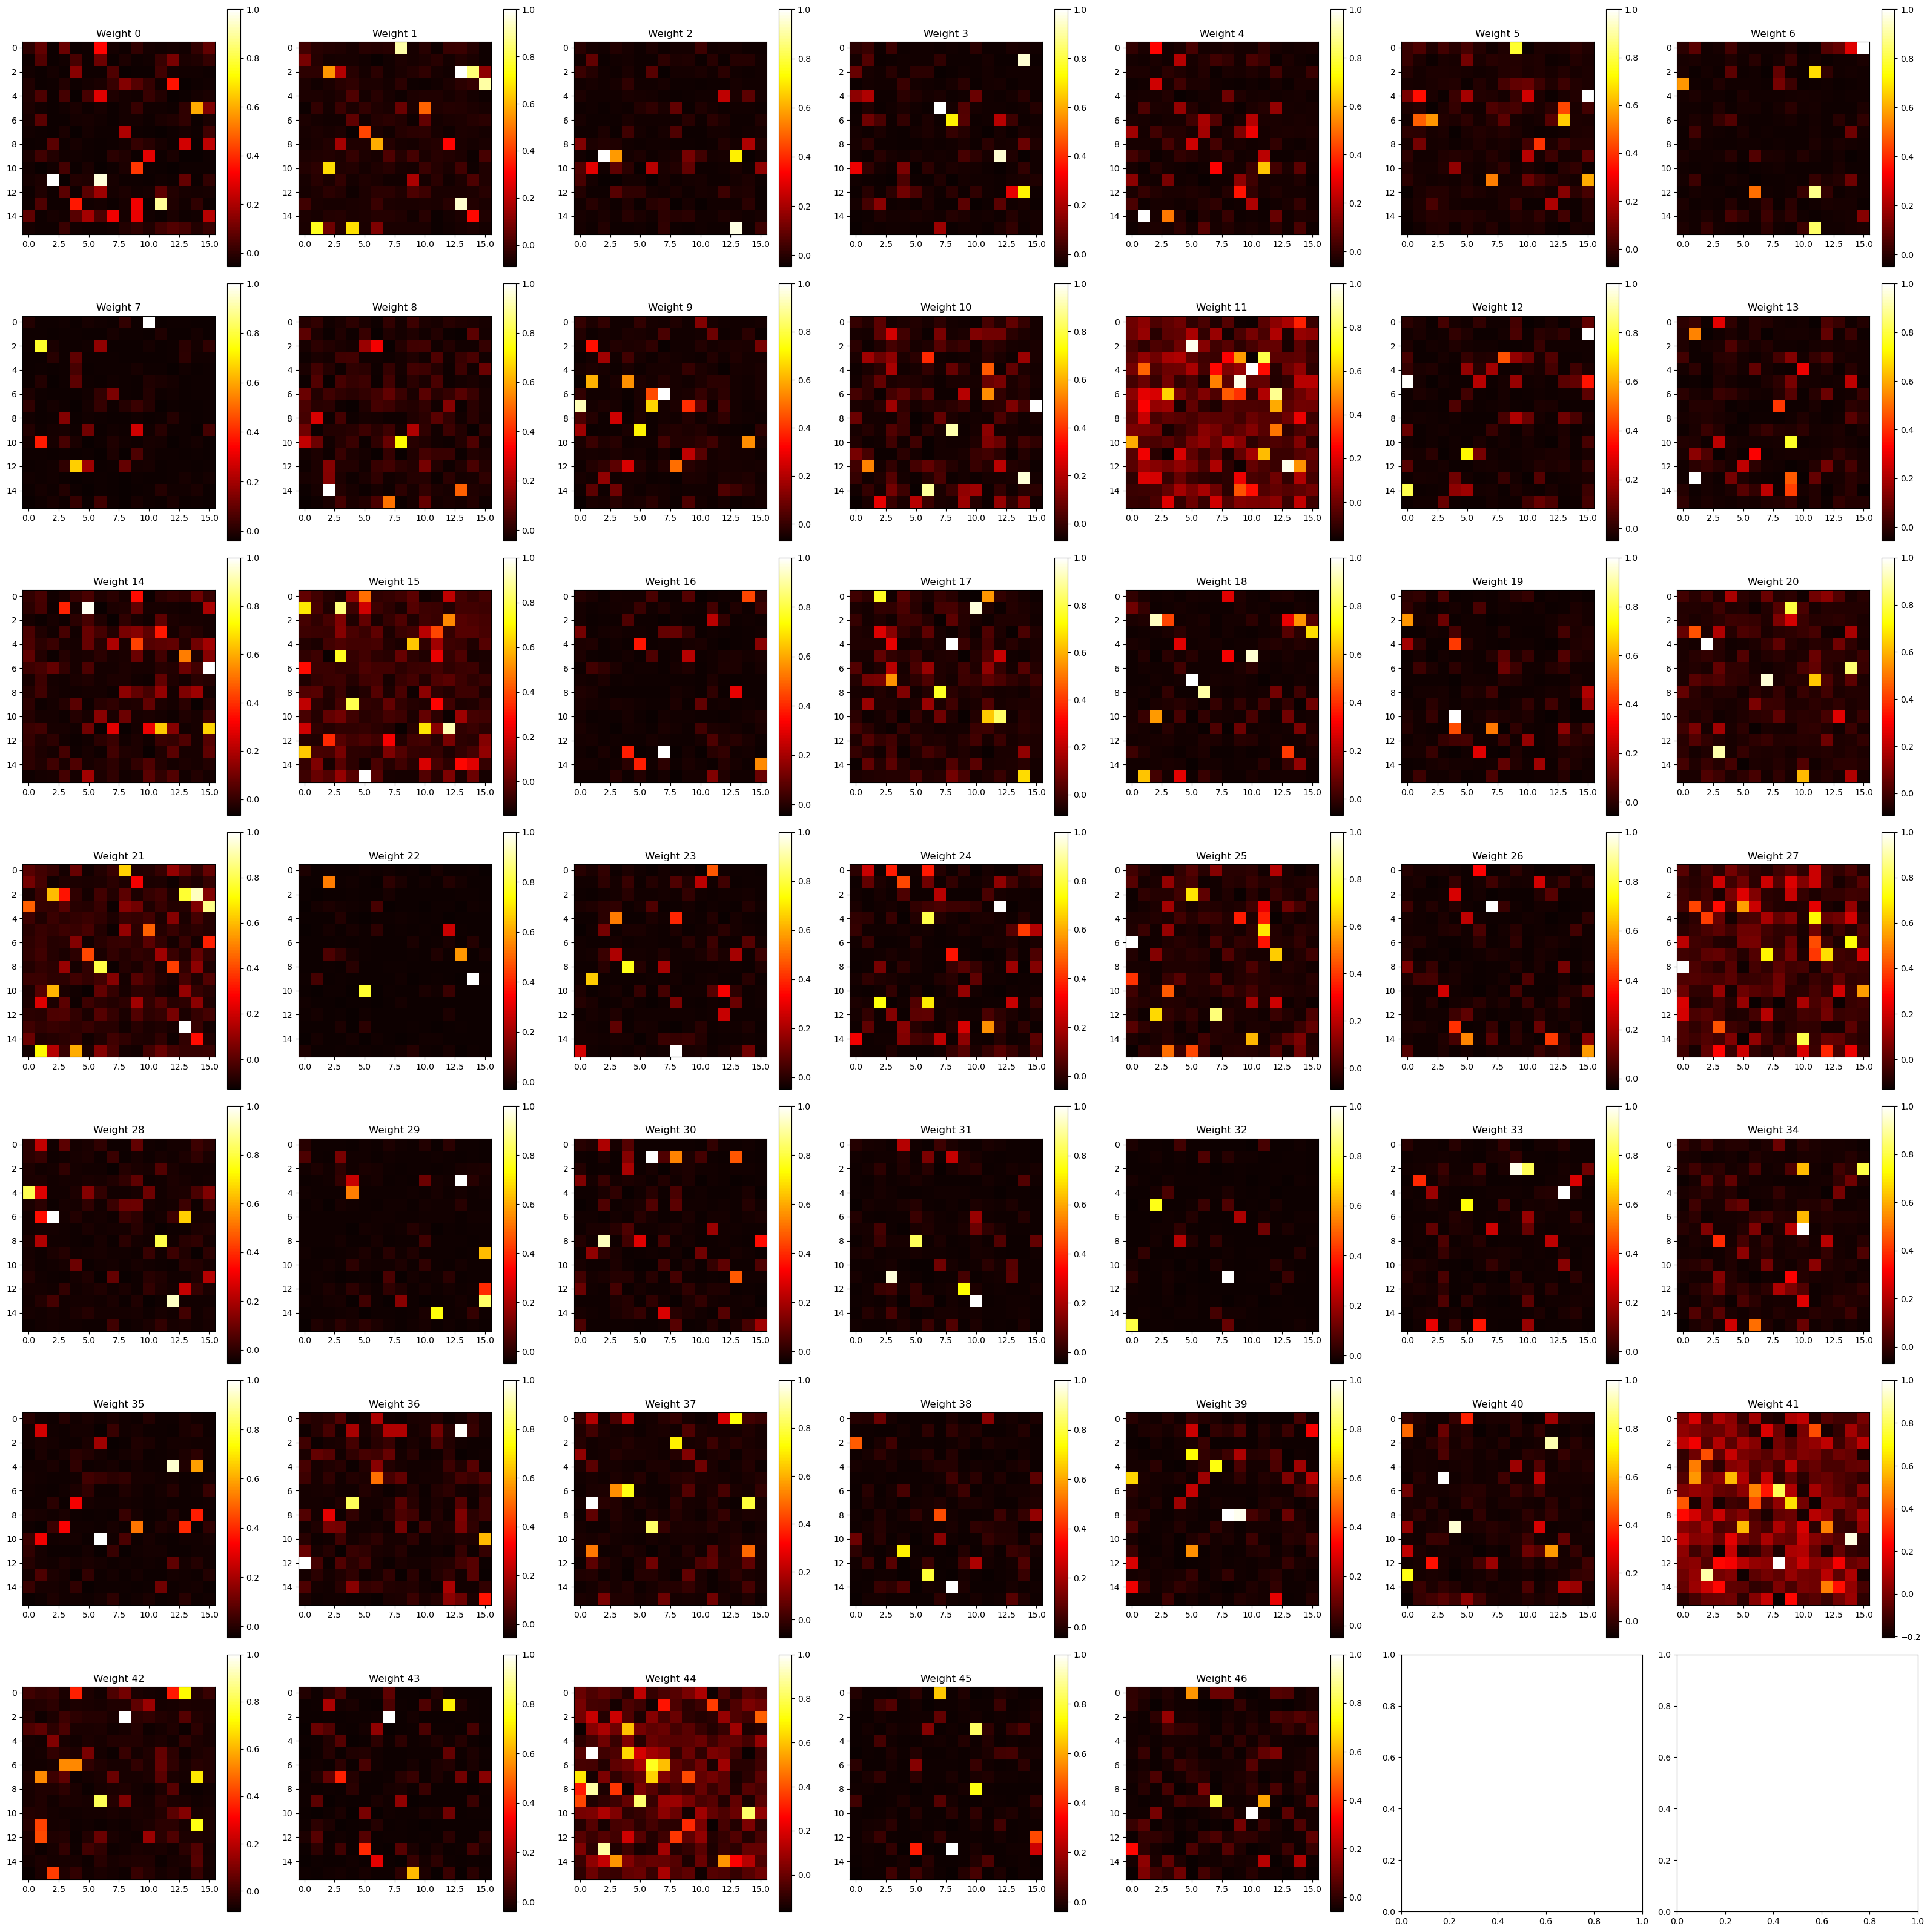

In [574]:
MLPBaseline_EMNIST_MP.visualize_weights()

In [595]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.534468085106383, {20: (228, 400), 13: (252, 400), 39: (277, 400), 5: (217, 400), 38: (296, 400), 32: (268, 400), 2: (233, 400), 19: (132, 400), 10: (253, 400), 45: (250, 400), 0: (242, 400), 1: (271, 400), 46: (182, 400), 15: (212, 400), 8: (121, 400), 14: (187, 400), 12: (178, 400), 17: (266, 400), 25: (274, 400), 27: (126, 400), 26: (136, 400), 30: (210, 400), 21: (74, 400), 37: (278, 400), 23: (232, 400), 24: (157, 400), 28: (224, 400), 42: (178, 400), 36: (251, 400), 9: (172, 400), 43: (268, 400), 3: (242, 400), 31: (302, 400), 40: (13, 400), 35: (306, 400), 4: (158, 400), 41: (88, 400), 44: (177, 400), 7: (297, 400), 29: (281, 400), 16: (252, 400), 11: (243, 400), 33: (240, 400), 22: (279, 400), 6: (285, 400), 18: (145, 400), 34: (95, 400)})


#### 64

In [735]:
MLPBaseline_EMNIST_MP = MLPBaseline_Experiment(3, 64, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_loader, 47)

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

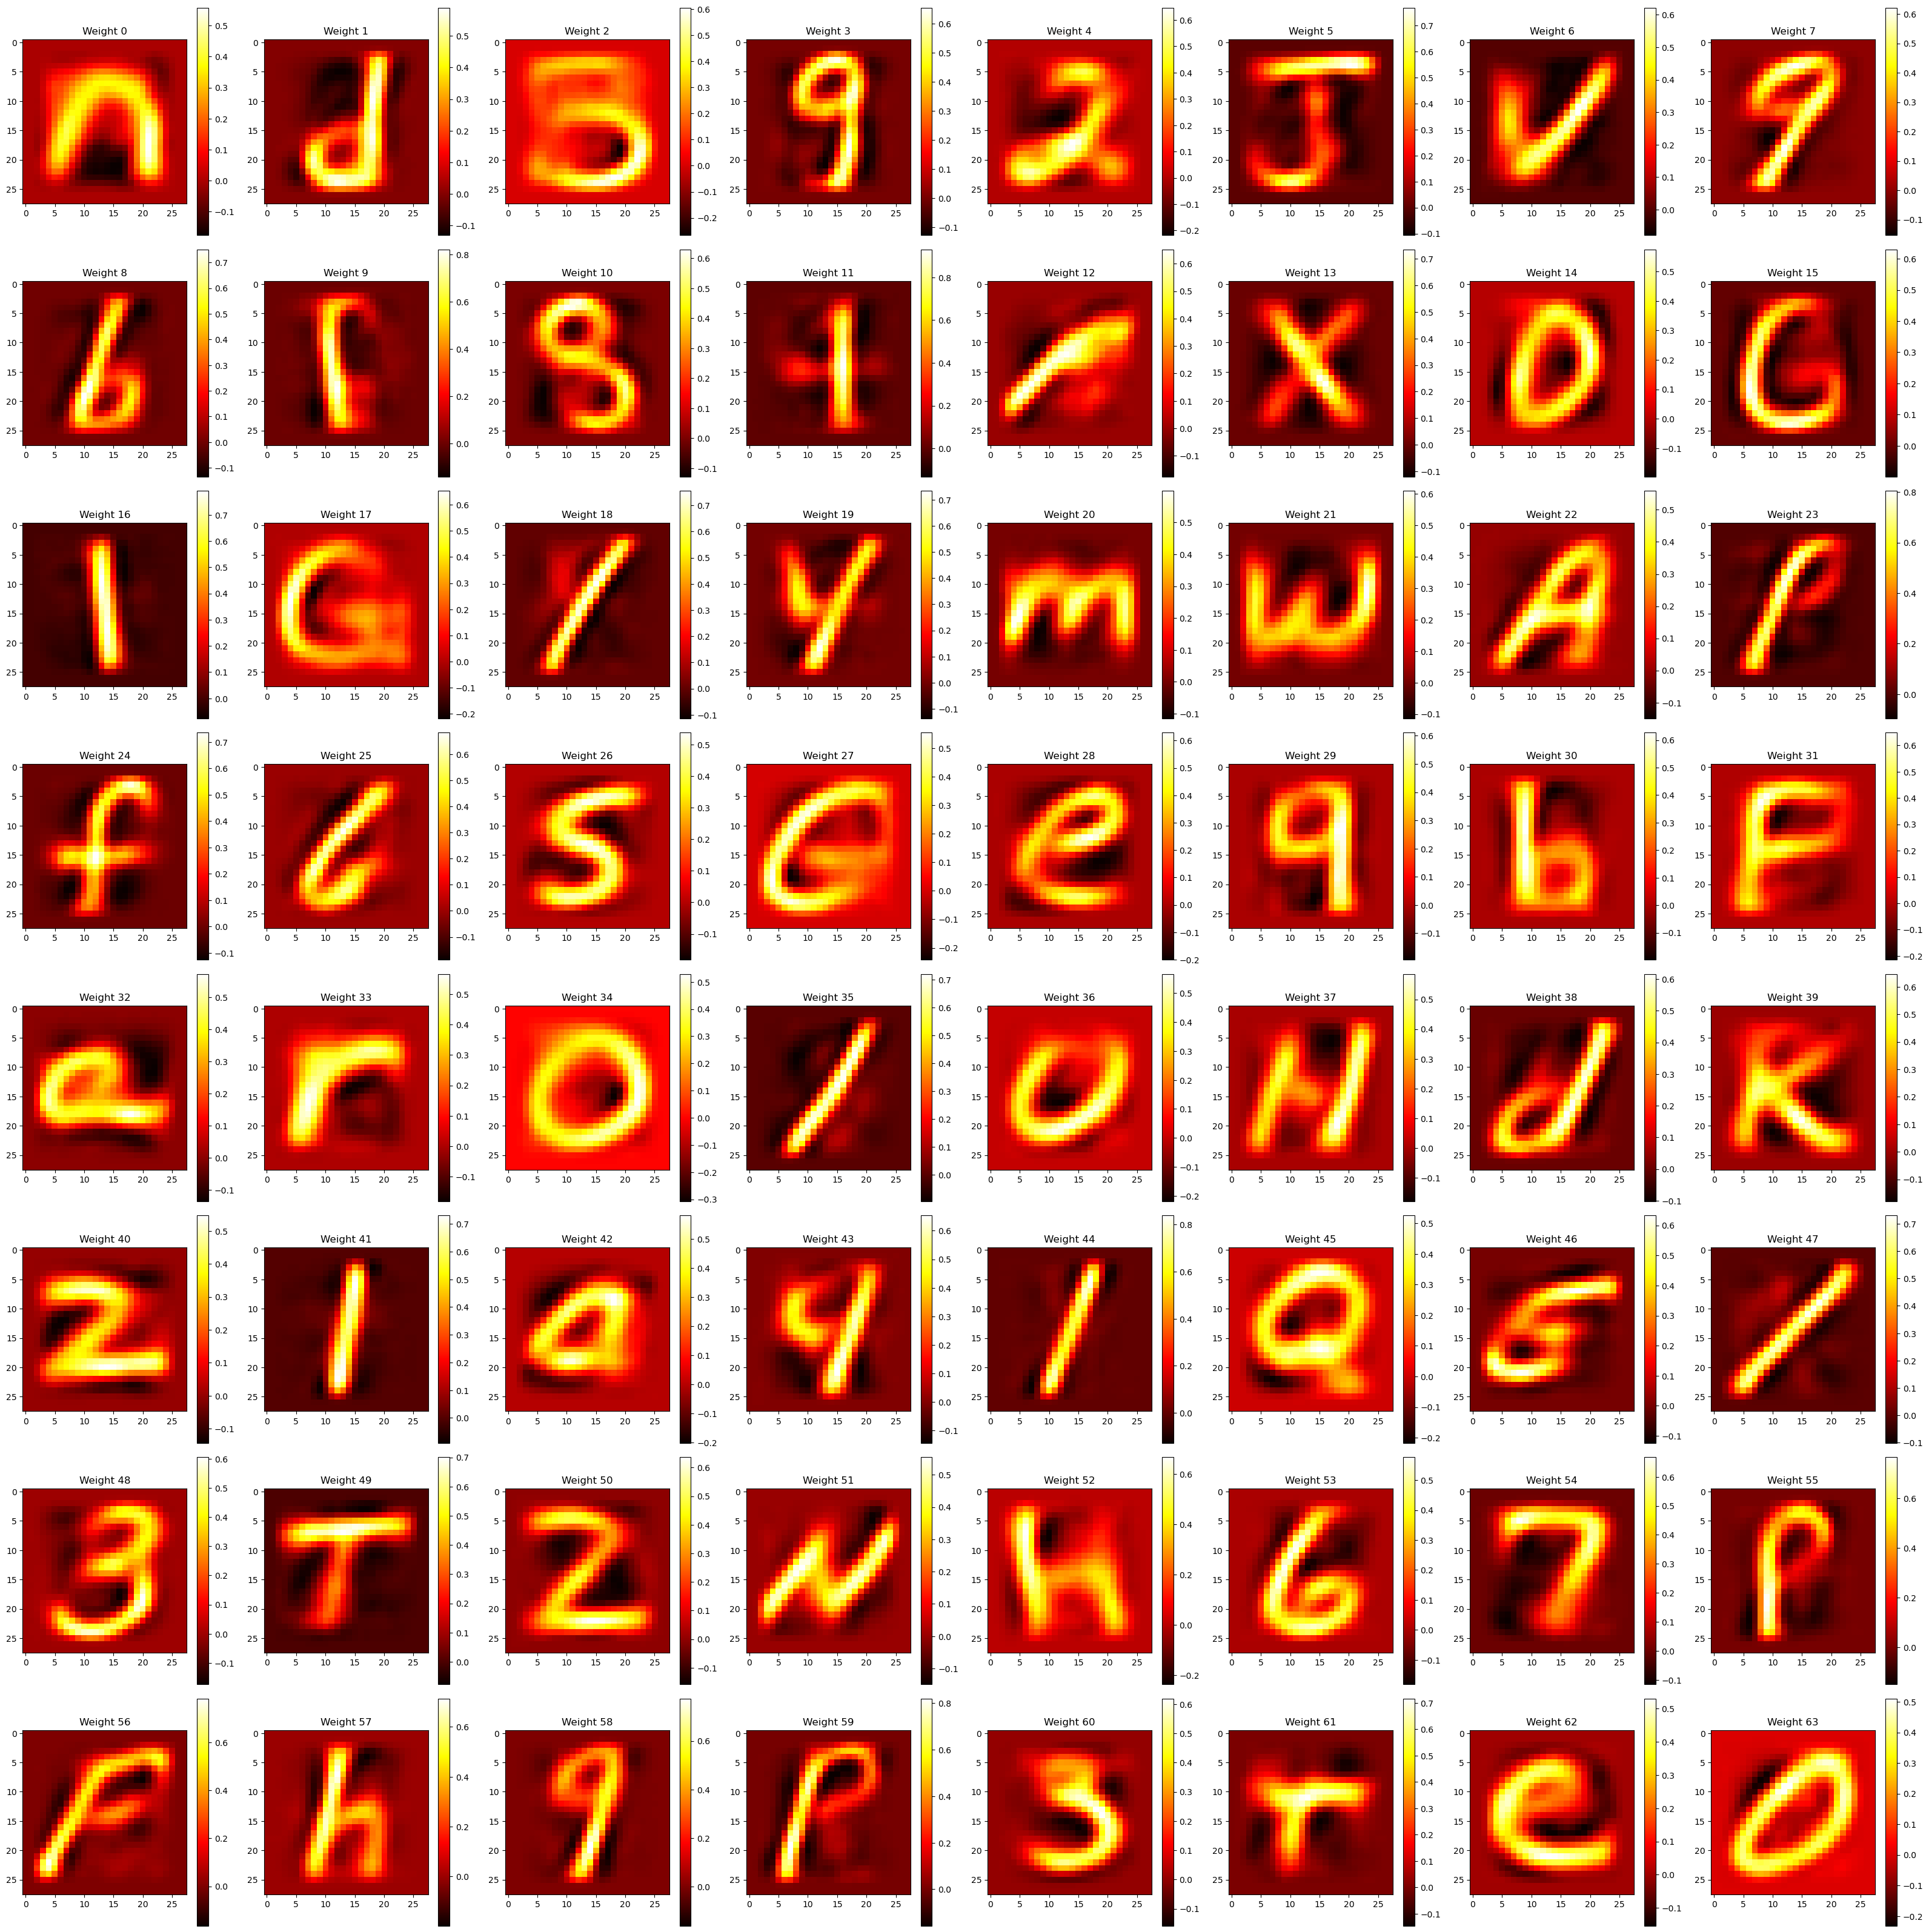

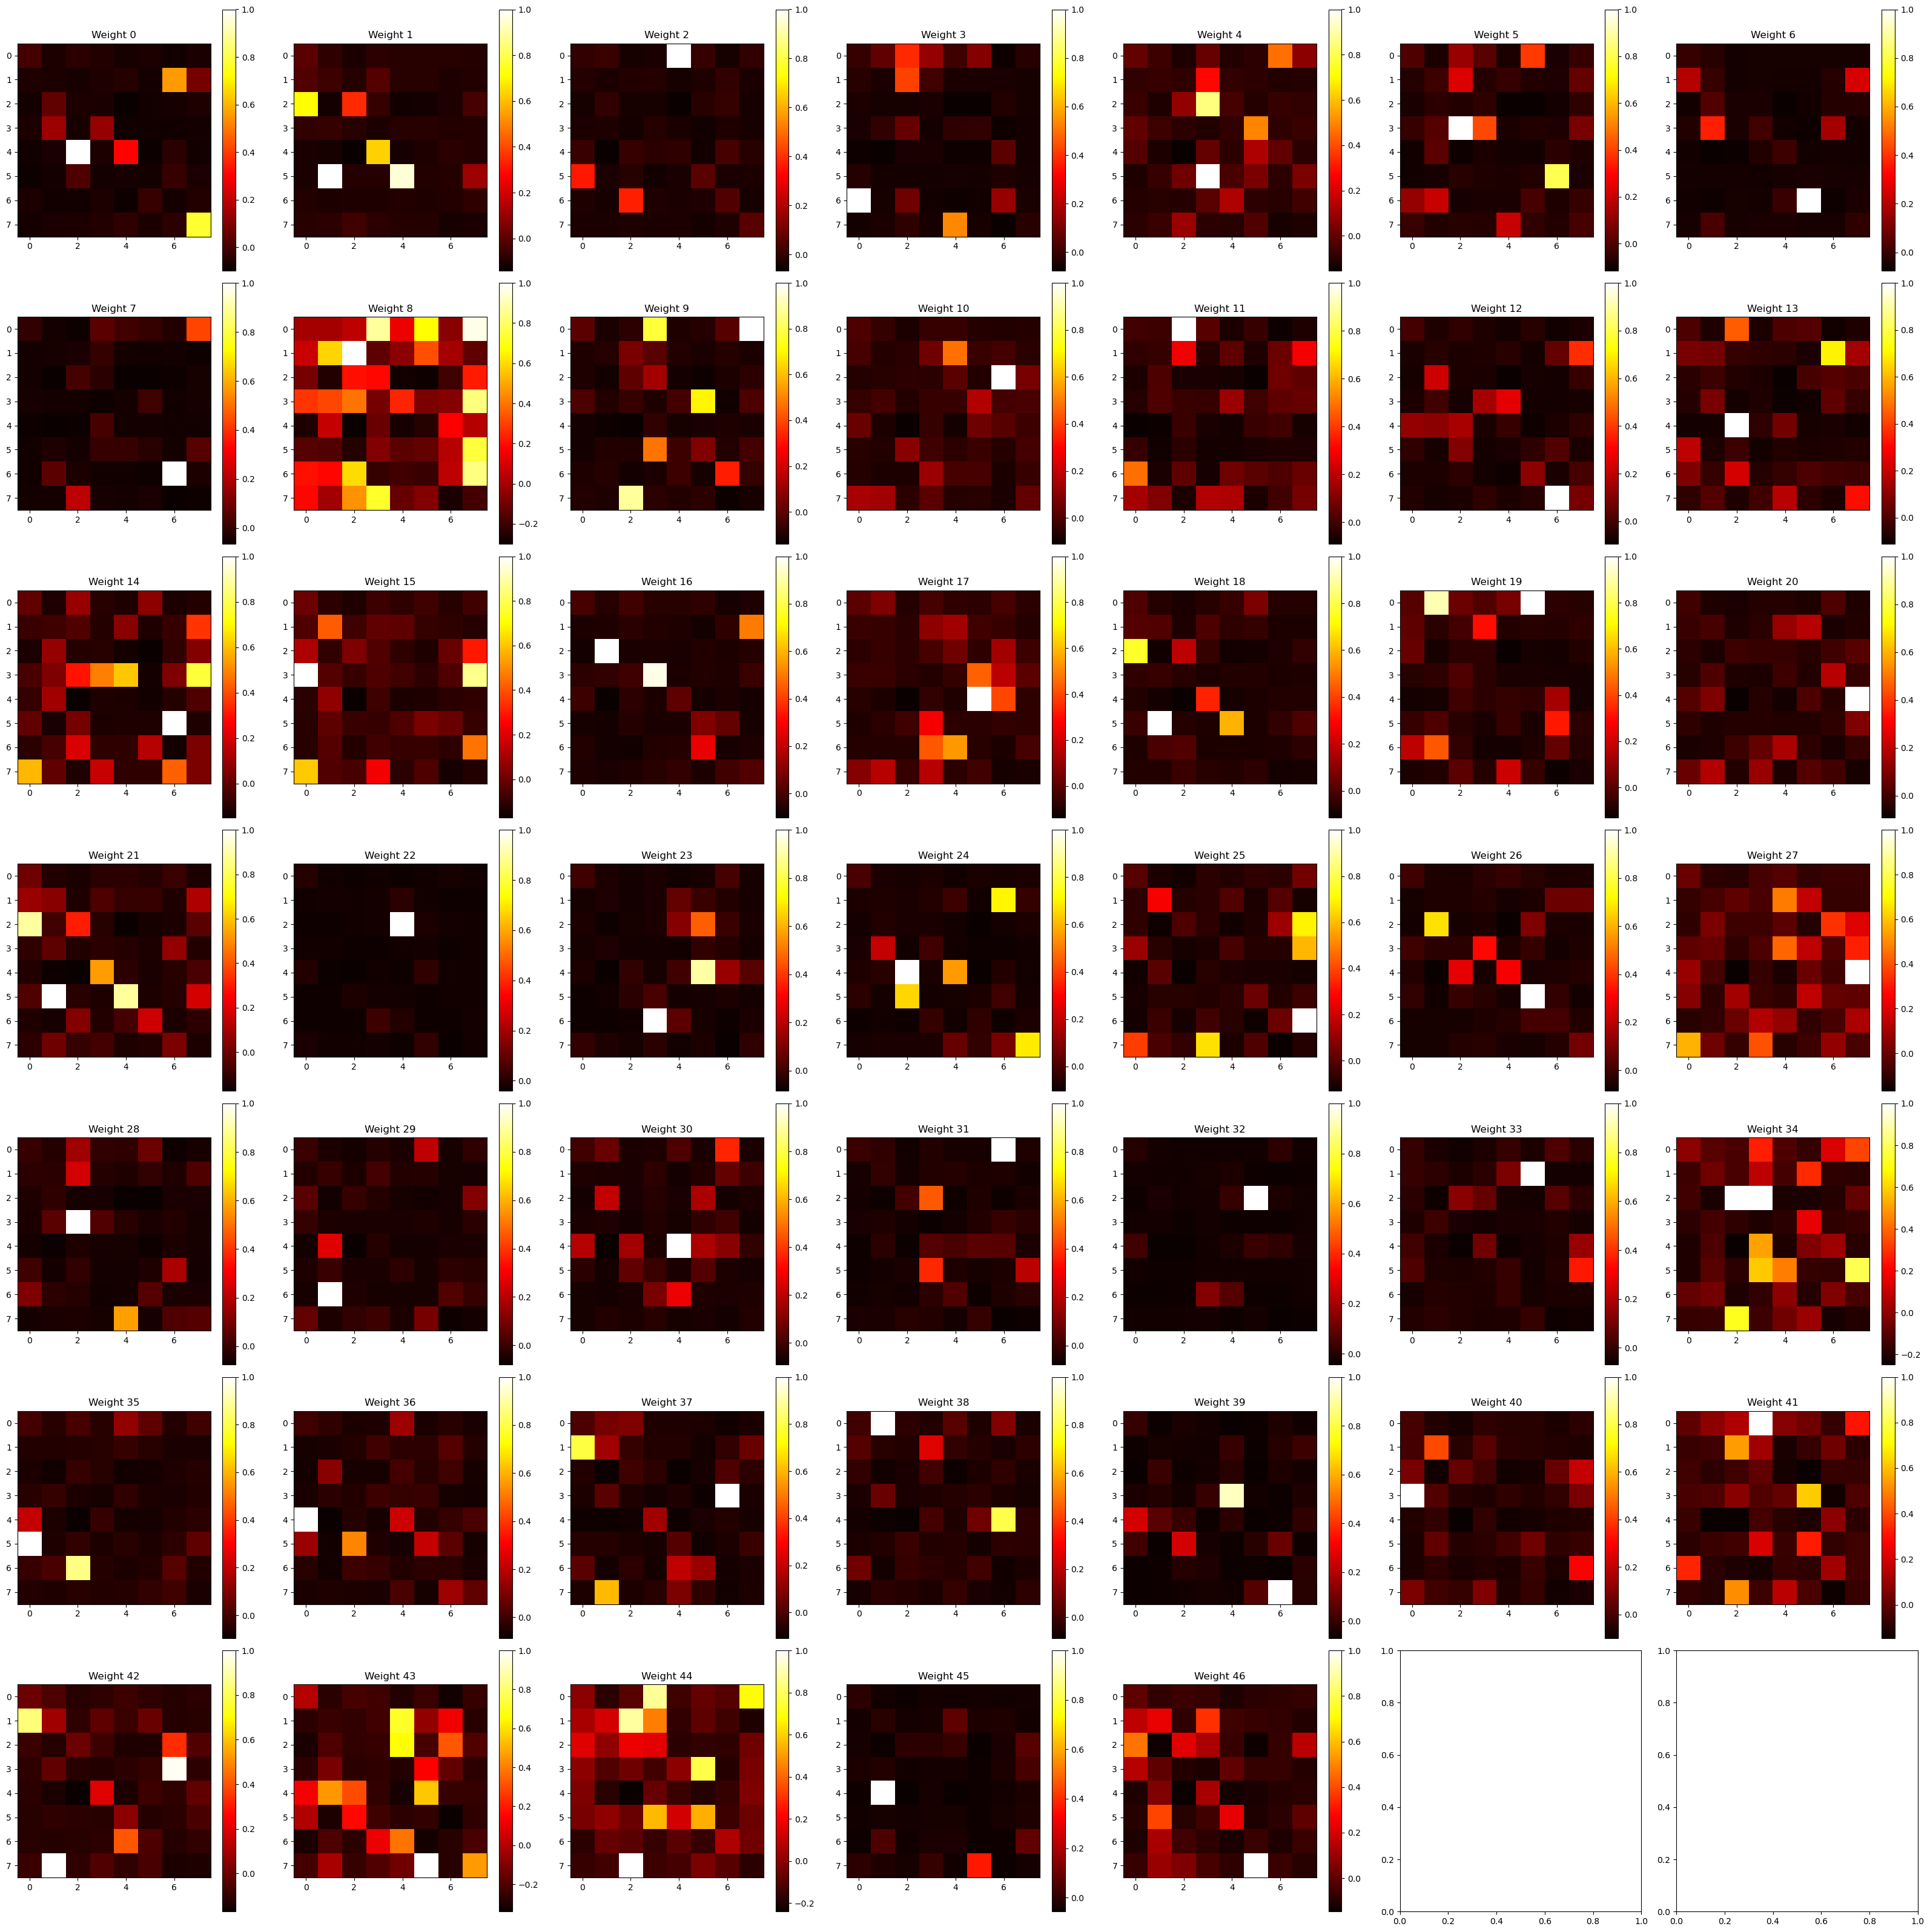

In [691]:
MLPBaseline_EMNIST_MP.visualize_weights()

In [692]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.38851063829787236, {13: (100, 400), 15: (131, 400), 22: (332, 400), 31: (139, 400), 46: (57, 400), 1: (156, 400), 42: (201, 400), 14: (195, 400), 26: (155, 400), 3: (195, 400), 8: (247, 400), 9: (72, 400), 17: (168, 400), 41: (62, 400), 45: (192, 400), 0: (142, 400), 38: (261, 400), 29: (144, 400), 7: (180, 400), 32: (314, 400), 23: (170, 400), 24: (221, 400), 25: (161, 400), 37: (91, 400), 39: (220, 400), 12: (90, 400), 35: (263, 400), 28: (131, 400), 18: (0, 400), 33: (160, 400), 30: (101, 400), 6: (233, 400), 11: (140, 400), 36: (147, 400), 20: (99, 400), 27: (104, 400), 10: (152, 400), 34: (177, 400), 2: (193, 400), 4: (87, 400), 19: (98, 400), 5: (88, 400), 21: (121, 400), 44: (133, 400), 16: (280, 400), 40: (69, 400), 43: (132, 400)})


In [740]:
MLP3Layer_emnist = MLP3Layer_Experiment(3, 64, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_loader, 47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [719]:
print(MLPBaseline_test_accuracy(MLP3Layer_emnist, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3395744680851064, {5: (117, 400), 35: (156, 400), 18: (0, 400), 1: (107, 400), 28: (148, 400), 7: (85, 400), 22: (285, 400), 25: (199, 400), 38: (152, 400), 37: (88, 400), 24: (124, 400), 31: (165, 400), 43: (202, 400), 19: (117, 400), 27: (93, 400), 29: (152, 400), 2: (156, 400), 40: (10, 400), 8: (35, 400), 30: (114, 400), 32: (291, 400), 42: (180, 400), 26: (37, 400), 44: (35, 400), 13: (75, 400), 41: (73, 400), 33: (187, 400), 0: (110, 400), 45: (184, 400), 11: (144, 400), 20: (119, 400), 17: (207, 400), 14: (145, 400), 23: (141, 400), 39: (117, 400), 3: (176, 400), 46: (126, 400), 34: (143, 400), 21: (159, 400), 9: (178, 400), 12: (105, 400), 15: (64, 400), 6: (288, 400), 10: (116, 400), 16: (232, 400), 36: (182, 400), 4: (65, 400)})


### Gaussian Noise

In [693]:
gaussian_mlp_mp = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_dataloader_gaussian[idx])
    gaussian_mlp_mp.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

### Speckle Noise

In [694]:
speckle_mlp_mp = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_dataloader_speckle[idx])
    speckle_mlp_mp.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

### Occlusion Noise

In [696]:
occlusion_mlp_mp = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_dataloader_occlusion[idx])
    occlusion_mlp_mp.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

### Average Blur

In [697]:
averageblur_mlp_mp = []
for idx in range(5):
    d = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_dataloader_averageblur[idx])
    averageblur_mlp_mp.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

### EMNIST Sanger

In [736]:
MLPBaseline_EMNIST_sanger = MLPBaseline_Experiment(epoch=3, hsize=64, lamb=15, lr=0.005, learning=Learning.Sanger, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [606]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_other, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.340531914893617, {29: (137, 400), 35: (130, 400), 46: (147, 400), 40: (165, 400), 42: (42, 400), 43: (248, 400), 5: (170, 400), 13: (170, 400), 11: (99, 400), 17: (182, 400), 27: (44, 400), 25: (129, 400), 23: (101, 400), 14: (115, 400), 28: (104, 400), 34: (66, 400), 15: (110, 400), 7: (161, 400), 16: (179, 400), 38: (168, 400), 41: (100, 400), 31: (78, 400), 36: (172, 400), 45: (208, 400), 1: (78, 400), 18: (131, 400), 32: (296, 400), 10: (173, 400), 2: (181, 400), 44: (66, 400), 9: (35, 400), 3: (122, 400), 33: (166, 400), 0: (107, 400), 21: (118, 400), 8: (155, 400), 19: (120, 400), 37: (209, 400), 24: (86, 400), 6: (164, 400), 12: (73, 400), 20: (104, 400), 26: (139, 400), 30: (149, 400), 39: (113, 400), 4: (108, 400), 22: (284, 400)})


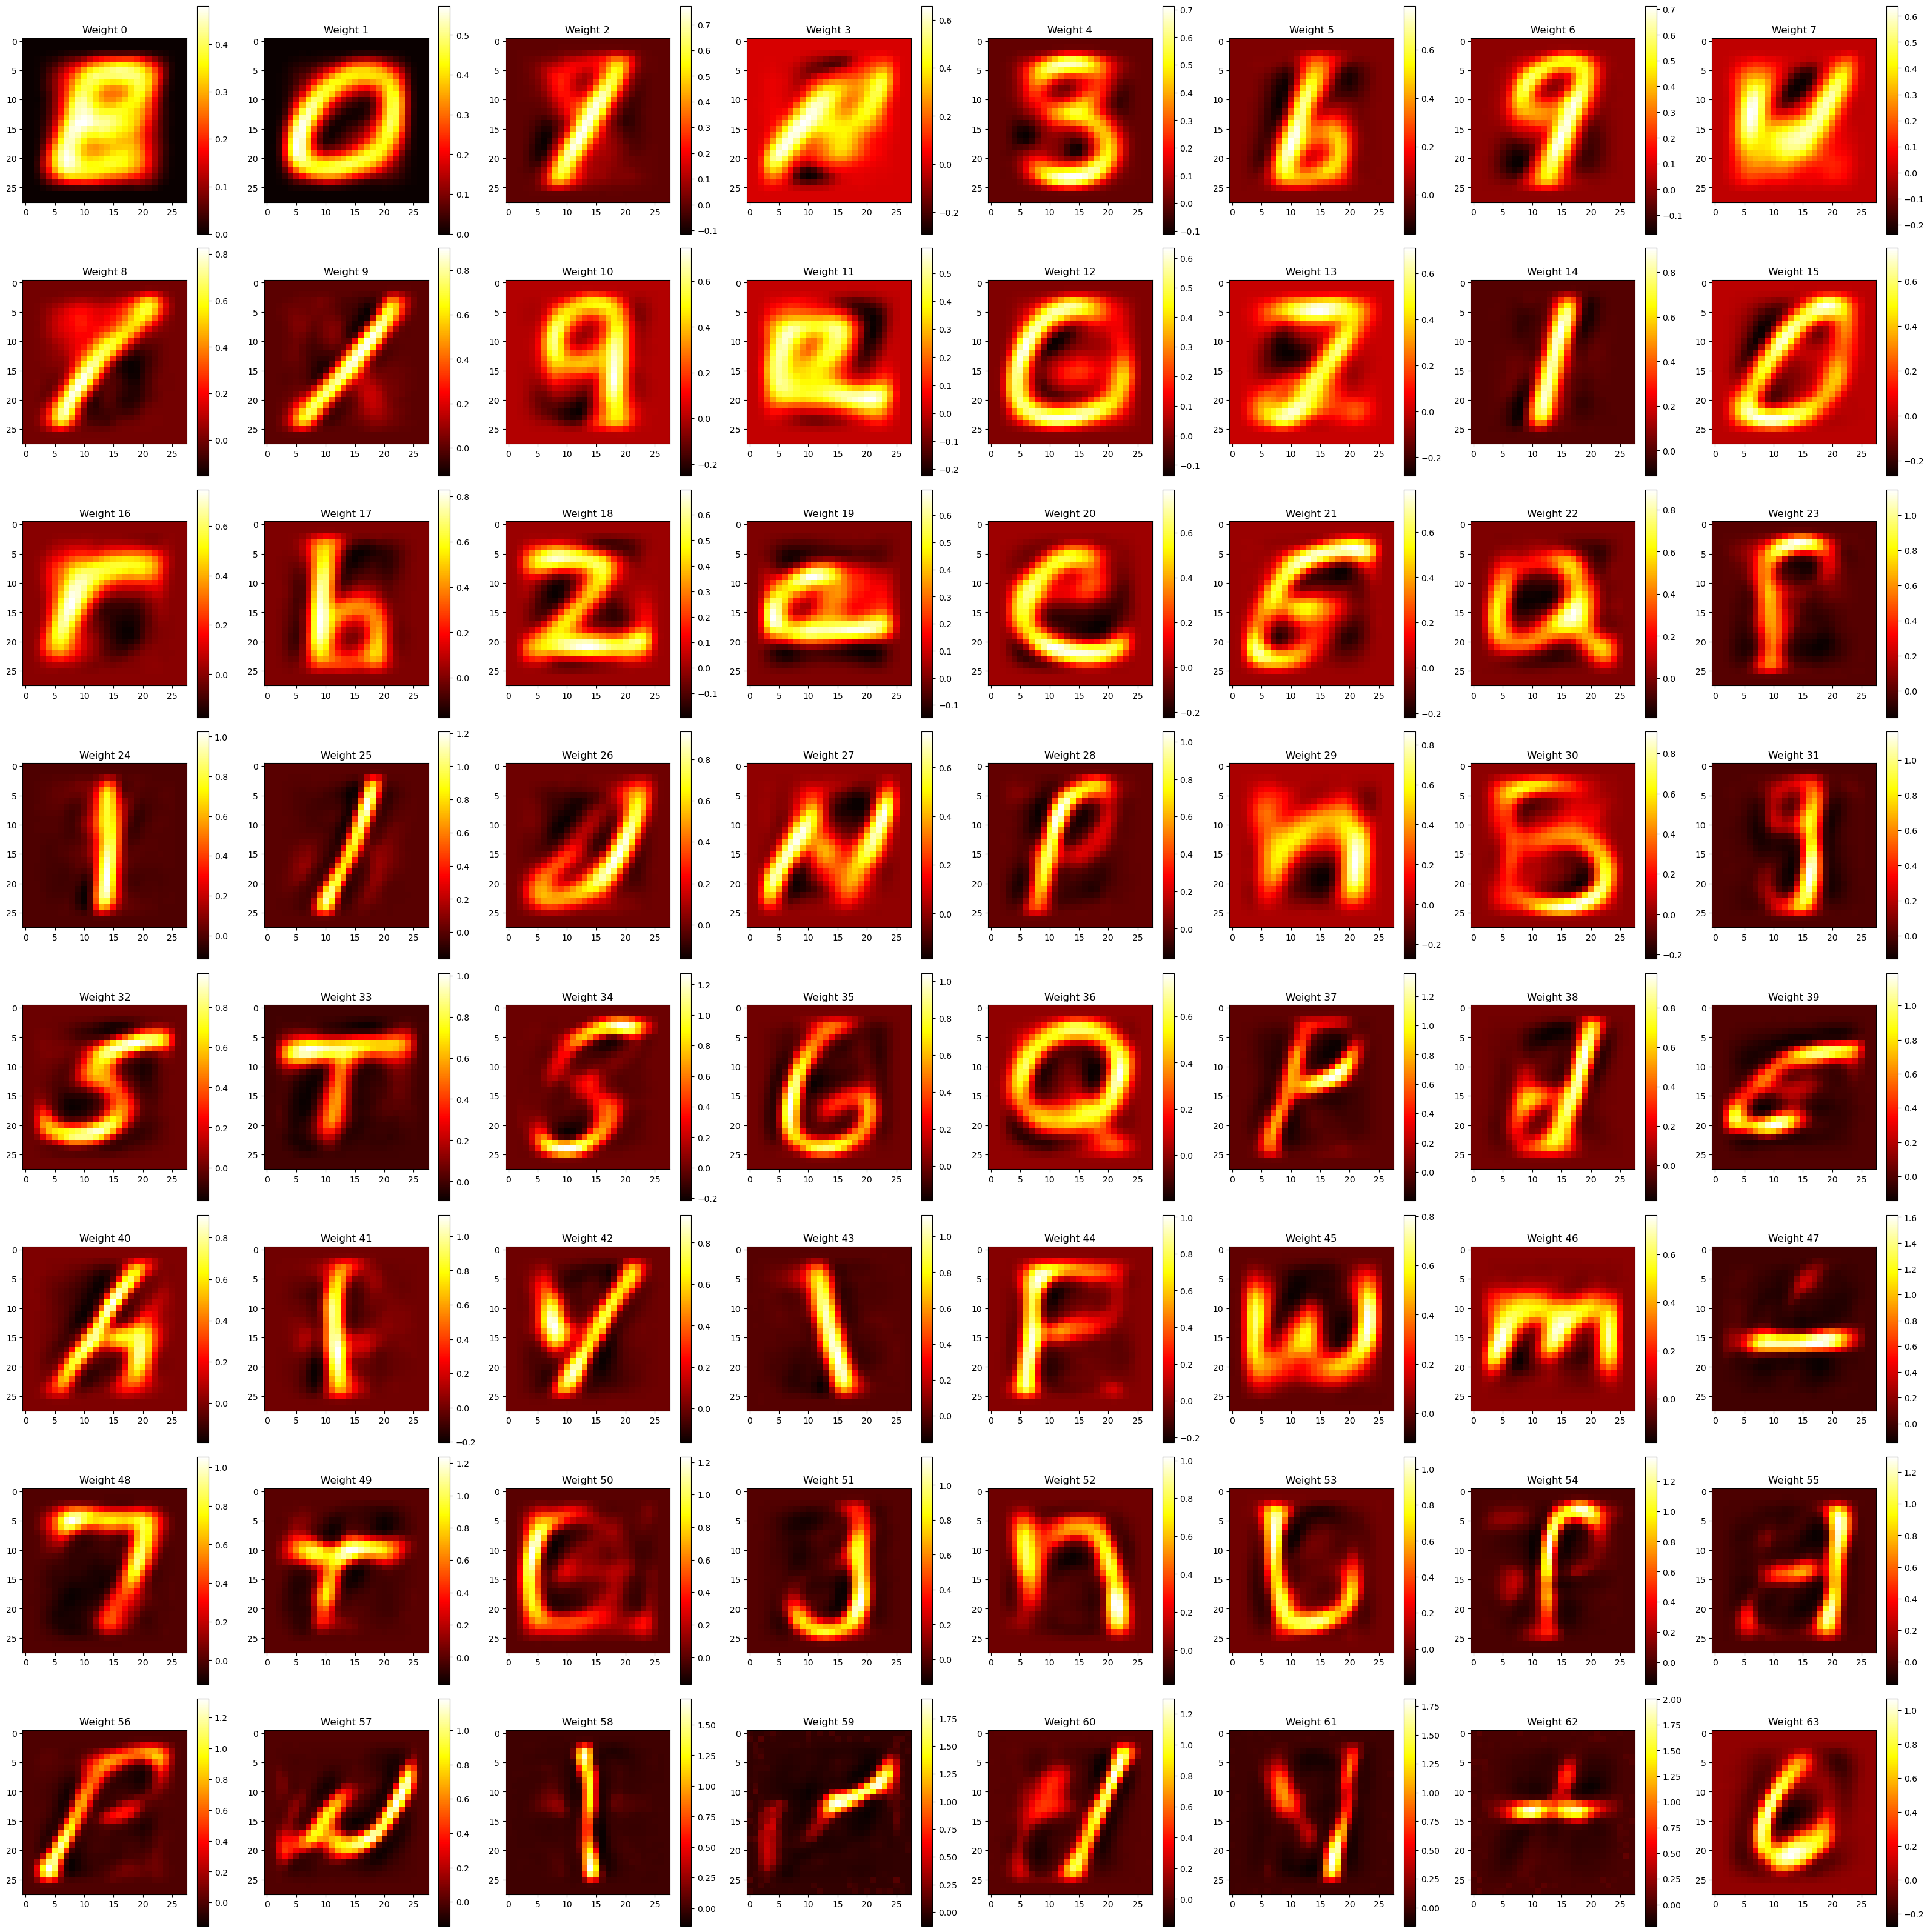

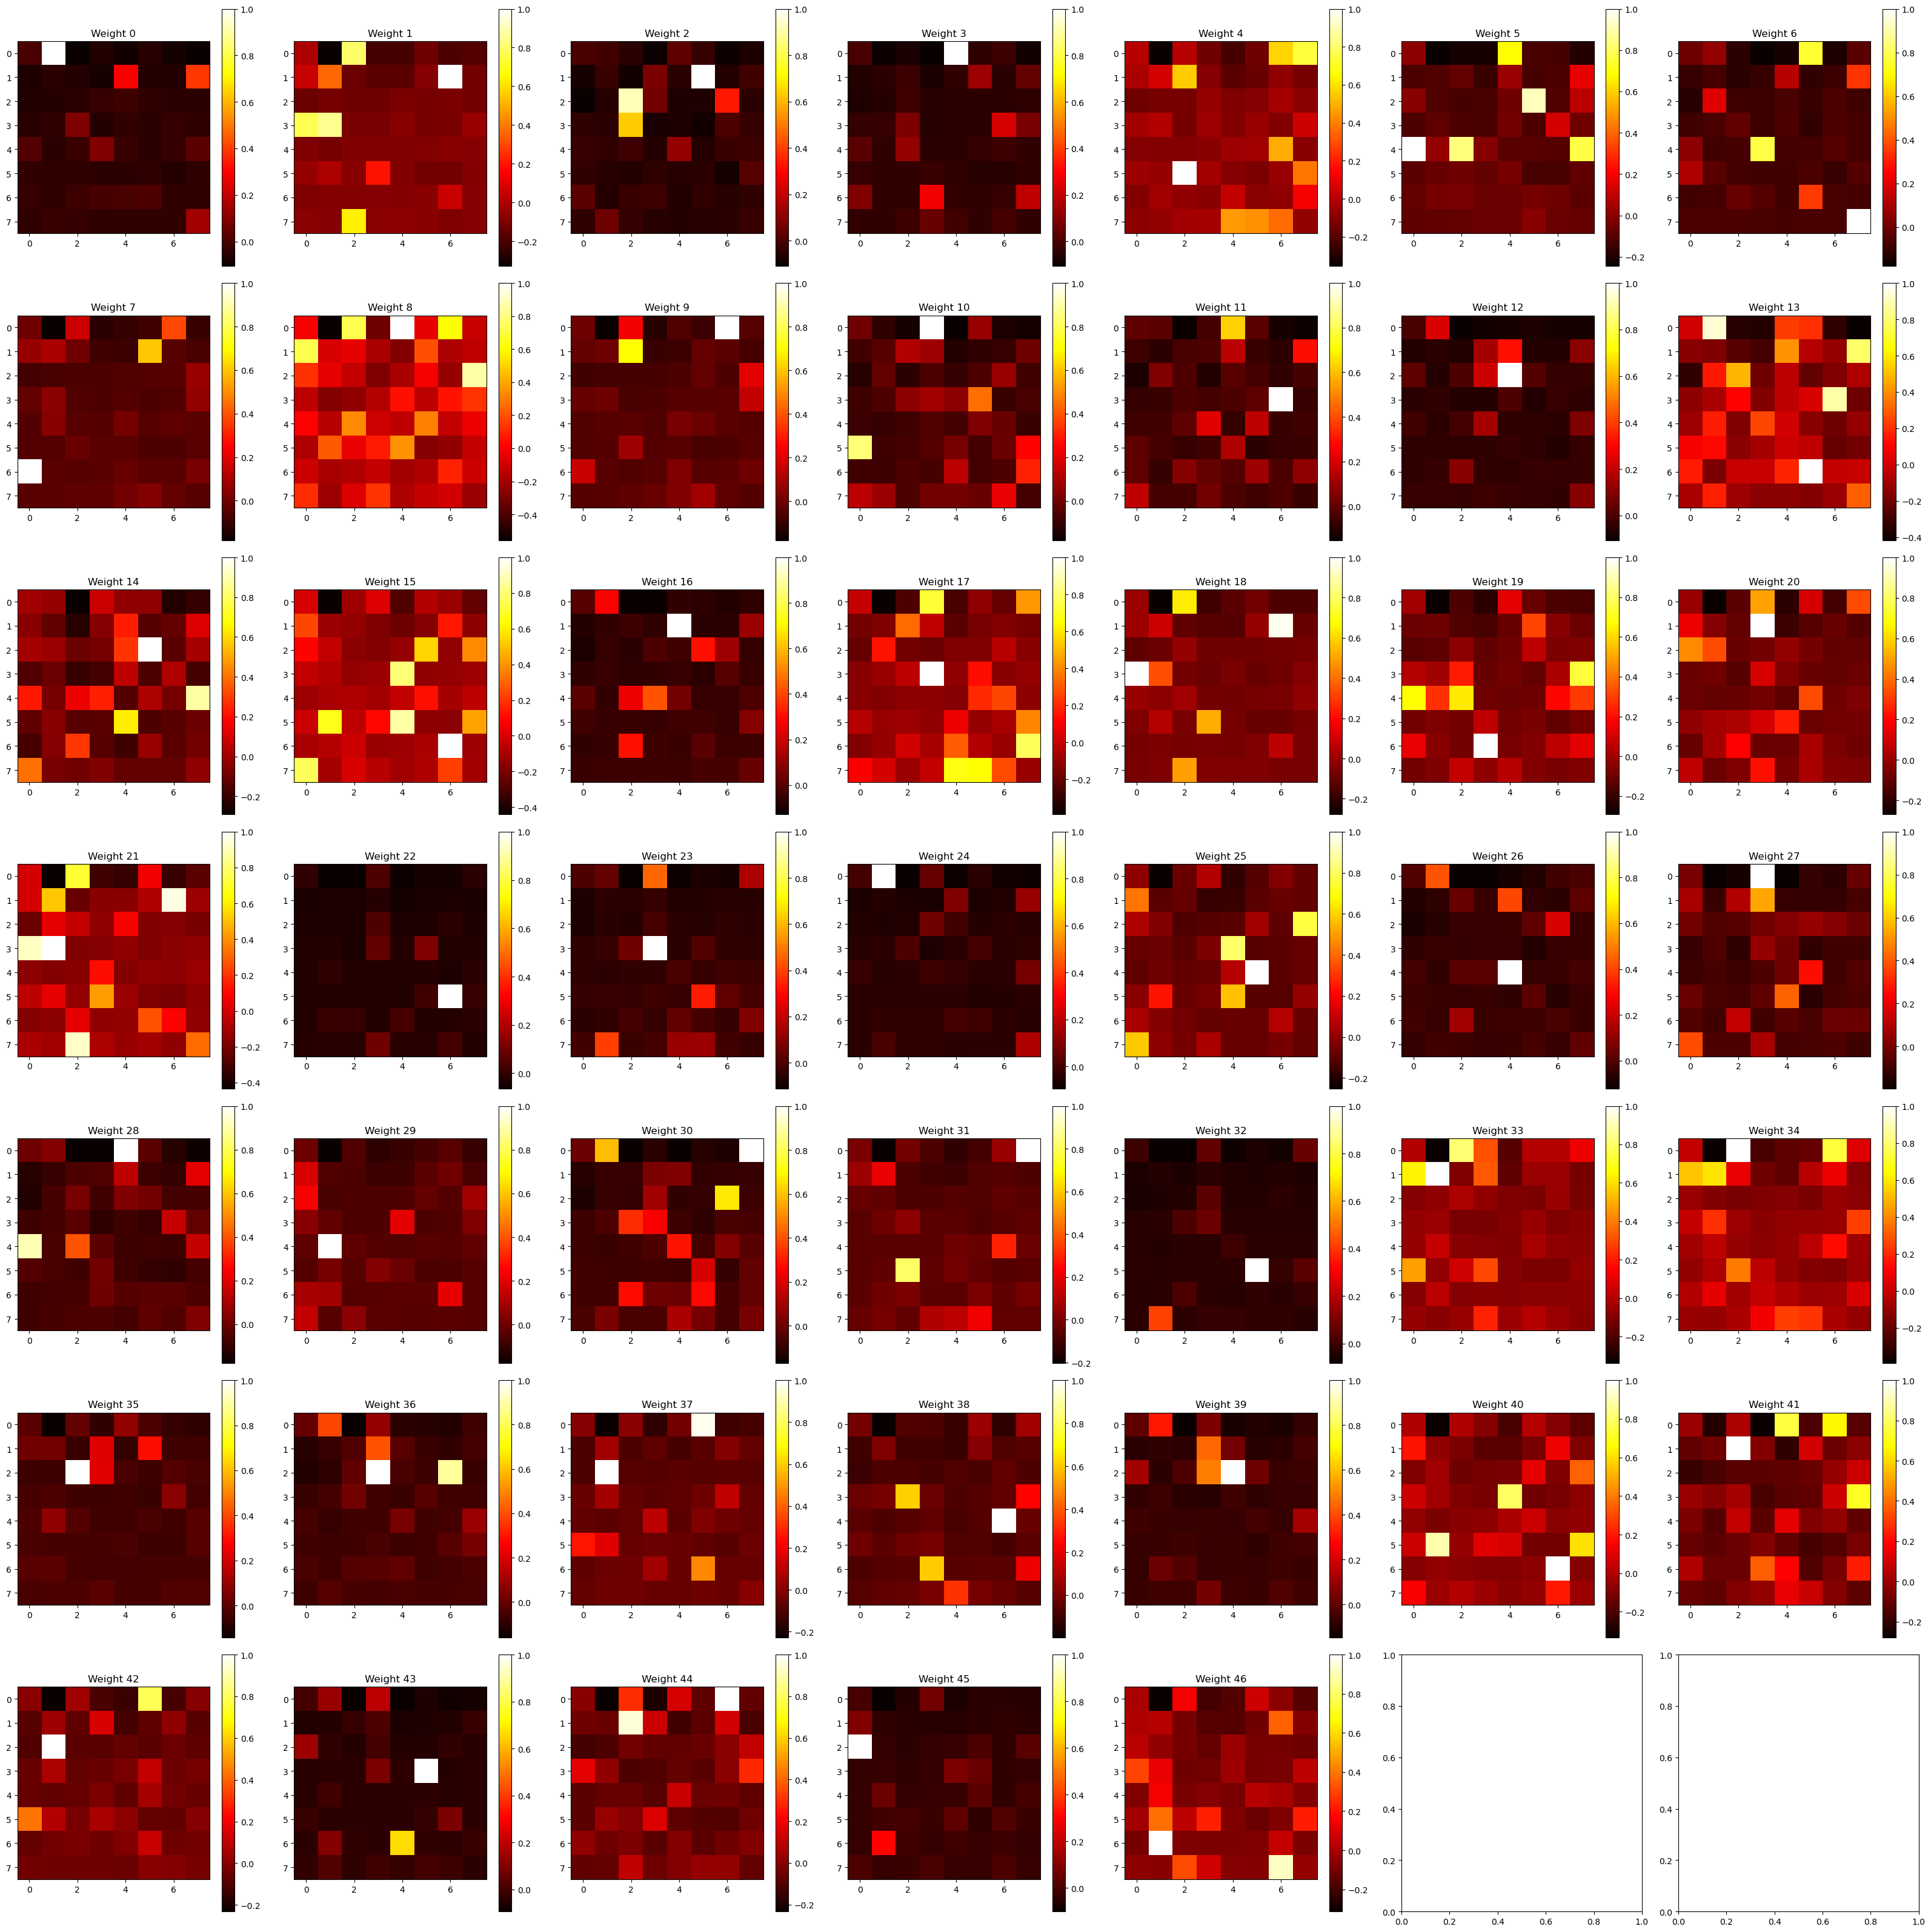

In [607]:
MLPBaseline_EMNIST_other.visualize_weights()

In [608]:
MLPBaseline_EMNIST_other = MLPBaseline_Experiment(epoch=3, hsize=256, lamb=15, lr=0.005, learning=Learning.Sanger, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [610]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_other, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.34037234042553194, {10: (130, 400), 45: (147, 400), 7: (154, 400), 24: (40, 400), 28: (150, 400), 4: (119, 400), 38: (154, 400), 27: (118, 400), 2: (91, 400), 40: (18, 400), 43: (142, 400), 6: (220, 400), 34: (155, 400), 12: (173, 400), 16: (159, 400), 31: (106, 400), 14: (107, 400), 5: (133, 400), 42: (133, 400), 39: (166, 400), 33: (217, 400), 11: (108, 400), 19: (159, 400), 36: (202, 400), 8: (116, 400), 20: (189, 400), 15: (159, 400), 30: (133, 400), 0: (10, 400), 46: (156, 400), 25: (149, 400), 17: (199, 400), 13: (183, 400), 32: (197, 400), 21: (57, 400), 3: (14, 400), 44: (80, 400), 18: (173, 400), 35: (227, 400), 23: (135, 400), 41: (143, 400), 37: (36, 400), 22: (190, 400), 26: (230, 400), 9: (77, 400), 29: (189, 400), 1: (56, 400)})


## Top Down

#### No Noise

In [263]:
for l in lambs:
    for e in eps:
        print("Hyper params : lambda = " + str(l) + ", epsilon = " + str(e))
        TOPDOWNBaseline_EMNIST = TopDownBaseline_Experiment(hsize=64, lamb=l, lr=0.005, learning=Learning.FullyOrthogonal, e=e, dataloader=emnist_train_loader, nclasses=47)
        print(MLPBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_train_loader))
        print(MLPBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_loader))

Hyper params : lambda = 0.4, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2386081560283688, {45: (958, 2400), 36: (174, 2400), 43: (1202, 2400), 15: (222, 2400), 4: (276, 2400), 42: (1167, 2400), 26: (1837, 2400), 32: (2198, 2400), 20: (352, 2400), 1: (563, 2400), 46: (571, 2400), 13: (75, 2400), 24: (1073, 2400), 12: (334, 2400), 5: (819, 2400), 17: (747, 2400), 3: (842, 2400), 40: (751, 2400), 14: (9, 2400), 44: (4, 2400), 19: (327, 2400), 29: (1112, 2400), 25: (890, 2400), 35: (816, 2400), 28: (0, 2400), 23: (64, 2400), 22: (88, 2400), 34: (954, 2400), 9: (1147, 2400), 30: (711, 2400), 38: (1582, 2400), 39: (0, 2400), 37: (139, 2400), 31: (1110, 2400), 16: (592, 2400), 7: (690, 2400), 2: (6, 2400), 8: (180, 2400), 10: (202, 2400), 6: (611, 2400), 27: (0, 2400), 33: (1, 2400), 11: (350, 2400), 18: (96, 2400), 41: (0, 2400), 0: (117, 2400), 21: (956, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.23946808510638298, {44: (1, 400), 10: (46, 400), 27: (0, 400), 6: (99, 400), 5: (127, 400), 42: (202, 400), 2: (1, 400), 25: (145, 400), 28: (0, 400), 26: (316, 400), 38: (279, 400), 29: (172, 400), 16: (109, 400), 43: (194, 400), 18: (12, 400), 37: (25, 400), 36: (24, 400), 33: (1, 400), 32: (375, 400), 14: (1, 400), 17: (118, 400), 24: (182, 400), 21: (167, 400), 41: (0, 400), 0: (24, 400), 31: (181, 400), 39: (0, 400), 12: (59, 400), 11: (63, 400), 3: (146, 400), 30: (111, 400), 4: (40, 400), 1: (86, 400), 19: (49, 400), 7: (117, 400), 8: (32, 400), 46: (106, 400), 9: (187, 400), 15: (33, 400), 45: (152, 400), 22: (18, 400), 20: (59, 400), 35: (146, 400), 40: (119, 400), 13: (14, 400), 23: (13, 400), 34: (151, 400)})
Hyper params : lambda = 0.4, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3235195035460993, {45: (651, 2400), 36: (616, 2400), 43: (926, 2400), 15: (80, 2400), 4: (1000, 2400), 42: (824, 2400), 26: (1721, 2400), 32: (2119, 2400), 20: (771, 2400), 1: (1265, 2400), 46: (843, 2400), 13: (1112, 2400), 24: (1109, 2400), 12: (327, 2400), 5: (1180, 2400), 17: (40, 2400), 3: (88, 2400), 40: (1598, 2400), 14: (0, 2400), 44: (1416, 2400), 19: (1230, 2400), 29: (1340, 2400), 25: (62, 2400), 35: (564, 2400), 28: (0, 2400), 23: (1484, 2400), 22: (2181, 2400), 34: (288, 2400), 9: (11, 2400), 30: (920, 2400), 38: (1428, 2400), 39: (0, 2400), 37: (355, 2400), 31: (1330, 2400), 16: (1183, 2400), 7: (501, 2400), 2: (1054, 2400), 8: (805, 2400), 10: (423, 2400), 6: (1374, 2400), 27: (113, 2400), 33: (1038, 2400), 11: (0, 2400), 18: (921, 2400), 41: (1, 2400), 0: (1, 2400), 21: (200, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3219148936170213, {34: (43, 400), 9: (2, 400), 43: (145, 400), 42: (143, 400), 29: (210, 400), 5: (193, 400), 19: (203, 400), 37: (52, 400), 28: (0, 400), 41: (0, 400), 10: (78, 400), 25: (14, 400), 11: (0, 400), 36: (89, 400), 2: (186, 400), 32: (367, 400), 6: (237, 400), 38: (242, 400), 24: (193, 400), 3: (16, 400), 30: (137, 400), 39: (0, 400), 27: (16, 400), 16: (196, 400), 12: (68, 400), 7: (85, 400), 35: (93, 400), 23: (250, 400), 21: (37, 400), 14: (0, 400), 15: (16, 400), 4: (163, 400), 17: (11, 400), 26: (297, 400), 18: (130, 400), 40: (263, 400), 44: (241, 400), 22: (360, 400), 31: (197, 400), 45: (103, 400), 1: (202, 400), 13: (197, 400), 33: (178, 400), 20: (135, 400), 46: (137, 400), 0: (1, 400), 8: (126, 400)})
Hyper params : lambda = 0.4, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3305141843971631, {45: (1468, 2400), 36: (1209, 2400), 43: (1529, 2400), 15: (201, 2400), 4: (300, 2400), 42: (92, 2400), 26: (1213, 2400), 32: (782, 2400), 20: (628, 2400), 1: (0, 2400), 46: (14, 2400), 13: (892, 2400), 24: (694, 2400), 12: (49, 2400), 5: (914, 2400), 17: (1196, 2400), 3: (308, 2400), 40: (138, 2400), 14: (1613, 2400), 44: (794, 2400), 19: (1, 2400), 29: (217, 2400), 25: (1202, 2400), 35: (974, 2400), 28: (1351, 2400), 23: (940, 2400), 22: (1335, 2400), 34: (43, 2400), 9: (71, 2400), 30: (223, 2400), 38: (1264, 2400), 39: (1784, 2400), 37: (319, 2400), 31: (1389, 2400), 16: (1128, 2400), 7: (900, 2400), 2: (931, 2400), 8: (1669, 2400), 10: (1945, 2400), 6: (1132, 2400), 27: (1317, 2400), 33: (1062, 2400), 11: (937, 2400), 18: (0, 2400), 41: (409, 2400), 0: (705, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3302127659574468, {12: (13, 400), 24: (132, 400), 23: (150, 400), 1: (0, 400), 42: (10, 400), 45: (231, 400), 19: (0, 400), 38: (220, 400), 13: (158, 400), 16: (191, 400), 41: (70, 400), 29: (38, 400), 28: (219, 400), 5: (149, 400), 35: (169, 400), 7: (148, 400), 3: (61, 400), 32: (159, 400), 44: (130, 400), 27: (202, 400), 4: (39, 400), 14: (267, 400), 9: (16, 400), 20: (100, 400), 34: (5, 400), 15: (36, 400), 36: (196, 400), 17: (202, 400), 46: (4, 400), 11: (155, 400), 31: (209, 400), 26: (214, 400), 21: (0, 400), 30: (30, 400), 33: (188, 400), 37: (54, 400), 25: (198, 400), 39: (305, 400), 0: (126, 400), 8: (273, 400), 40: (19, 400), 2: (162, 400), 10: (306, 400), 18: (0, 400), 6: (173, 400), 22: (223, 400), 43: (258, 400)})
Hyper params : lambda = 0.7, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2656560283687943, {45: (1209, 2400), 36: (12, 2400), 43: (837, 2400), 15: (297, 2400), 4: (408, 2400), 42: (660, 2400), 26: (114, 2400), 32: (752, 2400), 20: (176, 2400), 1: (0, 2400), 46: (862, 2400), 13: (1777, 2400), 24: (0, 2400), 12: (100, 2400), 5: (1141, 2400), 17: (810, 2400), 3: (856, 2400), 40: (269, 2400), 14: (855, 2400), 44: (354, 2400), 19: (565, 2400), 29: (808, 2400), 25: (772, 2400), 35: (807, 2400), 28: (7, 2400), 23: (1262, 2400), 22: (2287, 2400), 34: (1063, 2400), 9: (444, 2400), 30: (861, 2400), 38: (602, 2400), 39: (0, 2400), 37: (523, 2400), 31: (661, 2400), 16: (1608, 2400), 7: (1742, 2400), 2: (139, 2400), 8: (822, 2400), 10: (770, 2400), 6: (504, 2400), 27: (28, 2400), 33: (1251, 2400), 11: (5, 2400), 18: (3, 2400), 41: (19, 2400), 0: (0, 2400), 21: (924, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2623404255319149, {6: (67, 400), 22: (377, 400), 31: (96, 400), 8: (124, 400), 45: (194, 400), 0: (0, 400), 39: (0, 400), 35: (139, 400), 17: (136, 400), 5: (200, 400), 25: (130, 400), 9: (64, 400), 44: (69, 400), 42: (121, 400), 21: (159, 400), 7: (288, 400), 41: (2, 400), 13: (292, 400), 46: (149, 400), 18: (0, 400), 14: (140, 400), 1: (0, 400), 34: (161, 400), 40: (37, 400), 28: (0, 400), 15: (53, 400), 12: (15, 400), 32: (146, 400), 36: (1, 400), 26: (13, 400), 33: (202, 400), 10: (131, 400), 19: (86, 400), 30: (153, 400), 11: (0, 400), 37: (80, 400), 20: (28, 400), 23: (223, 400), 38: (108, 400), 24: (0, 400), 3: (141, 400), 43: (132, 400), 29: (117, 400), 4: (63, 400), 2: (25, 400), 16: (268, 400), 27: (2, 400)})
Hyper params : lambda = 0.7, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.16602836879432625, {45: (6, 2400), 36: (266, 2400), 43: (8, 2400), 15: (336, 2400), 4: (138, 2400), 42: (141, 2400), 26: (352, 2400), 32: (1642, 2400), 20: (6, 2400), 1: (2203, 2400), 46: (649, 2400), 13: (414, 2400), 24: (9, 2400), 12: (171, 2400), 5: (258, 2400), 17: (0, 2400), 3: (523, 2400), 40: (323, 2400), 14: (0, 2400), 44: (635, 2400), 19: (551, 2400), 29: (459, 2400), 25: (13, 2400), 35: (117, 2400), 28: (40, 2400), 23: (488, 2400), 22: (2146, 2400), 34: (555, 2400), 9: (15, 2400), 30: (64, 2400), 38: (723, 2400), 39: (0, 2400), 37: (105, 2400), 31: (1118, 2400), 16: (1082, 2400), 7: (1349, 2400), 2: (4, 2400), 8: (9, 2400), 10: (11, 2400), 6: (1, 2400), 27: (1, 2400), 33: (950, 2400), 11: (26, 2400), 18: (215, 2400), 41: (38, 2400), 0: (20, 2400), 21: (548, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.1671808510638298, {36: (41, 400), 33: (145, 400), 18: (47, 400), 35: (13, 400), 29: (81, 400), 32: (295, 400), 42: (17, 400), 43: (0, 400), 3: (100, 400), 44: (99, 400), 4: (19, 400), 41: (5, 400), 8: (3, 400), 26: (66, 400), 13: (70, 400), 27: (0, 400), 23: (80, 400), 40: (53, 400), 25: (2, 400), 46: (105, 400), 14: (0, 400), 17: (0, 400), 19: (85, 400), 31: (174, 400), 45: (1, 400), 0: (5, 400), 20: (1, 400), 30: (14, 400), 12: (41, 400), 5: (44, 400), 38: (125, 400), 9: (2, 400), 37: (28, 400), 34: (88, 400), 2: (1, 400), 1: (352, 400), 24: (2, 400), 10: (3, 400), 15: (61, 400), 28: (10, 400), 7: (219, 400), 6: (0, 400), 22: (364, 400), 21: (89, 400), 39: (0, 400), 16: (188, 400), 11: (5, 400)})
Hyper params : lambda = 0.7, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.32711879432624114, {45: (979, 2400), 36: (1063, 2400), 43: (1706, 2400), 15: (5, 2400), 4: (584, 2400), 42: (98, 2400), 26: (1212, 2400), 32: (395, 2400), 20: (86, 2400), 1: (0, 2400), 46: (2, 2400), 13: (1160, 2400), 24: (805, 2400), 12: (0, 2400), 5: (797, 2400), 17: (1726, 2400), 3: (1113, 2400), 40: (542, 2400), 14: (1655, 2400), 44: (587, 2400), 19: (0, 2400), 29: (83, 2400), 25: (516, 2400), 35: (1244, 2400), 28: (1238, 2400), 23: (884, 2400), 22: (936, 2400), 34: (0, 2400), 9: (0, 2400), 30: (257, 2400), 38: (1117, 2400), 39: (2016, 2400), 37: (211, 2400), 31: (1324, 2400), 16: (1358, 2400), 7: (431, 2400), 2: (1335, 2400), 8: (1544, 2400), 10: (1798, 2400), 6: (1183, 2400), 27: (1052, 2400), 33: (1695, 2400), 11: (1292, 2400), 18: (0, 2400), 41: (318, 2400), 0: (552, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3248936170212766, {44: (90, 400), 24: (142, 400), 10: (289, 400), 35: (205, 400), 32: (81, 400), 23: (142, 400), 40: (73, 400), 21: (0, 400), 41: (49, 400), 42: (14, 400), 25: (88, 400), 22: (154, 400), 43: (283, 400), 29: (9, 400), 45: (168, 400), 27: (144, 400), 37: (34, 400), 20: (18, 400), 30: (35, 400), 39: (347, 400), 4: (88, 400), 16: (225, 400), 18: (0, 400), 26: (220, 400), 17: (274, 400), 11: (211, 400), 5: (124, 400), 9: (0, 400), 14: (280, 400), 33: (282, 400), 12: (0, 400), 6: (193, 400), 15: (0, 400), 2: (233, 400), 28: (209, 400), 8: (256, 400), 13: (202, 400), 34: (0, 400), 3: (206, 400), 1: (0, 400), 19: (0, 400), 7: (79, 400), 38: (199, 400), 46: (0, 400), 31: (191, 400), 0: (106, 400), 36: (165, 400)})
Hyper params : lambda = 1, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.1914450354609929, {45: (654, 2400), 36: (302, 2400), 43: (1357, 2400), 15: (548, 2400), 4: (158, 2400), 42: (42, 2400), 26: (898, 2400), 32: (1613, 2400), 20: (817, 2400), 1: (340, 2400), 46: (62, 2400), 13: (60, 2400), 24: (126, 2400), 12: (158, 2400), 5: (310, 2400), 17: (769, 2400), 3: (608, 2400), 40: (366, 2400), 14: (355, 2400), 44: (773, 2400), 19: (828, 2400), 29: (597, 2400), 25: (112, 2400), 35: (378, 2400), 28: (79, 2400), 23: (416, 2400), 22: (319, 2400), 34: (202, 2400), 9: (14, 2400), 30: (108, 2400), 38: (1006, 2400), 39: (1710, 2400), 37: (17, 2400), 31: (722, 2400), 16: (1528, 2400), 7: (493, 2400), 2: (2, 2400), 8: (0, 2400), 10: (12, 2400), 6: (110, 2400), 27: (106, 2400), 33: (1220, 2400), 11: (21, 2400), 18: (1117, 2400), 41: (87, 2400), 0: (0, 2400), 21: (75, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.19180851063829787, {4: (23, 400), 3: (109, 400), 39: (291, 400), 12: (35, 400), 18: (161, 400), 23: (74, 400), 9: (6, 400), 15: (101, 400), 14: (59, 400), 16: (251, 400), 24: (22, 400), 22: (56, 400), 13: (19, 400), 20: (135, 400), 7: (82, 400), 21: (21, 400), 1: (56, 400), 26: (140, 400), 0: (0, 400), 41: (13, 400), 5: (51, 400), 2: (0, 400), 35: (64, 400), 45: (101, 400), 36: (46, 400), 31: (107, 400), 19: (131, 400), 43: (215, 400), 10: (2, 400), 32: (293, 400), 40: (56, 400), 42: (5, 400), 29: (103, 400), 44: (144, 400), 25: (19, 400), 11: (3, 400), 46: (8, 400), 38: (179, 400), 34: (17, 400), 28: (13, 400), 30: (17, 400), 8: (0, 400), 6: (19, 400), 33: (211, 400), 37: (3, 400), 17: (133, 400), 27: (12, 400)})
Hyper params : lambda = 1, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3303191489361702, {45: (1681, 2400), 36: (916, 2400), 43: (1385, 2400), 15: (37, 2400), 4: (541, 2400), 42: (1010, 2400), 26: (775, 2400), 32: (1639, 2400), 20: (759, 2400), 1: (796, 2400), 46: (1274, 2400), 13: (1601, 2400), 24: (38, 2400), 12: (930, 2400), 5: (1401, 2400), 17: (1, 2400), 3: (781, 2400), 40: (805, 2400), 14: (9, 2400), 44: (1109, 2400), 19: (547, 2400), 29: (89, 2400), 25: (325, 2400), 35: (639, 2400), 28: (38, 2400), 23: (968, 2400), 22: (2011, 2400), 34: (1340, 2400), 9: (470, 2400), 30: (966, 2400), 38: (658, 2400), 39: (868, 2400), 37: (46, 2400), 31: (1211, 2400), 16: (885, 2400), 7: (2013, 2400), 2: (1166, 2400), 8: (115, 2400), 10: (234, 2400), 6: (1393, 2400), 27: (131, 2400), 33: (274, 2400), 11: (17, 2400), 18: (1771, 2400), 41: (0, 2400), 0: (1212, 2400), 21: (385, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3293617021276596, {22: (339, 400), 2: (203, 400), 15: (5, 400), 27: (20, 400), 1: (133, 400), 37: (12, 400), 19: (97, 400), 36: (133, 400), 16: (157, 400), 3: (146, 400), 46: (206, 400), 25: (49, 400), 14: (2, 400), 11: (4, 400), 4: (82, 400), 26: (150, 400), 20: (132, 400), 18: (281, 400), 0: (193, 400), 33: (42, 400), 5: (250, 400), 12: (158, 400), 43: (236, 400), 9: (63, 400), 35: (101, 400), 21: (69, 400), 39: (149, 400), 6: (238, 400), 30: (154, 400), 10: (34, 400), 40: (122, 400), 45: (272, 400), 29: (9, 400), 31: (195, 400), 34: (226, 400), 41: (0, 400), 24: (6, 400), 42: (171, 400), 38: (108, 400), 44: (175, 400), 8: (16, 400), 23: (159, 400), 28: (2, 400), 32: (287, 400), 13: (256, 400), 17: (0, 400), 7: (350, 400)})
Hyper params : lambda = 1, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3028014184397163, {45: (976, 2400), 36: (1378, 2400), 43: (1454, 2400), 15: (0, 2400), 4: (1126, 2400), 42: (0, 2400), 26: (1025, 2400), 32: (1, 2400), 20: (89, 2400), 1: (0, 2400), 46: (25, 2400), 13: (96, 2400), 24: (26, 2400), 12: (0, 2400), 5: (869, 2400), 17: (1570, 2400), 3: (1824, 2400), 40: (388, 2400), 14: (1407, 2400), 44: (381, 2400), 19: (0, 2400), 29: (13, 2400), 25: (55, 2400), 35: (1470, 2400), 28: (1584, 2400), 23: (567, 2400), 22: (649, 2400), 34: (0, 2400), 9: (0, 2400), 30: (623, 2400), 38: (1137, 2400), 39: (1837, 2400), 37: (8, 2400), 31: (871, 2400), 16: (1174, 2400), 7: (887, 2400), 2: (1011, 2400), 8: (1828, 2400), 10: (1718, 2400), 6: (2021, 2400), 27: (1740, 2400), 33: (1168, 2400), 11: (894, 2400), 18: (74, 2400), 41: (192, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3, {18: (10, 400), 35: (254, 400), 9: (0, 400), 16: (194, 400), 8: (300, 400), 34: (0, 400), 4: (178, 400), 33: (193, 400), 42: (0, 400), 41: (34, 400), 17: (257, 400), 25: (8, 400), 26: (178, 400), 23: (100, 400), 31: (131, 400), 43: (236, 400), 21: (0, 400), 1: (0, 400), 22: (115, 400), 32: (0, 400), 6: (340, 400), 2: (177, 400), 45: (151, 400), 13: (19, 400), 19: (0, 400), 14: (239, 400), 20: (24, 400), 11: (152, 400), 44: (59, 400), 5: (124, 400), 24: (3, 400), 15: (0, 400), 40: (58, 400), 28: (252, 400), 27: (274, 400), 3: (325, 400), 10: (284, 400), 36: (227, 400), 46: (3, 400), 7: (146, 400), 29: (1, 400), 0: (0, 400), 30: (79, 400), 38: (200, 400), 12: (0, 400), 39: (314, 400), 37: (1, 400)})
Hyper params : lambda = 2, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.11993794326241135, {45: (531, 2400), 36: (1282, 2400), 43: (492, 2400), 15: (0, 2400), 4: (242, 2400), 42: (3, 2400), 26: (767, 2400), 32: (865, 2400), 20: (1603, 2400), 1: (58, 2400), 46: (4, 2400), 13: (0, 2400), 24: (0, 2400), 12: (235, 2400), 5: (0, 2400), 17: (116, 2400), 3: (175, 2400), 40: (628, 2400), 14: (4, 2400), 44: (332, 2400), 19: (300, 2400), 29: (46, 2400), 25: (1, 2400), 35: (275, 2400), 28: (9, 2400), 23: (90, 2400), 22: (1101, 2400), 34: (379, 2400), 9: (149, 2400), 30: (1, 2400), 38: (66, 2400), 39: (237, 2400), 37: (5, 2400), 31: (349, 2400), 16: (145, 2400), 7: (547, 2400), 2: (125, 2400), 8: (0, 2400), 10: (70, 2400), 6: (423, 2400), 27: (0, 2400), 33: (13, 2400), 11: (393, 2400), 18: (985, 2400), 41: (247, 2400), 0: (0, 2400), 21: (236, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.11776595744680851, {38: (15, 400), 11: (76, 400), 36: (205, 400), 32: (165, 400), 0: (0, 400), 29: (9, 400), 24: (0, 400), 39: (35, 400), 18: (135, 400), 20: (263, 400), 25: (0, 400), 26: (120, 400), 5: (0, 400), 14: (0, 400), 6: (73, 400), 43: (83, 400), 30: (0, 400), 44: (68, 400), 28: (1, 400), 46: (0, 400), 12: (45, 400), 2: (10, 400), 41: (42, 400), 15: (0, 400), 34: (61, 400), 1: (7, 400), 21: (43, 400), 45: (78, 400), 33: (3, 400), 37: (0, 400), 13: (0, 400), 42: (0, 400), 22: (184, 400), 23: (15, 400), 7: (92, 400), 17: (18, 400), 40: (102, 400), 27: (0, 400), 16: (29, 400), 10: (13, 400), 9: (14, 400), 19: (58, 400), 31: (44, 400), 35: (39, 400), 4: (39, 400), 8: (0, 400), 3: (30, 400)})
Hyper params : lambda = 2, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.35596631205673757, {45: (927, 2400), 36: (1389, 2400), 43: (1831, 2400), 15: (413, 2400), 4: (1889, 2400), 42: (1077, 2400), 26: (708, 2400), 32: (1093, 2400), 20: (732, 2400), 1: (3, 2400), 46: (681, 2400), 13: (1711, 2400), 24: (588, 2400), 12: (1037, 2400), 5: (1059, 2400), 17: (734, 2400), 3: (105, 2400), 40: (1363, 2400), 14: (290, 2400), 44: (915, 2400), 19: (1017, 2400), 29: (423, 2400), 25: (684, 2400), 35: (1078, 2400), 28: (897, 2400), 23: (1665, 2400), 22: (122, 2400), 34: (307, 2400), 9: (12, 2400), 30: (94, 2400), 38: (698, 2400), 39: (186, 2400), 37: (249, 2400), 31: (1163, 2400), 16: (1642, 2400), 7: (1437, 2400), 2: (1235, 2400), 8: (1075, 2400), 10: (233, 2400), 6: (1798, 2400), 27: (1000, 2400), 33: (1734, 2400), 11: (274, 2400), 18: (1565, 2400), 41: (1020, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3522872340425532, {44: (153, 400), 46: (106, 400), 18: (246, 400), 22: (17, 400), 3: (17, 400), 34: (38, 400), 39: (27, 400), 42: (193, 400), 37: (45, 400), 30: (8, 400), 36: (230, 400), 17: (127, 400), 19: (160, 400), 2: (215, 400), 11: (52, 400), 24: (125, 400), 8: (172, 400), 38: (115, 400), 29: (52, 400), 45: (159, 400), 40: (211, 400), 13: (277, 400), 33: (289, 400), 35: (183, 400), 20: (129, 400), 5: (173, 400), 15: (64, 400), 25: (111, 400), 7: (239, 400), 23: (271, 400), 31: (180, 400), 27: (142, 400), 14: (49, 400), 4: (313, 400), 28: (151, 400), 43: (305, 400), 10: (46, 400), 1: (3, 400), 12: (188, 400), 0: (0, 400), 26: (101, 400), 32: (210, 400), 21: (0, 400), 16: (267, 400), 9: (2, 400), 41: (163, 400), 6: (299, 400)})
Hyper params : lambda = 2, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3402659574468085, {45: (1213, 2400), 36: (1269, 2400), 43: (1099, 2400), 15: (21, 2400), 4: (326, 2400), 42: (660, 2400), 26: (1334, 2400), 32: (218, 2400), 20: (101, 2400), 1: (162, 2400), 46: (628, 2400), 13: (1295, 2400), 24: (403, 2400), 12: (0, 2400), 5: (201, 2400), 17: (2092, 2400), 3: (1219, 2400), 40: (754, 2400), 14: (1679, 2400), 44: (1174, 2400), 19: (256, 2400), 29: (313, 2400), 25: (1269, 2400), 35: (1175, 2400), 28: (1114, 2400), 23: (811, 2400), 22: (56, 2400), 34: (438, 2400), 9: (3, 2400), 30: (813, 2400), 38: (974, 2400), 39: (1771, 2400), 37: (1032, 2400), 31: (915, 2400), 16: (816, 2400), 7: (261, 2400), 2: (1231, 2400), 8: (1345, 2400), 10: (1672, 2400), 6: (1684, 2400), 27: (697, 2400), 33: (1493, 2400), 11: (1123, 2400), 18: (507, 2400), 41: (573, 2400), 0: (192, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.335531914893617, {43: (182, 400), 39: (307, 400), 32: (44, 400), 31: (137, 400), 41: (98, 400), 29: (34, 400), 16: (128, 400), 42: (110, 400), 13: (216, 400), 28: (180, 400), 1: (24, 400), 8: (223, 400), 26: (226, 400), 4: (61, 400), 18: (69, 400), 10: (287, 400), 35: (211, 400), 5: (26, 400), 30: (120, 400), 45: (187, 400), 9: (0, 400), 38: (164, 400), 11: (181, 400), 40: (112, 400), 12: (0, 400), 3: (219, 400), 7: (39, 400), 22: (6, 400), 15: (3, 400), 0: (37, 400), 17: (345, 400), 25: (209, 400), 46: (111, 400), 6: (274, 400), 24: (74, 400), 27: (102, 400), 20: (17, 400), 14: (293, 400), 23: (126, 400), 36: (213, 400), 37: (161, 400), 33: (251, 400), 19: (37, 400), 44: (199, 400), 2: (205, 400), 34: (60, 400), 21: (0, 400)})
Hyper params : lambda = 5, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.049813829787234046, {45: (87, 2400), 36: (27, 2400), 43: (252, 2400), 15: (0, 2400), 4: (149, 2400), 42: (2161, 2400), 26: (170, 2400), 32: (215, 2400), 20: (0, 2400), 1: (0, 2400), 46: (41, 2400), 13: (144, 2400), 24: (0, 2400), 12: (48, 2400), 5: (0, 2400), 17: (15, 2400), 3: (2, 2400), 40: (0, 2400), 14: (253, 2400), 44: (249, 2400), 19: (100, 2400), 29: (0, 2400), 25: (0, 2400), 35: (1, 2400), 28: (236, 2400), 23: (0, 2400), 22: (921, 2400), 34: (0, 2400), 9: (0, 2400), 30: (57, 2400), 38: (2, 2400), 39: (40, 2400), 37: (1, 2400), 31: (0, 2400), 16: (0, 2400), 7: (1, 2400), 2: (0, 2400), 8: (0, 2400), 10: (0, 2400), 6: (0, 2400), 27: (0, 2400), 33: (0, 2400), 11: (0, 2400), 18: (4, 2400), 41: (115, 2400), 0: (272, 2400), 21: (56, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.049148936170212765, {27: (0, 400), 1: (0, 400), 16: (0, 400), 33: (0, 400), 44: (48, 400), 13: (23, 400), 18: (0, 400), 42: (363, 400), 11: (0, 400), 6: (0, 400), 25: (1, 400), 35: (0, 400), 21: (6, 400), 15: (0, 400), 40: (0, 400), 8: (0, 400), 5: (0, 400), 28: (29, 400), 45: (11, 400), 30: (8, 400), 32: (41, 400), 0: (44, 400), 4: (23, 400), 29: (0, 400), 26: (32, 400), 14: (41, 400), 22: (150, 400), 9: (0, 400), 31: (0, 400), 36: (9, 400), 2: (0, 400), 19: (13, 400), 3: (0, 400), 10: (0, 400), 43: (40, 400), 41: (18, 400), 12: (8, 400), 46: (8, 400), 39: (5, 400), 20: (0, 400), 23: (0, 400), 34: (0, 400), 24: (0, 400), 38: (0, 400), 7: (0, 400), 17: (3, 400), 37: (0, 400)})
Hyper params : lambda = 5, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3353191489361702, {45: (1378, 2400), 36: (1347, 2400), 43: (1162, 2400), 15: (151, 2400), 4: (225, 2400), 42: (245, 2400), 26: (995, 2400), 32: (1768, 2400), 20: (708, 2400), 1: (754, 2400), 46: (1134, 2400), 13: (1036, 2400), 24: (161, 2400), 12: (1160, 2400), 5: (573, 2400), 17: (1248, 2400), 3: (1039, 2400), 40: (498, 2400), 14: (1113, 2400), 44: (469, 2400), 19: (491, 2400), 29: (674, 2400), 25: (742, 2400), 35: (551, 2400), 28: (917, 2400), 23: (873, 2400), 22: (1387, 2400), 34: (436, 2400), 9: (163, 2400), 30: (525, 2400), 38: (578, 2400), 39: (127, 2400), 37: (1020, 2400), 31: (836, 2400), 16: (768, 2400), 7: (650, 2400), 2: (733, 2400), 8: (2144, 2400), 10: (1654, 2400), 6: (1358, 2400), 27: (1132, 2400), 33: (271, 2400), 11: (757, 2400), 18: (0, 2400), 41: (357, 2400), 0: (1516, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.33037234042553193, {7: (108, 400), 35: (84, 400), 17: (215, 400), 15: (31, 400), 18: (0, 400), 1: (122, 400), 19: (73, 400), 44: (75, 400), 34: (67, 400), 46: (196, 400), 21: (0, 400), 14: (197, 400), 27: (161, 400), 39: (23, 400), 40: (69, 400), 30: (74, 400), 10: (271, 400), 36: (214, 400), 24: (24, 400), 37: (153, 400), 3: (178, 400), 12: (200, 400), 11: (123, 400), 16: (129, 400), 25: (142, 400), 42: (41, 400), 26: (163, 400), 4: (35, 400), 6: (211, 400), 0: (252, 400), 32: (319, 400), 20: (121, 400), 23: (162, 400), 2: (130, 400), 22: (222, 400), 13: (173, 400), 31: (120, 400), 29: (101, 400), 33: (44, 400), 28: (152, 400), 45: (210, 400), 9: (28, 400), 43: (192, 400), 5: (102, 400), 38: (96, 400), 41: (45, 400), 8: (363, 400)})
Hyper params : lambda = 5, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3612322695035461, {45: (1295, 2400), 36: (982, 2400), 43: (1093, 2400), 15: (251, 2400), 4: (856, 2400), 42: (1508, 2400), 26: (1005, 2400), 32: (655, 2400), 20: (1449, 2400), 1: (668, 2400), 46: (720, 2400), 13: (555, 2400), 24: (1895, 2400), 12: (446, 2400), 5: (591, 2400), 17: (691, 2400), 3: (1467, 2400), 40: (104, 2400), 14: (1236, 2400), 44: (149, 2400), 19: (1023, 2400), 29: (878, 2400), 25: (150, 2400), 35: (266, 2400), 28: (504, 2400), 23: (1590, 2400), 22: (1659, 2400), 34: (662, 2400), 9: (177, 2400), 30: (1019, 2400), 38: (1134, 2400), 39: (690, 2400), 37: (159, 2400), 31: (705, 2400), 16: (1141, 2400), 7: (1067, 2400), 2: (302, 2400), 8: (1643, 2400), 10: (1298, 2400), 6: (1104, 2400), 27: (1081, 2400), 33: (1406, 2400), 11: (1182, 2400), 18: (1088, 2400), 41: (982, 2400), 0: (221, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3536170212765957, {38: (190, 400), 4: (132, 400), 21: (0, 400), 35: (34, 400), 30: (165, 400), 24: (313, 400), 8: (274, 400), 9: (27, 400), 45: (195, 400), 31: (102, 400), 2: (47, 400), 34: (100, 400), 32: (128, 400), 16: (202, 400), 3: (256, 400), 14: (202, 400), 12: (82, 400), 44: (32, 400), 36: (142, 400), 29: (123, 400), 22: (273, 400), 27: (157, 400), 39: (123, 400), 40: (17, 400), 13: (100, 400), 42: (253, 400), 41: (150, 400), 33: (227, 400), 23: (245, 400), 26: (158, 400), 25: (28, 400), 20: (242, 400), 0: (39, 400), 10: (217, 400), 37: (19, 400), 17: (124, 400), 18: (162, 400), 6: (184, 400), 19: (169, 400), 43: (164, 400), 5: (100, 400), 1: (117, 400), 7: (174, 400), 11: (203, 400), 15: (42, 400), 28: (88, 400), 46: (127, 400)})
Hyper params : lambda = 8, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.0325177304964539, {45: (0, 2400), 36: (0, 2400), 43: (612, 2400), 15: (0, 2400), 4: (2, 2400), 42: (0, 2400), 26: (2, 2400), 32: (0, 2400), 20: (1, 2400), 1: (0, 2400), 46: (109, 2400), 13: (22, 2400), 24: (0, 2400), 12: (44, 2400), 5: (0, 2400), 17: (0, 2400), 3: (1, 2400), 40: (0, 2400), 14: (0, 2400), 44: (93, 2400), 19: (0, 2400), 29: (0, 2400), 25: (0, 2400), 35: (0, 2400), 28: (1582, 2400), 23: (2, 2400), 22: (0, 2400), 34: (0, 2400), 9: (4, 2400), 30: (10, 2400), 38: (0, 2400), 39: (0, 2400), 37: (183, 2400), 31: (0, 2400), 16: (0, 2400), 7: (0, 2400), 2: (0, 2400), 8: (0, 2400), 10: (343, 2400), 6: (0, 2400), 27: (1, 2400), 33: (1, 2400), 11: (54, 2400), 18: (563, 2400), 41: (0, 2400), 0: (39, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.029521276595744682, {39: (0, 400), 43: (105, 400), 37: (27, 400), 31: (0, 400), 20: (1, 400), 0: (1, 400), 23: (0, 400), 30: (4, 400), 28: (255, 400), 42: (0, 400), 18: (68, 400), 13: (4, 400), 3: (0, 400), 12: (2, 400), 10: (50, 400), 27: (0, 400), 1: (0, 400), 45: (0, 400), 41: (0, 400), 14: (0, 400), 8: (0, 400), 5: (0, 400), 24: (0, 400), 29: (0, 400), 21: (0, 400), 11: (6, 400), 35: (0, 400), 16: (0, 400), 4: (1, 400), 33: (0, 400), 7: (0, 400), 26: (0, 400), 2: (0, 400), 15: (0, 400), 46: (10, 400), 38: (0, 400), 17: (0, 400), 34: (0, 400), 19: (0, 400), 25: (0, 400), 36: (0, 400), 44: (20, 400), 6: (0, 400), 40: (0, 400), 9: (1, 400), 32: (0, 400), 22: (0, 400)})
Hyper params : lambda = 8, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.37193262411347516, {45: (1340, 2400), 36: (1329, 2400), 43: (1159, 2400), 15: (497, 2400), 4: (799, 2400), 42: (768, 2400), 26: (963, 2400), 32: (1430, 2400), 20: (619, 2400), 1: (577, 2400), 46: (589, 2400), 13: (956, 2400), 24: (12, 2400), 12: (1214, 2400), 5: (671, 2400), 17: (891, 2400), 3: (834, 2400), 40: (704, 2400), 14: (971, 2400), 44: (593, 2400), 19: (996, 2400), 29: (1001, 2400), 25: (723, 2400), 35: (1054, 2400), 28: (989, 2400), 23: (1358, 2400), 22: (1863, 2400), 34: (569, 2400), 9: (646, 2400), 30: (1021, 2400), 38: (801, 2400), 39: (690, 2400), 37: (1586, 2400), 31: (967, 2400), 16: (1198, 2400), 7: (1100, 2400), 2: (47, 2400), 8: (1863, 2400), 10: (1687, 2400), 6: (1556, 2400), 27: (307, 2400), 33: (282, 2400), 11: (946, 2400), 18: (1384, 2400), 41: (320, 2400), 0: (0, 2400), 21: (84, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.36819148936170215, {11: (152, 400), 38: (142, 400), 31: (142, 400), 16: (205, 400), 25: (124, 400), 23: (220, 400), 14: (178, 400), 1: (94, 400), 34: (82, 400), 28: (153, 400), 4: (132, 400), 21: (11, 400), 27: (52, 400), 46: (102, 400), 39: (105, 400), 8: (310, 400), 35: (174, 400), 17: (145, 400), 26: (182, 400), 32: (256, 400), 33: (40, 400), 40: (104, 400), 41: (48, 400), 36: (207, 400), 20: (97, 400), 24: (2, 400), 5: (112, 400), 29: (154, 400), 0: (0, 400), 15: (96, 400), 6: (251, 400), 18: (212, 400), 2: (7, 400), 45: (211, 400), 37: (260, 400), 13: (163, 400), 44: (103, 400), 10: (269, 400), 22: (314, 400), 12: (209, 400), 3: (167, 400), 7: (187, 400), 43: (190, 400), 9: (101, 400), 30: (178, 400), 42: (116, 400), 19: (163, 400)})
Hyper params : lambda = 8, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.34768617021276593, {45: (1736, 2400), 36: (1091, 2400), 43: (275, 2400), 15: (406, 2400), 4: (674, 2400), 42: (797, 2400), 26: (1255, 2400), 32: (1032, 2400), 20: (49, 2400), 1: (1155, 2400), 46: (831, 2400), 13: (123, 2400), 24: (885, 2400), 12: (557, 2400), 5: (607, 2400), 17: (1790, 2400), 3: (782, 2400), 40: (454, 2400), 14: (1371, 2400), 44: (289, 2400), 19: (173, 2400), 29: (1194, 2400), 25: (1009, 2400), 35: (187, 2400), 28: (785, 2400), 23: (107, 2400), 22: (875, 2400), 34: (661, 2400), 9: (75, 2400), 30: (482, 2400), 38: (1219, 2400), 39: (891, 2400), 37: (931, 2400), 31: (1167, 2400), 16: (1233, 2400), 7: (1564, 2400), 2: (1098, 2400), 8: (950, 2400), 10: (918, 2400), 6: (1132, 2400), 27: (1212, 2400), 33: (1164, 2400), 11: (1102, 2400), 18: (321, 2400), 41: (870, 2400), 0: (1738, 2400), 21: (2, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3454255319148936, {6: (185, 400), 10: (153, 400), 30: (68, 400), 4: (96, 400), 24: (174, 400), 13: (31, 400), 39: (158, 400), 9: (12, 400), 29: (189, 400), 45: (284, 400), 36: (163, 400), 26: (204, 400), 8: (161, 400), 22: (136, 400), 23: (19, 400), 18: (47, 400), 35: (28, 400), 21: (1, 400), 44: (48, 400), 41: (138, 400), 1: (190, 400), 34: (98, 400), 37: (145, 400), 31: (181, 400), 17: (302, 400), 15: (70, 400), 42: (131, 400), 12: (100, 400), 11: (181, 400), 7: (270, 400), 16: (198, 400), 0: (303, 400), 25: (176, 400), 33: (178, 400), 38: (204, 400), 3: (151, 400), 46: (150, 400), 14: (225, 400), 43: (34, 400), 27: (181, 400), 28: (131, 400), 32: (196, 400), 19: (27, 400), 40: (83, 400), 20: (16, 400), 5: (95, 400), 2: (183, 400)})
Hyper params : lambda = 11, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.02530141843971631, {45: (19, 2400), 36: (7, 2400), 43: (27, 2400), 15: (1240, 2400), 4: (0, 2400), 42: (0, 2400), 26: (1, 2400), 32: (0, 2400), 20: (332, 2400), 1: (0, 2400), 46: (17, 2400), 13: (0, 2400), 24: (1, 2400), 12: (2, 2400), 5: (0, 2400), 17: (0, 2400), 3: (0, 2400), 40: (0, 2400), 14: (0, 2400), 44: (0, 2400), 19: (0, 2400), 29: (11, 2400), 25: (0, 2400), 35: (42, 2400), 28: (0, 2400), 23: (0, 2400), 22: (0, 2400), 34: (0, 2400), 9: (20, 2400), 30: (13, 2400), 38: (3, 2400), 39: (0, 2400), 37: (2, 2400), 31: (0, 2400), 16: (0, 2400), 7: (1, 2400), 2: (1, 2400), 8: (0, 2400), 10: (0, 2400), 6: (0, 2400), 27: (204, 2400), 33: (0, 2400), 11: (0, 2400), 18: (911, 2400), 41: (0, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.023882978723404256, {15: (211, 400), 1: (0, 400), 31: (0, 400), 3: (0, 400), 45: (4, 400), 9: (0, 400), 35: (8, 400), 44: (0, 400), 24: (1, 400), 40: (0, 400), 38: (1, 400), 20: (63, 400), 29: (2, 400), 42: (0, 400), 43: (4, 400), 10: (0, 400), 34: (0, 400), 11: (0, 400), 4: (1, 400), 23: (0, 400), 17: (0, 400), 25: (0, 400), 13: (0, 400), 19: (0, 400), 46: (4, 400), 39: (0, 400), 41: (0, 400), 2: (0, 400), 16: (0, 400), 30: (3, 400), 0: (0, 400), 8: (0, 400), 26: (1, 400), 28: (0, 400), 36: (1, 400), 37: (0, 400), 22: (0, 400), 12: (0, 400), 14: (0, 400), 7: (1, 400), 32: (0, 400), 27: (28, 400), 18: (116, 400), 21: (0, 400), 33: (0, 400), 6: (0, 400), 5: (0, 400)})
Hyper params : lambda = 11, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3891223404255319, {45: (1345, 2400), 36: (1062, 2400), 43: (1477, 2400), 15: (101, 2400), 4: (736, 2400), 42: (1345, 2400), 26: (1086, 2400), 32: (1600, 2400), 20: (184, 2400), 1: (821, 2400), 46: (674, 2400), 13: (265, 2400), 24: (1745, 2400), 12: (1037, 2400), 5: (1028, 2400), 17: (958, 2400), 3: (1162, 2400), 40: (748, 2400), 14: (726, 2400), 44: (108, 2400), 19: (794, 2400), 29: (1006, 2400), 25: (1208, 2400), 35: (867, 2400), 28: (754, 2400), 23: (1139, 2400), 22: (1891, 2400), 34: (819, 2400), 9: (708, 2400), 30: (1207, 2400), 38: (1410, 2400), 39: (1077, 2400), 37: (619, 2400), 31: (192, 2400), 16: (1171, 2400), 7: (1322, 2400), 2: (852, 2400), 8: (1513, 2400), 10: (1014, 2400), 6: (1544, 2400), 27: (977, 2400), 33: (889, 2400), 11: (732, 2400), 18: (1158, 2400), 41: (709, 2400), 0: (113, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.38643617021276594, {15: (18, 400), 17: (164, 400), 22: (306, 400), 14: (135, 400), 20: (43, 400), 1: (132, 400), 45: (221, 400), 4: (110, 400), 30: (199, 400), 9: (117, 400), 19: (124, 400), 36: (162, 400), 8: (251, 400), 0: (25, 400), 35: (145, 400), 3: (207, 400), 28: (127, 400), 16: (203, 400), 18: (175, 400), 40: (114, 400), 38: (247, 400), 37: (106, 400), 6: (257, 400), 11: (120, 400), 39: (185, 400), 41: (111, 400), 5: (175, 400), 26: (193, 400), 10: (160, 400), 2: (142, 400), 12: (184, 400), 13: (47, 400), 27: (140, 400), 33: (139, 400), 46: (115, 400), 7: (220, 400), 43: (245, 400), 23: (200, 400), 25: (200, 400), 24: (279, 400), 44: (16, 400), 32: (287, 400), 34: (129, 400), 29: (154, 400), 42: (217, 400), 31: (19, 400), 21: (0, 400)})
Hyper params : lambda = 11, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.28034574468085105, {45: (1071, 2400), 36: (918, 2400), 43: (96, 2400), 15: (51, 2400), 4: (772, 2400), 42: (0, 2400), 26: (840, 2400), 32: (873, 2400), 20: (1149, 2400), 1: (275, 2400), 46: (1161, 2400), 13: (136, 2400), 24: (1993, 2400), 12: (838, 2400), 5: (637, 2400), 17: (1239, 2400), 3: (956, 2400), 40: (1, 2400), 14: (411, 2400), 44: (89, 2400), 19: (621, 2400), 29: (251, 2400), 25: (1032, 2400), 35: (231, 2400), 28: (272, 2400), 23: (41, 2400), 22: (690, 2400), 34: (936, 2400), 9: (1150, 2400), 30: (491, 2400), 38: (866, 2400), 39: (257, 2400), 37: (1434, 2400), 31: (1339, 2400), 16: (1105, 2400), 7: (938, 2400), 2: (341, 2400), 8: (910, 2400), 10: (7, 2400), 6: (604, 2400), 27: (1232, 2400), 33: (775, 2400), 11: (1297, 2400), 18: (519, 2400), 41: (665, 2400), 0: (113, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2772872340425532, {16: (187, 400), 6: (84, 400), 27: (192, 400), 1: (37, 400), 31: (198, 400), 41: (105, 400), 5: (111, 400), 28: (52, 400), 35: (30, 400), 34: (152, 400), 29: (36, 400), 36: (140, 400), 15: (10, 400), 13: (15, 400), 43: (19, 400), 20: (202, 400), 24: (329, 400), 10: (1, 400), 14: (77, 400), 25: (166, 400), 46: (196, 400), 44: (13, 400), 4: (126, 400), 23: (5, 400), 40: (0, 400), 39: (51, 400), 26: (146, 400), 22: (119, 400), 42: (0, 400), 12: (160, 400), 3: (179, 400), 17: (207, 400), 19: (101, 400), 0: (23, 400), 32: (163, 400), 8: (139, 400), 2: (68, 400), 37: (231, 400), 7: (152, 400), 9: (180, 400), 18: (75, 400), 38: (154, 400), 21: (0, 400), 11: (210, 400), 33: (130, 400), 30: (67, 400), 45: (175, 400)})
Hyper params : lambda = 14, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.0726950354609929, {45: (0, 2400), 36: (223, 2400), 43: (100, 2400), 15: (0, 2400), 4: (0, 2400), 42: (1, 2400), 26: (914, 2400), 32: (999, 2400), 20: (42, 2400), 1: (0, 2400), 46: (286, 2400), 13: (863, 2400), 24: (3, 2400), 12: (0, 2400), 5: (0, 2400), 17: (0, 2400), 3: (73, 2400), 40: (0, 2400), 14: (18, 2400), 44: (0, 2400), 19: (11, 2400), 29: (62, 2400), 25: (0, 2400), 35: (0, 2400), 28: (0, 2400), 23: (78, 2400), 22: (1308, 2400), 34: (1681, 2400), 9: (0, 2400), 30: (3, 2400), 38: (1, 2400), 39: (0, 2400), 37: (0, 2400), 31: (47, 2400), 16: (681, 2400), 7: (1, 2400), 2: (0, 2400), 8: (2, 2400), 10: (0, 2400), 6: (0, 2400), 27: (0, 2400), 33: (0, 2400), 11: (5, 2400), 18: (792, 2400), 41: (6, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.07053191489361701, {4: (0, 400), 39: (0, 400), 6: (0, 400), 25: (0, 400), 8: (1, 400), 44: (0, 400), 7: (1, 400), 13: (145, 400), 42: (0, 400), 46: (40, 400), 37: (0, 400), 5: (0, 400), 45: (0, 400), 2: (0, 400), 1: (0, 400), 30: (2, 400), 33: (1, 400), 12: (0, 400), 41: (2, 400), 17: (1, 400), 15: (0, 400), 9: (0, 400), 22: (206, 400), 10: (0, 400), 23: (15, 400), 20: (3, 400), 21: (0, 400), 29: (10, 400), 32: (195, 400), 26: (144, 400), 28: (0, 400), 35: (0, 400), 31: (2, 400), 40: (0, 400), 16: (109, 400), 24: (1, 400), 19: (0, 400), 3: (11, 400), 38: (0, 400), 0: (0, 400), 27: (0, 400), 34: (276, 400), 14: (4, 400), 36: (41, 400), 11: (1, 400), 43: (18, 400), 18: (97, 400)})
Hyper params : lambda = 14, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3736081560283688, {45: (1647, 2400), 36: (883, 2400), 43: (1265, 2400), 15: (1073, 2400), 4: (1172, 2400), 42: (1747, 2400), 26: (1032, 2400), 32: (1852, 2400), 20: (1269, 2400), 1: (648, 2400), 46: (855, 2400), 13: (587, 2400), 24: (1494, 2400), 12: (986, 2400), 5: (617, 2400), 17: (923, 2400), 3: (1129, 2400), 40: (14, 2400), 14: (1232, 2400), 44: (862, 2400), 19: (961, 2400), 29: (849, 2400), 25: (703, 2400), 35: (193, 2400), 28: (1080, 2400), 23: (943, 2400), 22: (1928, 2400), 34: (971, 2400), 9: (79, 2400), 30: (959, 2400), 38: (769, 2400), 39: (28, 2400), 37: (349, 2400), 31: (366, 2400), 16: (1405, 2400), 7: (1124, 2400), 2: (1165, 2400), 8: (727, 2400), 10: (1071, 2400), 6: (1414, 2400), 27: (499, 2400), 33: (810, 2400), 11: (885, 2400), 18: (1232, 2400), 41: (221, 2400), 0: (125, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.37106382978723407, {23: (159, 400), 43: (201, 400), 9: (20, 400), 45: (270, 400), 0: (21, 400), 15: (198, 400), 14: (220, 400), 30: (155, 400), 41: (32, 400), 25: (112, 400), 17: (147, 400), 29: (127, 400), 26: (175, 400), 16: (242, 400), 18: (172, 400), 46: (145, 400), 35: (35, 400), 42: (281, 400), 38: (151, 400), 13: (102, 400), 19: (158, 400), 4: (179, 400), 24: (240, 400), 3: (214, 400), 44: (142, 400), 40: (2, 400), 28: (177, 400), 32: (330, 400), 36: (130, 400), 10: (179, 400), 8: (125, 400), 6: (230, 400), 12: (176, 400), 11: (152, 400), 31: (48, 400), 33: (116, 400), 39: (4, 400), 34: (166, 400), 7: (185, 400), 1: (111, 400), 5: (107, 400), 22: (317, 400), 20: (210, 400), 37: (59, 400), 2: (185, 400), 27: (69, 400), 21: (0, 400)})
Hyper params : lambda = 14, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2845390070921986, {45: (1314, 2400), 36: (185, 2400), 43: (460, 2400), 15: (72, 2400), 4: (656, 2400), 42: (155, 2400), 26: (1088, 2400), 32: (1011, 2400), 20: (340, 2400), 1: (2, 2400), 46: (703, 2400), 13: (365, 2400), 24: (1184, 2400), 12: (1591, 2400), 5: (521, 2400), 17: (587, 2400), 3: (1161, 2400), 40: (106, 2400), 14: (1085, 2400), 44: (63, 2400), 19: (607, 2400), 29: (292, 2400), 25: (636, 2400), 35: (174, 2400), 28: (265, 2400), 23: (1131, 2400), 22: (1386, 2400), 34: (771, 2400), 9: (1339, 2400), 30: (167, 2400), 38: (733, 2400), 39: (19, 2400), 37: (1631, 2400), 31: (1135, 2400), 16: (770, 2400), 7: (0, 2400), 2: (282, 2400), 8: (1191, 2400), 10: (1031, 2400), 6: (1250, 2400), 27: (1083, 2400), 33: (868, 2400), 11: (1127, 2400), 18: (2, 2400), 41: (251, 2400), 0: (482, 2400), 21: (824, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2848936170212766, {23: (188, 400), 25: (100, 400), 44: (14, 400), 9: (228, 400), 15: (9, 400), 16: (127, 400), 4: (106, 400), 20: (68, 400), 19: (108, 400), 46: (122, 400), 28: (37, 400), 41: (30, 400), 14: (191, 400), 18: (0, 400), 6: (211, 400), 38: (123, 400), 13: (55, 400), 12: (276, 400), 34: (118, 400), 2: (55, 400), 43: (65, 400), 29: (46, 400), 3: (223, 400), 17: (92, 400), 10: (176, 400), 37: (266, 400), 31: (169, 400), 26: (180, 400), 22: (231, 400), 39: (4, 400), 45: (204, 400), 11: (177, 400), 0: (86, 400), 30: (26, 400), 40: (15, 400), 7: (0, 400), 24: (225, 400), 35: (26, 400), 32: (192, 400), 27: (190, 400), 1: (0, 400), 42: (28, 400), 8: (193, 400), 33: (122, 400), 5: (79, 400), 21: (142, 400), 36: (33, 400)})
Hyper params : lambda = 15, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.05471631205673759, {45: (4, 2400), 36: (9, 2400), 43: (9, 2400), 15: (0, 2400), 4: (1473, 2400), 42: (104, 2400), 26: (1783, 2400), 32: (2, 2400), 20: (0, 2400), 1: (0, 2400), 46: (36, 2400), 13: (15, 2400), 24: (0, 2400), 12: (3, 2400), 5: (523, 2400), 17: (113, 2400), 3: (5, 2400), 40: (0, 2400), 14: (0, 2400), 44: (0, 2400), 19: (79, 2400), 29: (32, 2400), 25: (4, 2400), 35: (0, 2400), 28: (0, 2400), 23: (0, 2400), 22: (1045, 2400), 34: (42, 2400), 9: (311, 2400), 30: (0, 2400), 38: (162, 2400), 39: (365, 2400), 37: (0, 2400), 31: (1, 2400), 16: (36, 2400), 7: (0, 2400), 2: (10, 2400), 8: (0, 2400), 10: (3, 2400), 6: (0, 2400), 27: (3, 2400), 33: (0, 2400), 11: (0, 2400), 18: (0, 2400), 41: (0, 2400), 0: (0, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.0523404255319149, {13: (2, 400), 30: (1, 400), 15: (0, 400), 45: (0, 400), 42: (19, 400), 35: (0, 400), 8: (0, 400), 23: (0, 400), 40: (0, 400), 38: (26, 400), 28: (0, 400), 19: (7, 400), 10: (0, 400), 18: (0, 400), 29: (2, 400), 39: (65, 400), 9: (49, 400), 5: (77, 400), 32: (0, 400), 3: (0, 400), 46: (5, 400), 20: (0, 400), 44: (0, 400), 7: (0, 400), 1: (0, 400), 36: (0, 400), 6: (0, 400), 37: (0, 400), 2: (2, 400), 21: (0, 400), 43: (1, 400), 0: (0, 400), 17: (18, 400), 4: (244, 400), 24: (0, 400), 22: (165, 400), 25: (1, 400), 11: (0, 400), 31: (0, 400), 27: (0, 400), 33: (0, 400), 26: (289, 400), 34: (7, 400), 16: (4, 400), 41: (0, 400), 14: (0, 400), 12: (0, 400)})
Hyper params : lambda = 15, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3742464539007092, {45: (1401, 2400), 36: (1240, 2400), 43: (1383, 2400), 15: (960, 2400), 4: (629, 2400), 42: (654, 2400), 26: (981, 2400), 32: (1787, 2400), 20: (375, 2400), 1: (729, 2400), 46: (438, 2400), 13: (744, 2400), 24: (393, 2400), 12: (1045, 2400), 5: (1049, 2400), 17: (1535, 2400), 3: (847, 2400), 40: (239, 2400), 14: (1302, 2400), 44: (590, 2400), 19: (183, 2400), 29: (938, 2400), 25: (933, 2400), 35: (1127, 2400), 28: (123, 2400), 23: (224, 2400), 22: (1904, 2400), 34: (609, 2400), 9: (1113, 2400), 30: (1163, 2400), 38: (1536, 2400), 39: (179, 2400), 37: (471, 2400), 31: (841, 2400), 16: (943, 2400), 7: (1072, 2400), 2: (1059, 2400), 8: (887, 2400), 10: (1121, 2400), 6: (1286, 2400), 27: (787, 2400), 33: (1255, 2400), 11: (1237, 2400), 18: (778, 2400), 41: (531, 2400), 0: (1202, 2400), 21: (392, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.373936170212766, {0: (217, 400), 1: (113, 400), 24: (80, 400), 41: (81, 400), 44: (104, 400), 36: (189, 400), 29: (138, 400), 35: (181, 400), 15: (162, 400), 25: (139, 400), 32: (310, 400), 37: (77, 400), 19: (28, 400), 11: (198, 400), 33: (200, 400), 27: (110, 400), 30: (189, 400), 13: (132, 400), 7: (171, 400), 21: (75, 400), 8: (149, 400), 46: (72, 400), 9: (171, 400), 5: (169, 400), 4: (110, 400), 43: (220, 400), 39: (28, 400), 31: (124, 400), 14: (228, 400), 45: (225, 400), 16: (167, 400), 3: (161, 400), 22: (315, 400), 18: (133, 400), 6: (218, 400), 28: (14, 400), 12: (178, 400), 2: (179, 400), 23: (42, 400), 20: (80, 400), 40: (51, 400), 34: (101, 400), 17: (248, 400), 26: (180, 400), 42: (114, 400), 38: (270, 400), 10: (189, 400)})
Hyper params : lambda = 15, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2855939716312057, {45: (1140, 2400), 36: (608, 2400), 43: (65, 2400), 15: (52, 2400), 4: (549, 2400), 42: (286, 2400), 26: (487, 2400), 32: (415, 2400), 20: (721, 2400), 1: (388, 2400), 46: (945, 2400), 13: (294, 2400), 24: (1885, 2400), 12: (1245, 2400), 5: (819, 2400), 17: (1568, 2400), 3: (1261, 2400), 40: (0, 2400), 14: (500, 2400), 44: (88, 2400), 19: (220, 2400), 29: (929, 2400), 25: (1291, 2400), 35: (199, 2400), 28: (590, 2400), 23: (927, 2400), 22: (502, 2400), 34: (471, 2400), 9: (110, 2400), 30: (768, 2400), 38: (1444, 2400), 39: (478, 2400), 37: (1394, 2400), 31: (1035, 2400), 16: (950, 2400), 7: (1254, 2400), 2: (896, 2400), 8: (297, 2400), 10: (780, 2400), 6: (839, 2400), 27: (564, 2400), 33: (1384, 2400), 11: (422, 2400), 18: (20, 2400), 41: (530, 2400), 0: (24, 2400), 21: (581, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.28356382978723405, {34: (74, 400), 16: (172, 400), 22: (70, 400), 14: (90, 400), 24: (307, 400), 40: (0, 400), 2: (147, 400), 1: (56, 400), 20: (125, 400), 44: (9, 400), 18: (6, 400), 26: (76, 400), 25: (200, 400), 43: (10, 400), 19: (31, 400), 4: (90, 400), 0: (3, 400), 23: (158, 400), 7: (208, 400), 45: (189, 400), 32: (93, 400), 8: (55, 400), 11: (72, 400), 37: (231, 400), 42: (52, 400), 33: (222, 400), 12: (220, 400), 5: (128, 400), 39: (79, 400), 28: (100, 400), 15: (7, 400), 9: (17, 400), 46: (152, 400), 13: (43, 400), 17: (255, 400), 27: (91, 400), 3: (237, 400), 31: (156, 400), 35: (40, 400), 38: (245, 400), 29: (156, 400), 30: (121, 400), 41: (76, 400), 21: (105, 400), 10: (131, 400), 36: (96, 400), 6: (130, 400)})
Hyper params : lambda = 16, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.060301418439716314, {45: (0, 2400), 36: (50, 2400), 43: (38, 2400), 15: (2, 2400), 4: (0, 2400), 42: (1, 2400), 26: (39, 2400), 32: (764, 2400), 20: (2, 2400), 1: (987, 2400), 46: (0, 2400), 13: (3, 2400), 24: (558, 2400), 12: (2, 2400), 5: (0, 2400), 17: (0, 2400), 3: (0, 2400), 40: (4, 2400), 14: (0, 2400), 44: (0, 2400), 19: (3, 2400), 29: (427, 2400), 25: (2, 2400), 35: (0, 2400), 28: (0, 2400), 23: (5, 2400), 22: (0, 2400), 34: (0, 2400), 9: (888, 2400), 30: (39, 2400), 38: (0, 2400), 39: (10, 2400), 37: (0, 2400), 31: (0, 2400), 16: (1445, 2400), 7: (0, 2400), 2: (0, 2400), 8: (25, 2400), 10: (4, 2400), 6: (1, 2400), 27: (1466, 2400), 33: (0, 2400), 11: (0, 2400), 18: (0, 2400), 41: (31, 2400), 0: (6, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.06042553191489362, {34: (0, 400), 41: (8, 400), 2: (0, 400), 42: (1, 400), 6: (0, 400), 8: (2, 400), 26: (6, 400), 13: (0, 400), 22: (0, 400), 7: (0, 400), 38: (0, 400), 3: (0, 400), 25: (0, 400), 44: (1, 400), 19: (0, 400), 21: (0, 400), 20: (1, 400), 17: (0, 400), 33: (0, 400), 4: (0, 400), 29: (64, 400), 15: (0, 400), 23: (1, 400), 46: (0, 400), 32: (148, 400), 16: (251, 400), 12: (0, 400), 31: (0, 400), 0: (3, 400), 14: (0, 400), 45: (0, 400), 9: (159, 400), 18: (0, 400), 37: (0, 400), 24: (97, 400), 30: (8, 400), 43: (9, 400), 10: (0, 400), 35: (0, 400), 28: (0, 400), 40: (1, 400), 11: (0, 400), 1: (139, 400), 5: (0, 400), 27: (224, 400), 39: (3, 400), 36: (10, 400)})
Hyper params : lambda = 16, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.385718085106383, {45: (1592, 2400), 36: (1204, 2400), 43: (1428, 2400), 15: (739, 2400), 4: (921, 2400), 42: (840, 2400), 26: (885, 2400), 32: (1699, 2400), 20: (829, 2400), 1: (518, 2400), 46: (1050, 2400), 13: (1246, 2400), 24: (1074, 2400), 12: (686, 2400), 5: (640, 2400), 17: (1079, 2400), 3: (1040, 2400), 40: (18, 2400), 14: (1159, 2400), 44: (1010, 2400), 19: (682, 2400), 29: (848, 2400), 25: (1146, 2400), 35: (1558, 2400), 28: (1063, 2400), 23: (986, 2400), 22: (1903, 2400), 34: (1033, 2400), 9: (572, 2400), 30: (818, 2400), 38: (971, 2400), 39: (1324, 2400), 37: (573, 2400), 31: (298, 2400), 16: (1067, 2400), 7: (1129, 2400), 2: (1143, 2400), 8: (705, 2400), 10: (957, 2400), 6: (1578, 2400), 27: (366, 2400), 33: (698, 2400), 11: (984, 2400), 18: (424, 2400), 41: (62, 2400), 0: (964, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3873936170212766, {31: (47, 400), 19: (120, 400), 35: (266, 400), 42: (132, 400), 0: (172, 400), 40: (1, 400), 29: (120, 400), 38: (158, 400), 18: (60, 400), 33: (106, 400), 17: (177, 400), 28: (165, 400), 5: (108, 400), 2: (198, 400), 44: (166, 400), 14: (206, 400), 13: (210, 400), 4: (160, 400), 34: (162, 400), 10: (156, 400), 1: (82, 400), 36: (190, 400), 32: (310, 400), 11: (162, 400), 37: (105, 400), 43: (226, 400), 45: (265, 400), 26: (158, 400), 9: (91, 400), 30: (130, 400), 8: (108, 400), 24: (193, 400), 21: (0, 400), 6: (266, 400), 7: (194, 400), 23: (163, 400), 3: (190, 400), 41: (13, 400), 25: (201, 400), 12: (124, 400), 16: (188, 400), 15: (125, 400), 39: (220, 400), 20: (142, 400), 27: (58, 400), 22: (317, 400), 46: (172, 400)})
Hyper params : lambda = 16, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2529166666666667, {45: (537, 2400), 36: (384, 2400), 43: (448, 2400), 15: (194, 2400), 4: (796, 2400), 42: (426, 2400), 26: (519, 2400), 32: (871, 2400), 20: (475, 2400), 1: (122, 2400), 46: (375, 2400), 13: (367, 2400), 24: (1244, 2400), 12: (186, 2400), 5: (15, 2400), 17: (760, 2400), 3: (169, 2400), 40: (1, 2400), 14: (1147, 2400), 44: (61, 2400), 19: (713, 2400), 29: (1237, 2400), 25: (117, 2400), 35: (128, 2400), 28: (107, 2400), 23: (1286, 2400), 22: (146, 2400), 34: (1007, 2400), 9: (240, 2400), 30: (201, 2400), 38: (843, 2400), 39: (1061, 2400), 37: (1221, 2400), 31: (986, 2400), 16: (981, 2400), 7: (1242, 2400), 2: (396, 2400), 8: (1418, 2400), 10: (994, 2400), 6: (947, 2400), 27: (389, 2400), 33: (583, 2400), 11: (1366, 2400), 18: (1, 2400), 41: (238, 2400), 0: (601, 2400), 21: (983, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2522340425531915, {9: (45, 400), 36: (70, 400), 10: (176, 400), 1: (17, 400), 29: (198, 400), 21: (162, 400), 46: (58, 400), 34: (160, 400), 35: (20, 400), 19: (110, 400), 38: (144, 400), 44: (11, 400), 22: (19, 400), 39: (175, 400), 14: (208, 400), 40: (0, 400), 37: (198, 400), 33: (86, 400), 43: (72, 400), 4: (126, 400), 30: (27, 400), 42: (58, 400), 3: (28, 400), 25: (23, 400), 13: (57, 400), 41: (32, 400), 26: (82, 400), 15: (38, 400), 31: (151, 400), 28: (15, 400), 2: (71, 400), 24: (224, 400), 11: (225, 400), 17: (137, 400), 16: (169, 400), 5: (2, 400), 7: (206, 400), 0: (119, 400), 6: (147, 400), 32: (163, 400), 23: (221, 400), 20: (75, 400), 27: (53, 400), 8: (249, 400), 45: (80, 400), 12: (35, 400), 18: (0, 400)})


In [737]:
TOPDOWNBaseline_EMNIST_SANGER = TopDownBaseline_Experiment(epoch=3, hsize=64, lamb=15, lr=0.005, learning=Learning.Sanger, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [738]:
TOPDOWNBaseline_EMNIST = TopDownBaseline_Experiment(epoch=3, hsize=64, lamb=15, lr=0.005, learning=Learning.FullyOrthogonal, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [751]:
print(MLPBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.313563829787234, {22: (302, 400), 8: (51, 400), 43: (229, 400), 3: (128, 400), 9: (289, 400), 4: (148, 400), 20: (190, 400), 17: (209, 400), 12: (158, 400), 40: (0, 400), 1: (0, 400), 30: (122, 400), 34: (37, 400), 32: (269, 400), 10: (149, 400), 44: (116, 400), 2: (206, 400), 37: (194, 400), 42: (151, 400), 15: (155, 400), 21: (250, 400), 39: (46, 400), 26: (230, 400), 45: (206, 400), 11: (191, 400), 28: (4, 400), 13: (4, 400), 27: (97, 400), 31: (105, 400), 25: (165, 400), 38: (0, 400), 6: (164, 400), 14: (166, 400), 36: (6, 400), 19: (251, 400), 41: (27, 400), 18: (0, 400), 46: (64, 400), 5: (206, 400), 29: (17, 400), 23: (0, 400), 24: (352, 400), 7: (1, 400), 0: (0, 400), 35: (14, 400), 33: (107, 400), 16: (119, 400)})


In [762]:
print(TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

here4
0


In [700]:
print(TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3753723404255319, {2: (63, 400), 45: (173, 400), 30: (200, 400), 40: (73, 400), 16: (247, 400), 32: (287, 400), 1: (114, 400), 6: (182, 400), 18: (127, 400), 44: (43, 400), 33: (166, 400), 21: (25, 400), 3: (158, 400), 20: (110, 400), 10: (185, 400), 36: (175, 400), 9: (206, 400), 19: (148, 400), 46: (178, 400), 0: (76, 400), 7: (158, 400), 22: (311, 400), 15: (43, 400), 12: (152, 400), 31: (247, 400), 27: (94, 400), 8: (157, 400), 23: (126, 400), 39: (57, 400), 29: (168, 400), 25: (199, 400), 28: (162, 400), 35: (163, 400), 34: (117, 400), 11: (140, 400), 24: (64, 400), 5: (123, 400), 17: (76, 400), 41: (108, 400), 38: (183, 400), 42: (146, 400), 13: (223, 400), 4: (86, 400), 37: (180, 400), 43: (233, 400), 14: (222, 400), 26: (183, 400)})


In [739]:
TOPDOWN3LayerBaseline_EMNIST = TopDown3LayerBaseline_Experiment(epoch=3, hsize=64, lamb=15, lr=0.005, learning=Learning.FullyOrthogonal, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

In [712]:
print(TopDownBaseline_test_accuracy(TOPDOWN3LayerBaseline_EMNIST, emnist_test_loader))

  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3156914893617021, {45: (196, 400), 44: (52, 400), 3: (143, 400), 42: (86, 400), 12: (107, 400), 16: (122, 400), 30: (106, 400), 18: (83, 400), 21: (140, 400), 24: (205, 400), 15: (54, 400), 22: (307, 400), 14: (118, 400), 37: (172, 400), 26: (16, 400), 6: (264, 400), 38: (126, 400), 0: (173, 400), 23: (12, 400), 17: (233, 400), 25: (128, 400), 13: (62, 400), 40: (2, 400), 1: (89, 400), 32: (304, 400), 27: (13, 400), 34: (102, 400), 19: (150, 400), 4: (80, 400), 35: (152, 400), 36: (169, 400), 5: (130, 400), 33: (221, 400), 41: (31, 400), 2: (134, 400), 20: (136, 400), 28: (34, 400), 10: (73, 400), 43: (240, 400), 9: (189, 400), 46: (58, 400), 8: (74, 400), 29: (147, 400), 31: (0, 400), 7: (189, 400), 11: (156, 400), 39: (157, 400)})


#### Gaussian

In [713]:
gaussian_td = []
for idx in range(5):
    d = TopDownBaseline_test_accuracy(TOPDOWN3LayerBaseline_EMNIST, emnist_test_dataloader_gaussian[idx])
    gaussian_td.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### Speckle

In [702]:
speckle_td = []
for idx in range(5):
    d = TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_dataloader_speckle[idx])
    speckle_td.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### Occlusion

In [703]:
occlusion_td = []
for idx in range(5):
    d = TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_dataloader_occlusion[idx])
    occlusion_td.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

#### Average Blur

In [704]:
averageblur_td = []
for idx in range(5):
    d = TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_dataloader_averageblur[idx])
    averageblur_td.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

## Noise Graphs

In [821]:
gaussian_fix = []

for idx in range(5):
    d = TopDownBaseline_test_accuracy(emnist_topdown, emnist_test_dataloader_gaussian[idx])

    gaussian_fix.append(d[0])

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

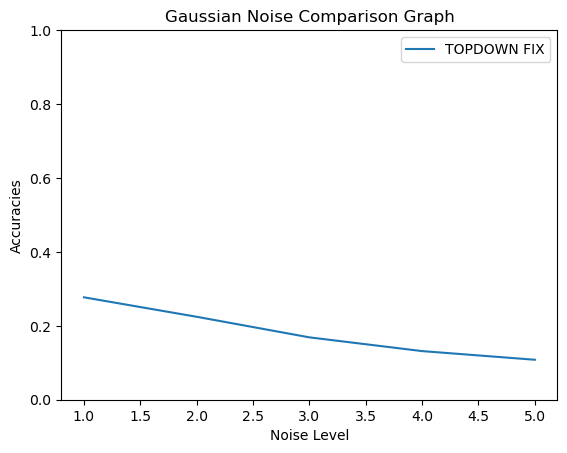

In [822]:
xs = [1,2,3,4,5]
plt.plot(xs, gaussian_fix, label='TOPDOWN FIX')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Gaussian Noise Comparison Graph')
plt.show()

In [741]:
gaussian_td_3l = []
gaussian_mlp_3l = []

gaussian_td_2l = []
gaussian_mlp_2l = []

gaussian_mlpsanger = []
gaussian_tdsanger = []

for idx in range(5):
    d = TopDownBaseline_test_accuracy(TOPDOWN3LayerBaseline_EMNIST, emnist_test_dataloader_gaussian[idx])
    d1 = MLPBaseline_test_accuracy(MLP3Layer_emnist, emnist_test_dataloader_gaussian[idx])
    d2 = TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST, emnist_test_dataloader_gaussian[idx])
    d3 = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_MP, emnist_test_dataloader_gaussian[idx])
    d4 = TopDownBaseline_test_accuracy(TOPDOWNBaseline_EMNIST_SANGER, emnist_test_dataloader_gaussian[idx])
    d5 = MLPBaseline_test_accuracy(MLPBaseline_EMNIST_sanger, emnist_test_dataloader_gaussian[idx])

    gaussian_td_3l.append(d[0])
    gaussian_mlp_3l.append(d1[0])
    gaussian_td_2l.append(d2[0])
    gaussian_mlp_2l.append(d3[0])

    gaussian_mlpsanger.append(d5[0])
    gaussian_tdsanger.append(d4[0])
    

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

  0%|          | 0/18800 [00:00<?, ?it/s]

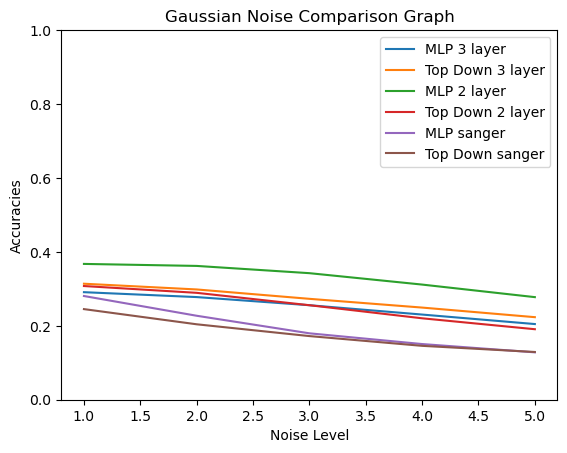

In [742]:
xs = [1,2,3,4,5]
plt.plot(xs, gaussian_mlp_3l, label='MLP 3 layer')
plt.plot(xs, gaussian_td_3l, label='Top Down 3 layer')
plt.plot(xs, gaussian_mlp_2l, label='MLP 2 layer')
plt.plot(xs, gaussian_td_2l, label='Top Down 2 layer')
plt.plot(xs, gaussian_mlpsanger, label='MLP sanger')
plt.plot(xs, gaussian_tdsanger, label='Top Down sanger')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Gaussian Noise Comparison Graph')
plt.show()

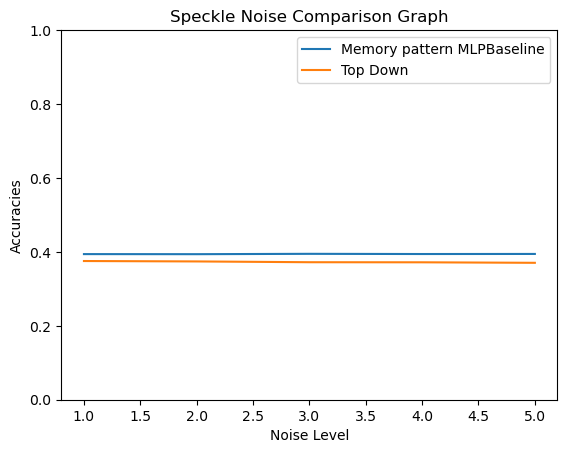

In [706]:
plt.plot(xs, speckle_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, speckle_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Speckle Noise Comparison Graph')
plt.show()

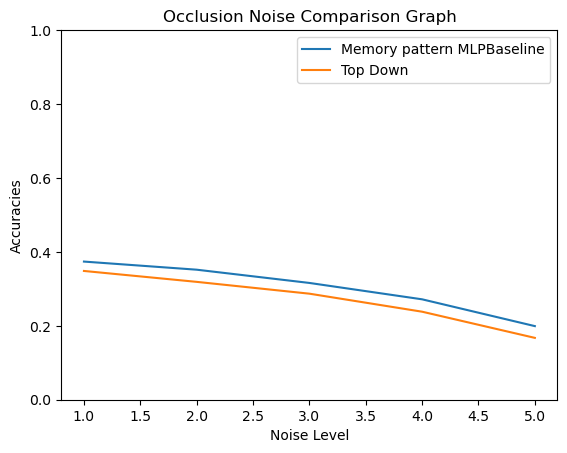

In [707]:
plt.plot(xs, occlusion_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, occlusion_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Occlusion Noise Comparison Graph')
plt.show()

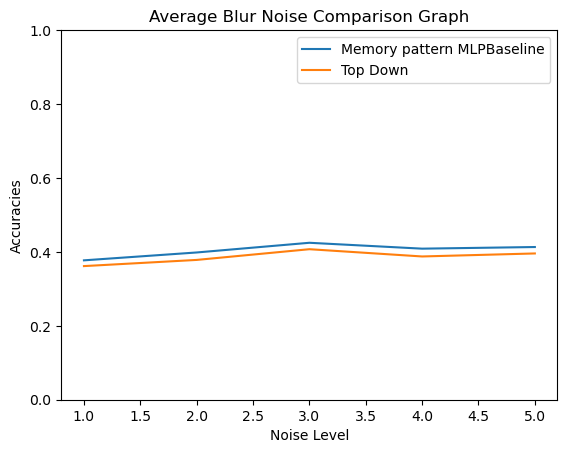

In [708]:
plt.plot(xs, averageblur_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, averageblur_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Average Blur Noise Comparison Graph')
plt.show()

# Fashion MNIST

## Noise Visualization

### Gaussian

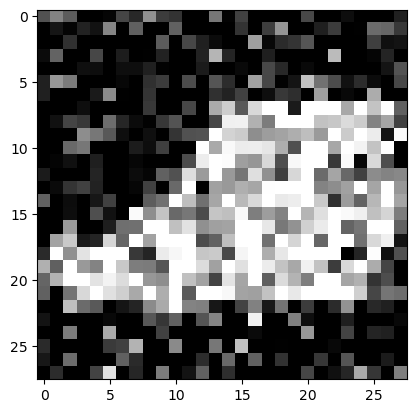

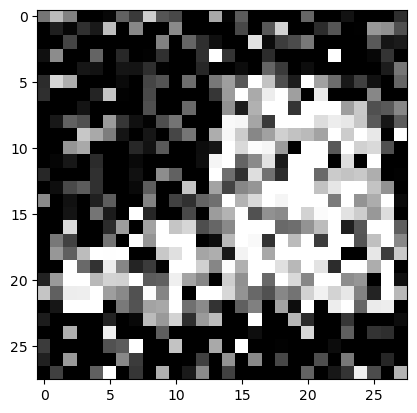

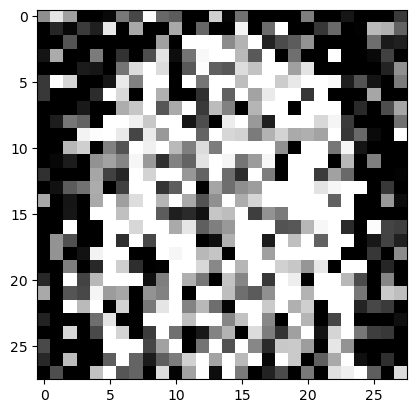

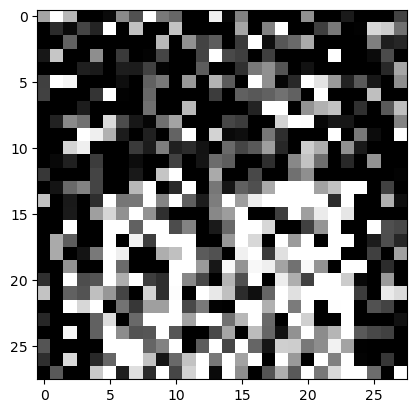

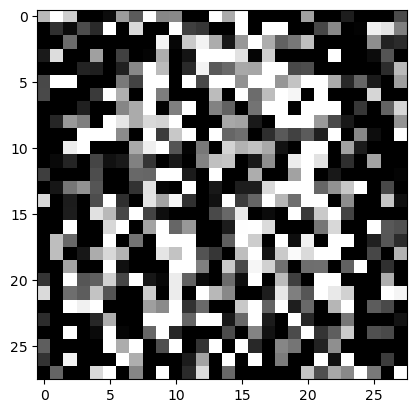

In [624]:
for idx in range(5):
    for data in fashionmnist_test_dataloader_gaussian[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

### Speckle

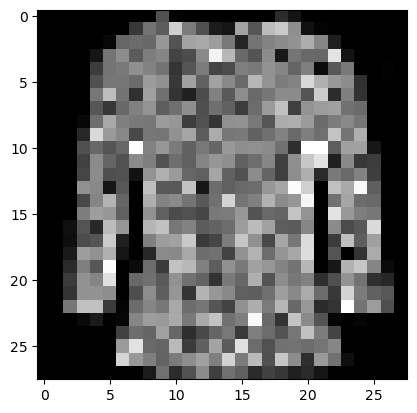

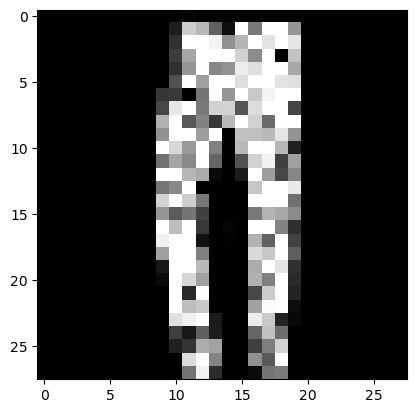

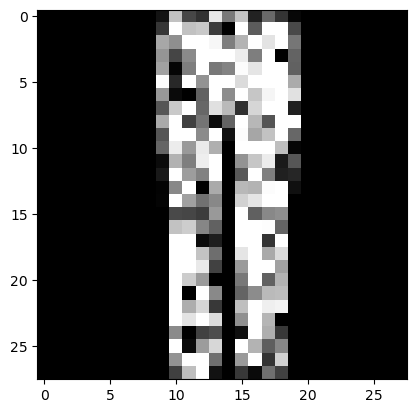

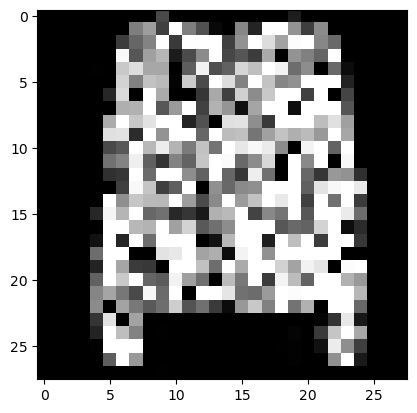

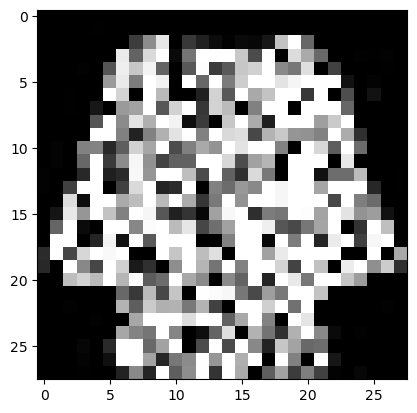

In [628]:
for idx in range(5):
    for data in fashionmnist_test_dataloader_speckle[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

### Occlusion

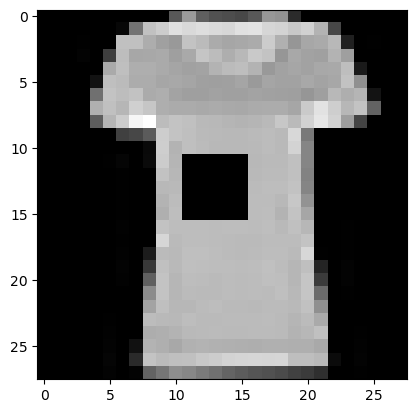

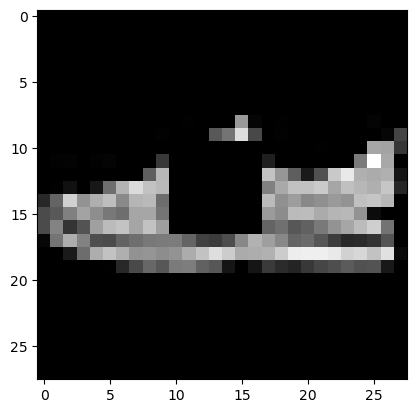

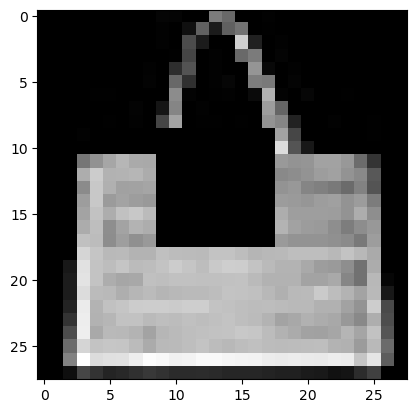

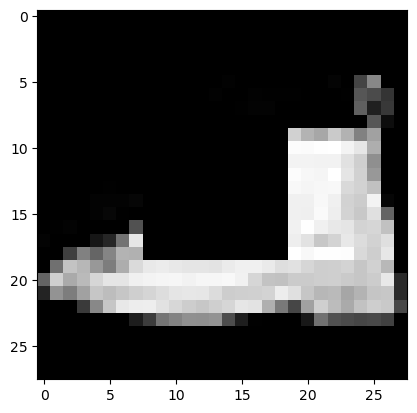

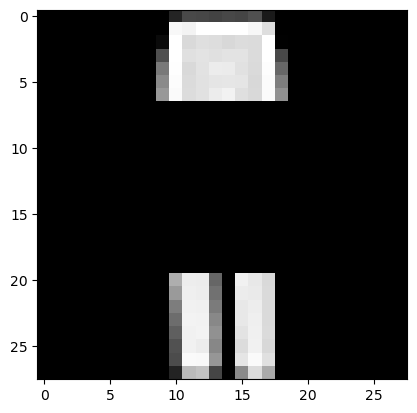

In [626]:
for idx in range(5):
    for data in fashionmnist_test_dataloader_occlusion[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

### Average Blur

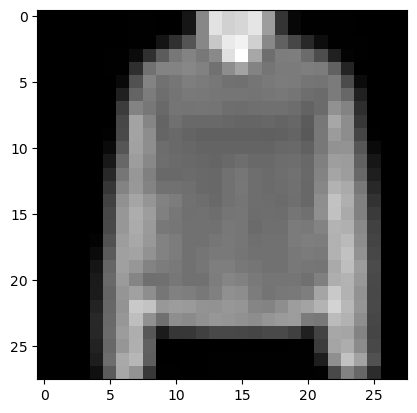

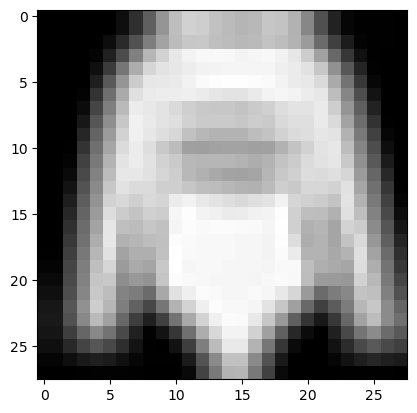

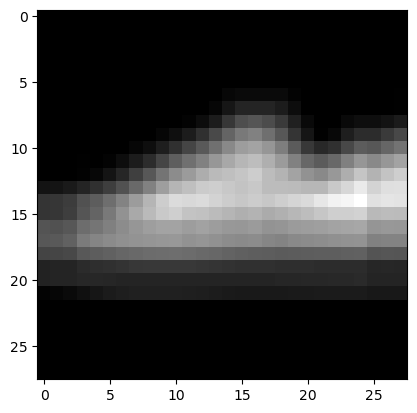

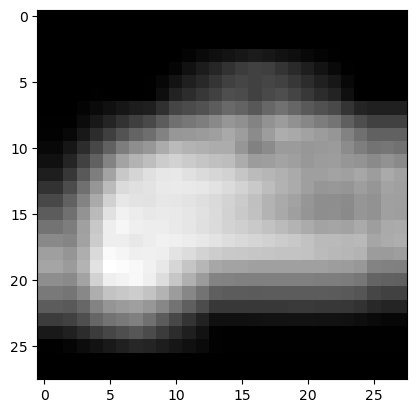

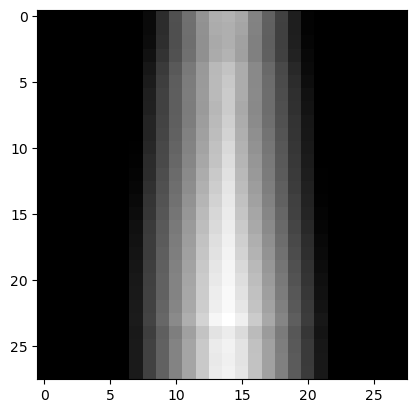

In [627]:
for idx in range(5):
    for data in fashionmnist_test_dataloader_averageblur[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

## MLP

In [678]:
MLPBaseline_fashionmnist = MLPBaseline_Experiment(20, 64, 15, 0.005, Learning.FullyOrthogonal, 0.01, fashionmnist_train_loader, 10)

  0%|          | 0/60000 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

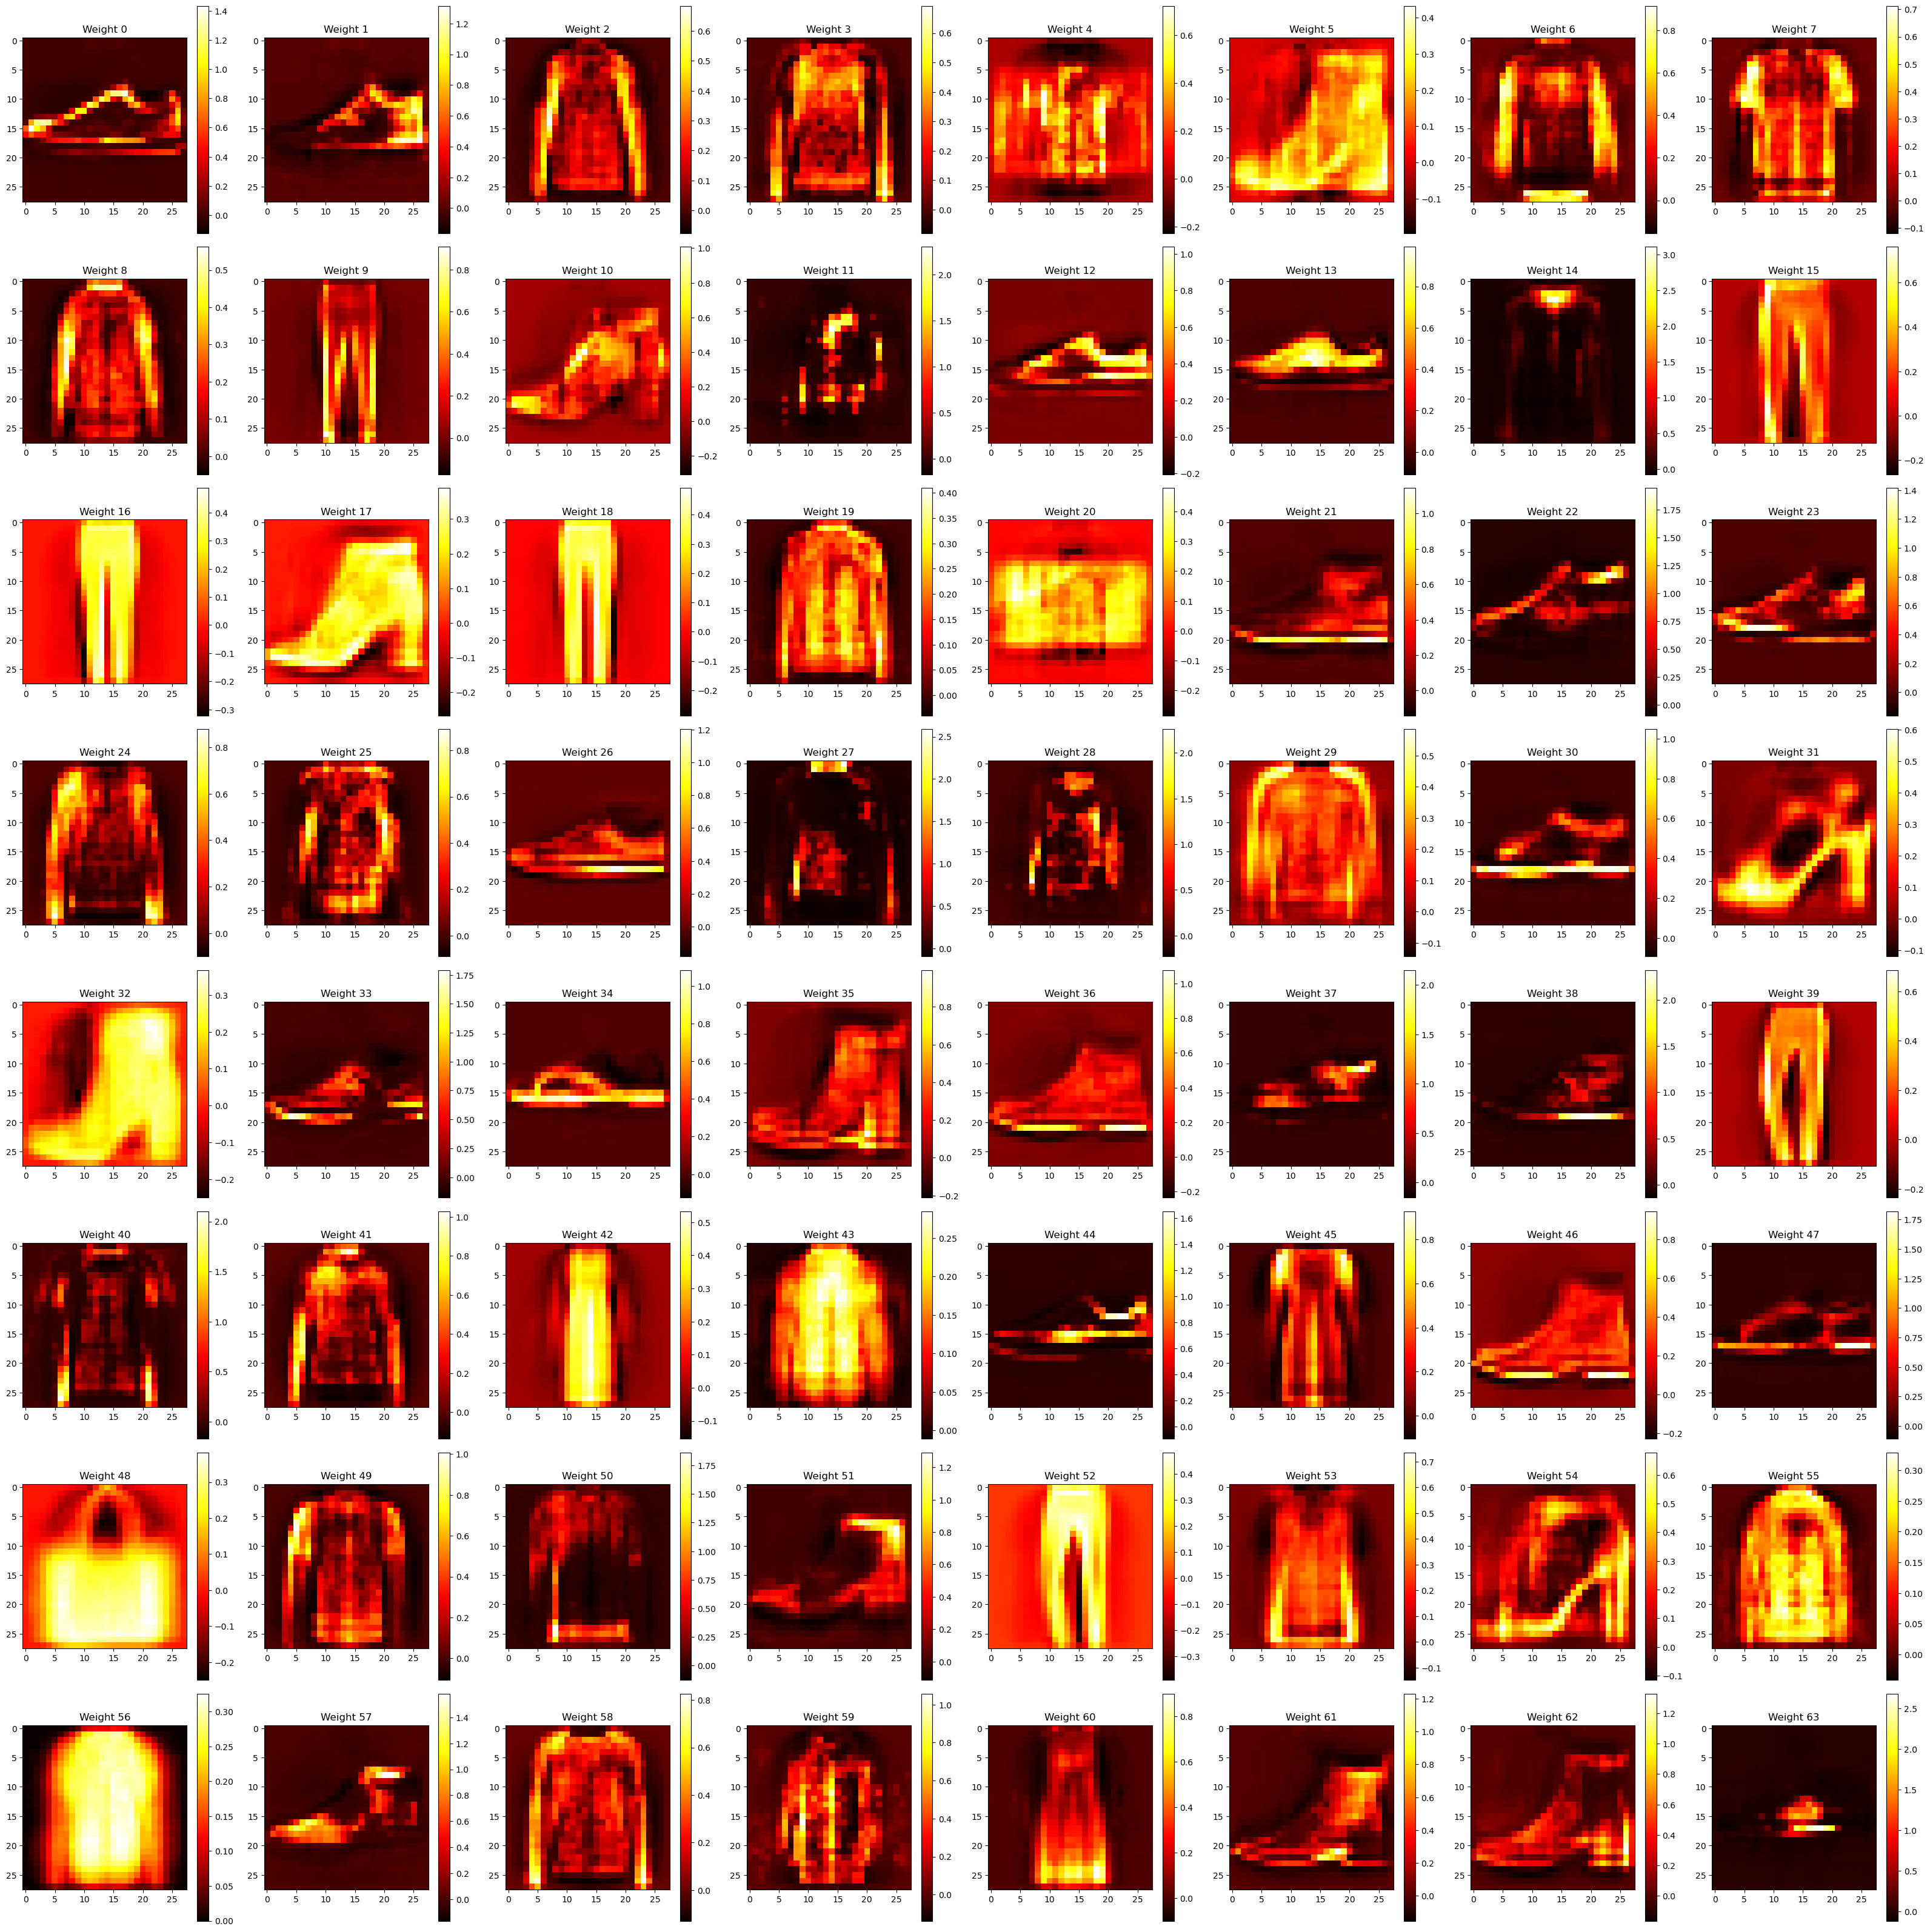

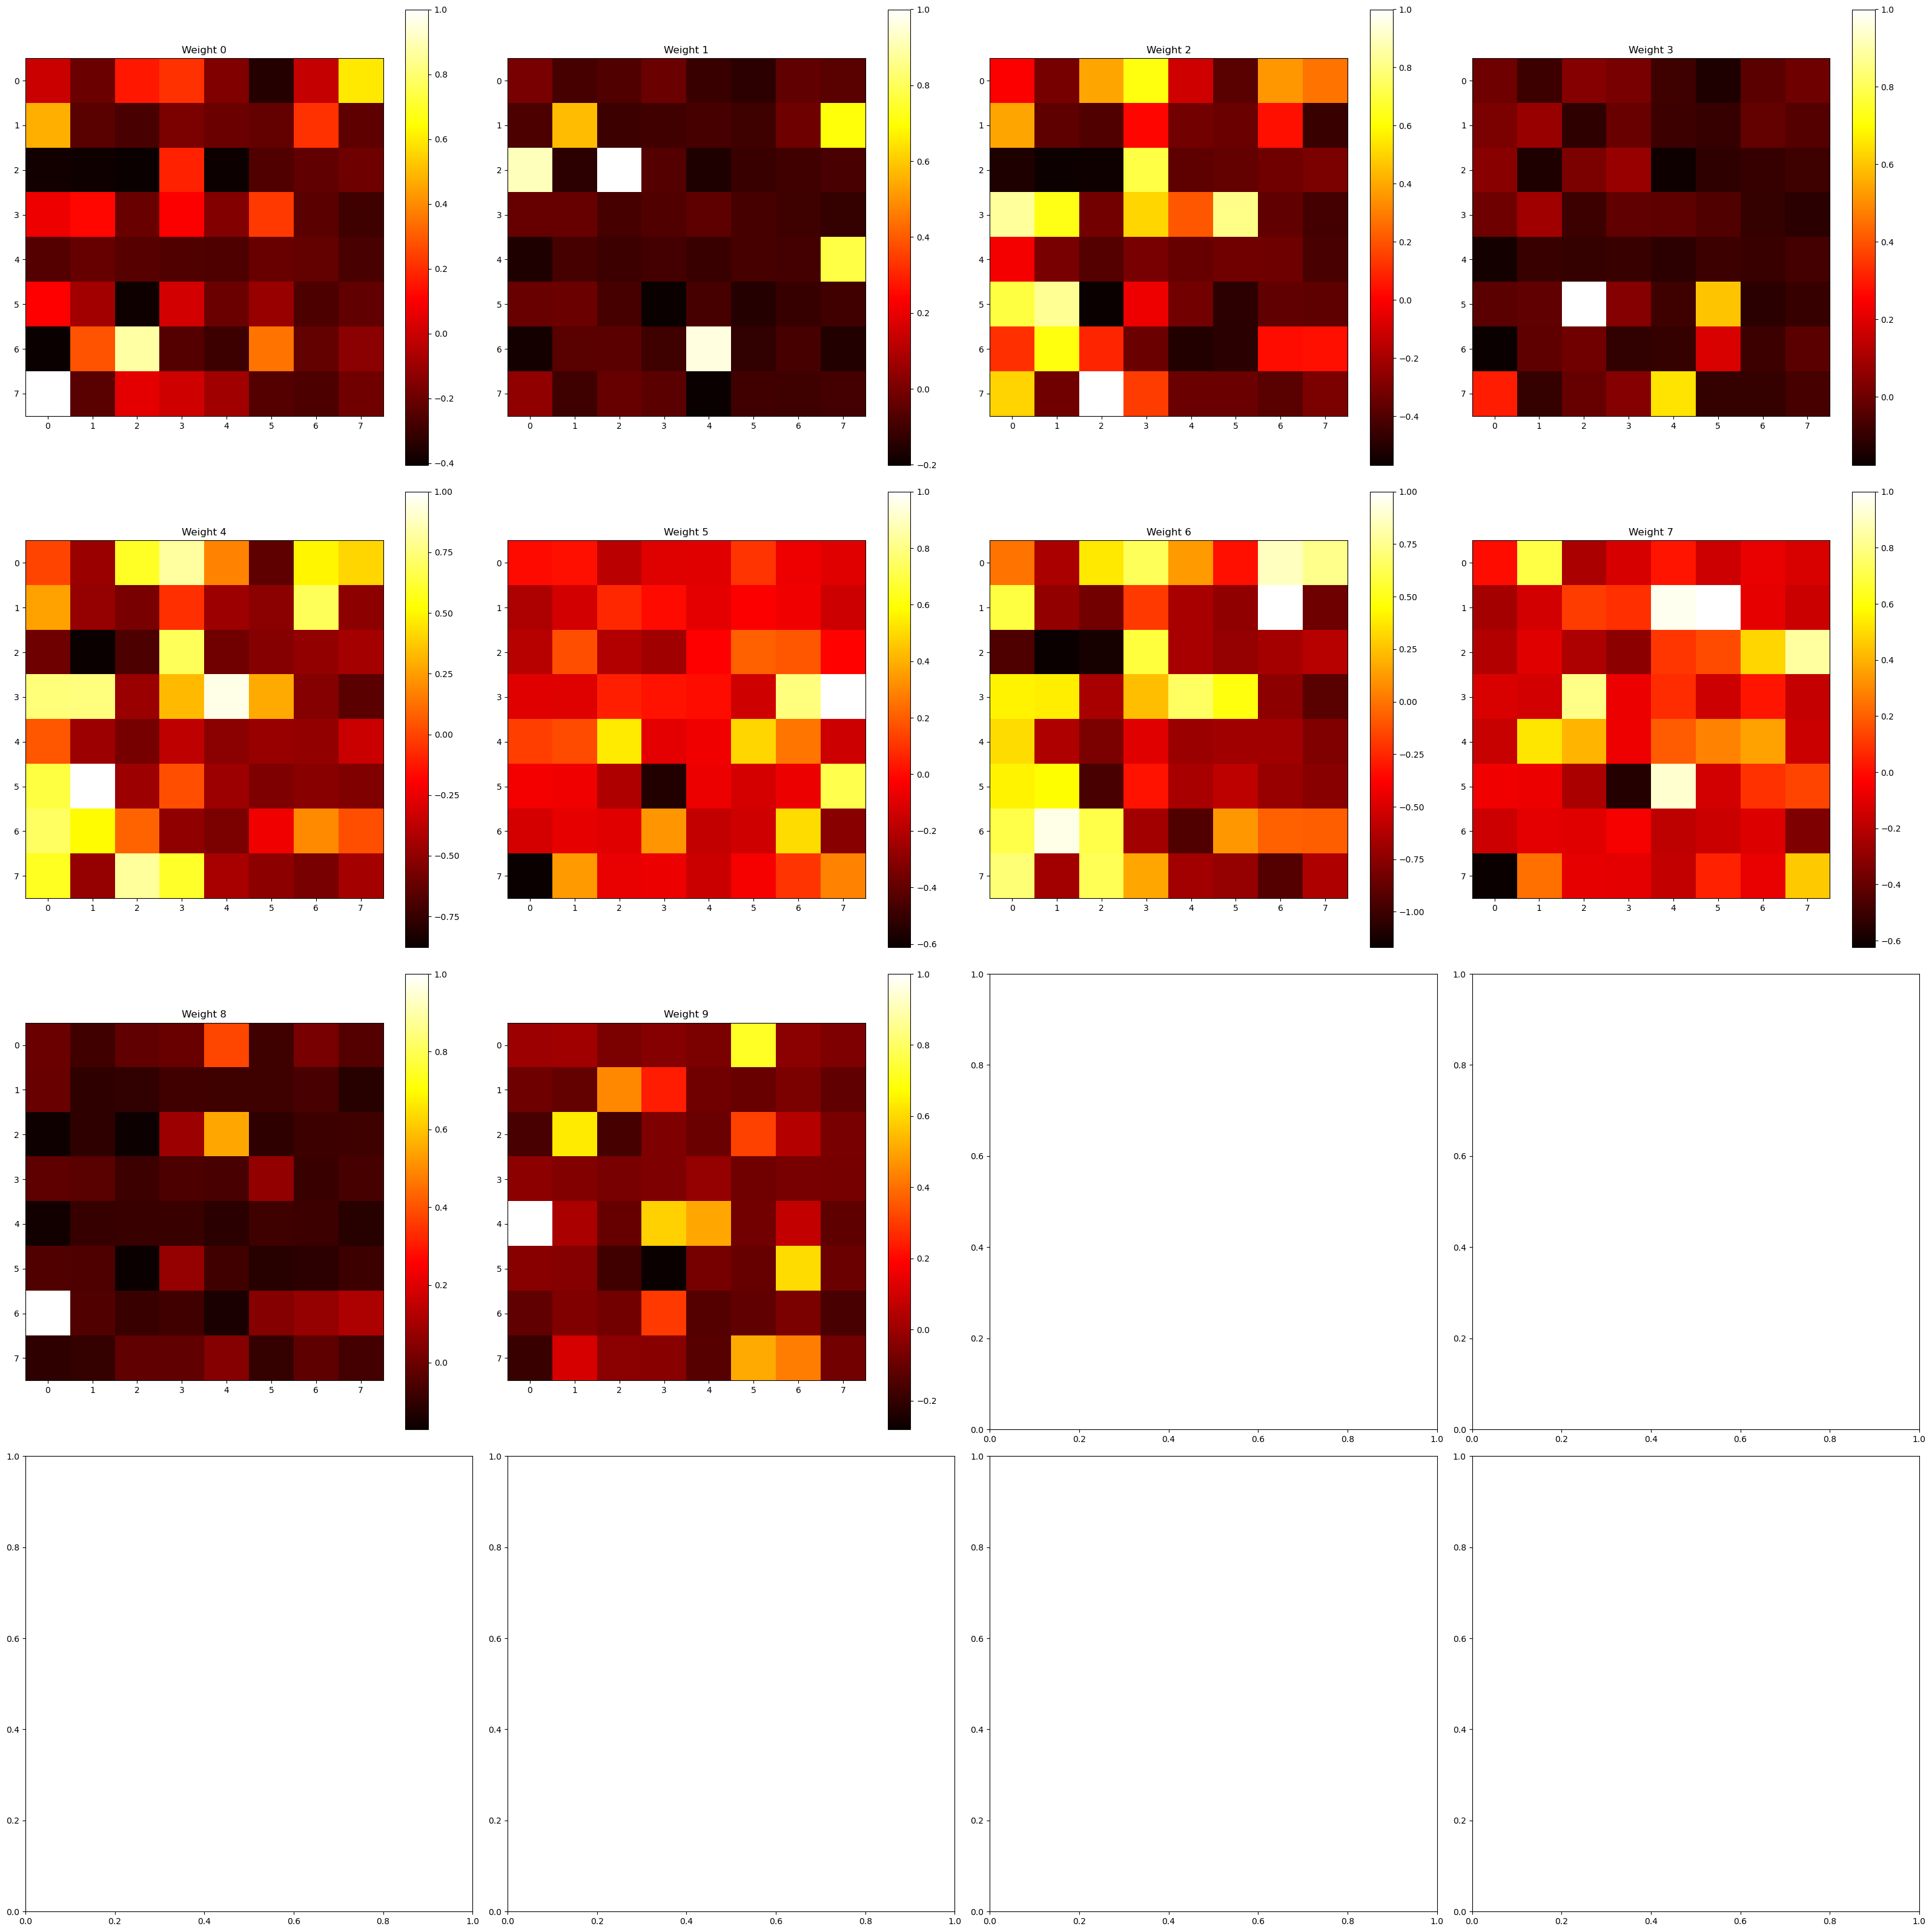

In [680]:
MLPBaseline_fashionmnist.visualize_weights()

In [679]:
print(MLPBaseline_test_accuracy(MLPBaseline_fashionmnist, fashionmnist_test_loader))

  0%|          | 0/10000 [00:00<?, ?it/s]

(0.5275, {9: (772, 1000), 4: (34, 1000), 3: (529, 1000), 8: (586, 1000), 7: (865, 1000), 2: (34, 1000), 1: (801, 1000), 5: (610, 1000), 0: (944, 1000), 6: (100, 1000)})


## Top Down

In [455]:
fashionmnist_td = TopDownBaseline_Experiment(epoch=20, hsize=64, lamb=15, lr=0.005, learning=Learning.FullyOrthogonal, e=0.01, dataloader=fashionmnist_train_loader, nclasses=10)

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

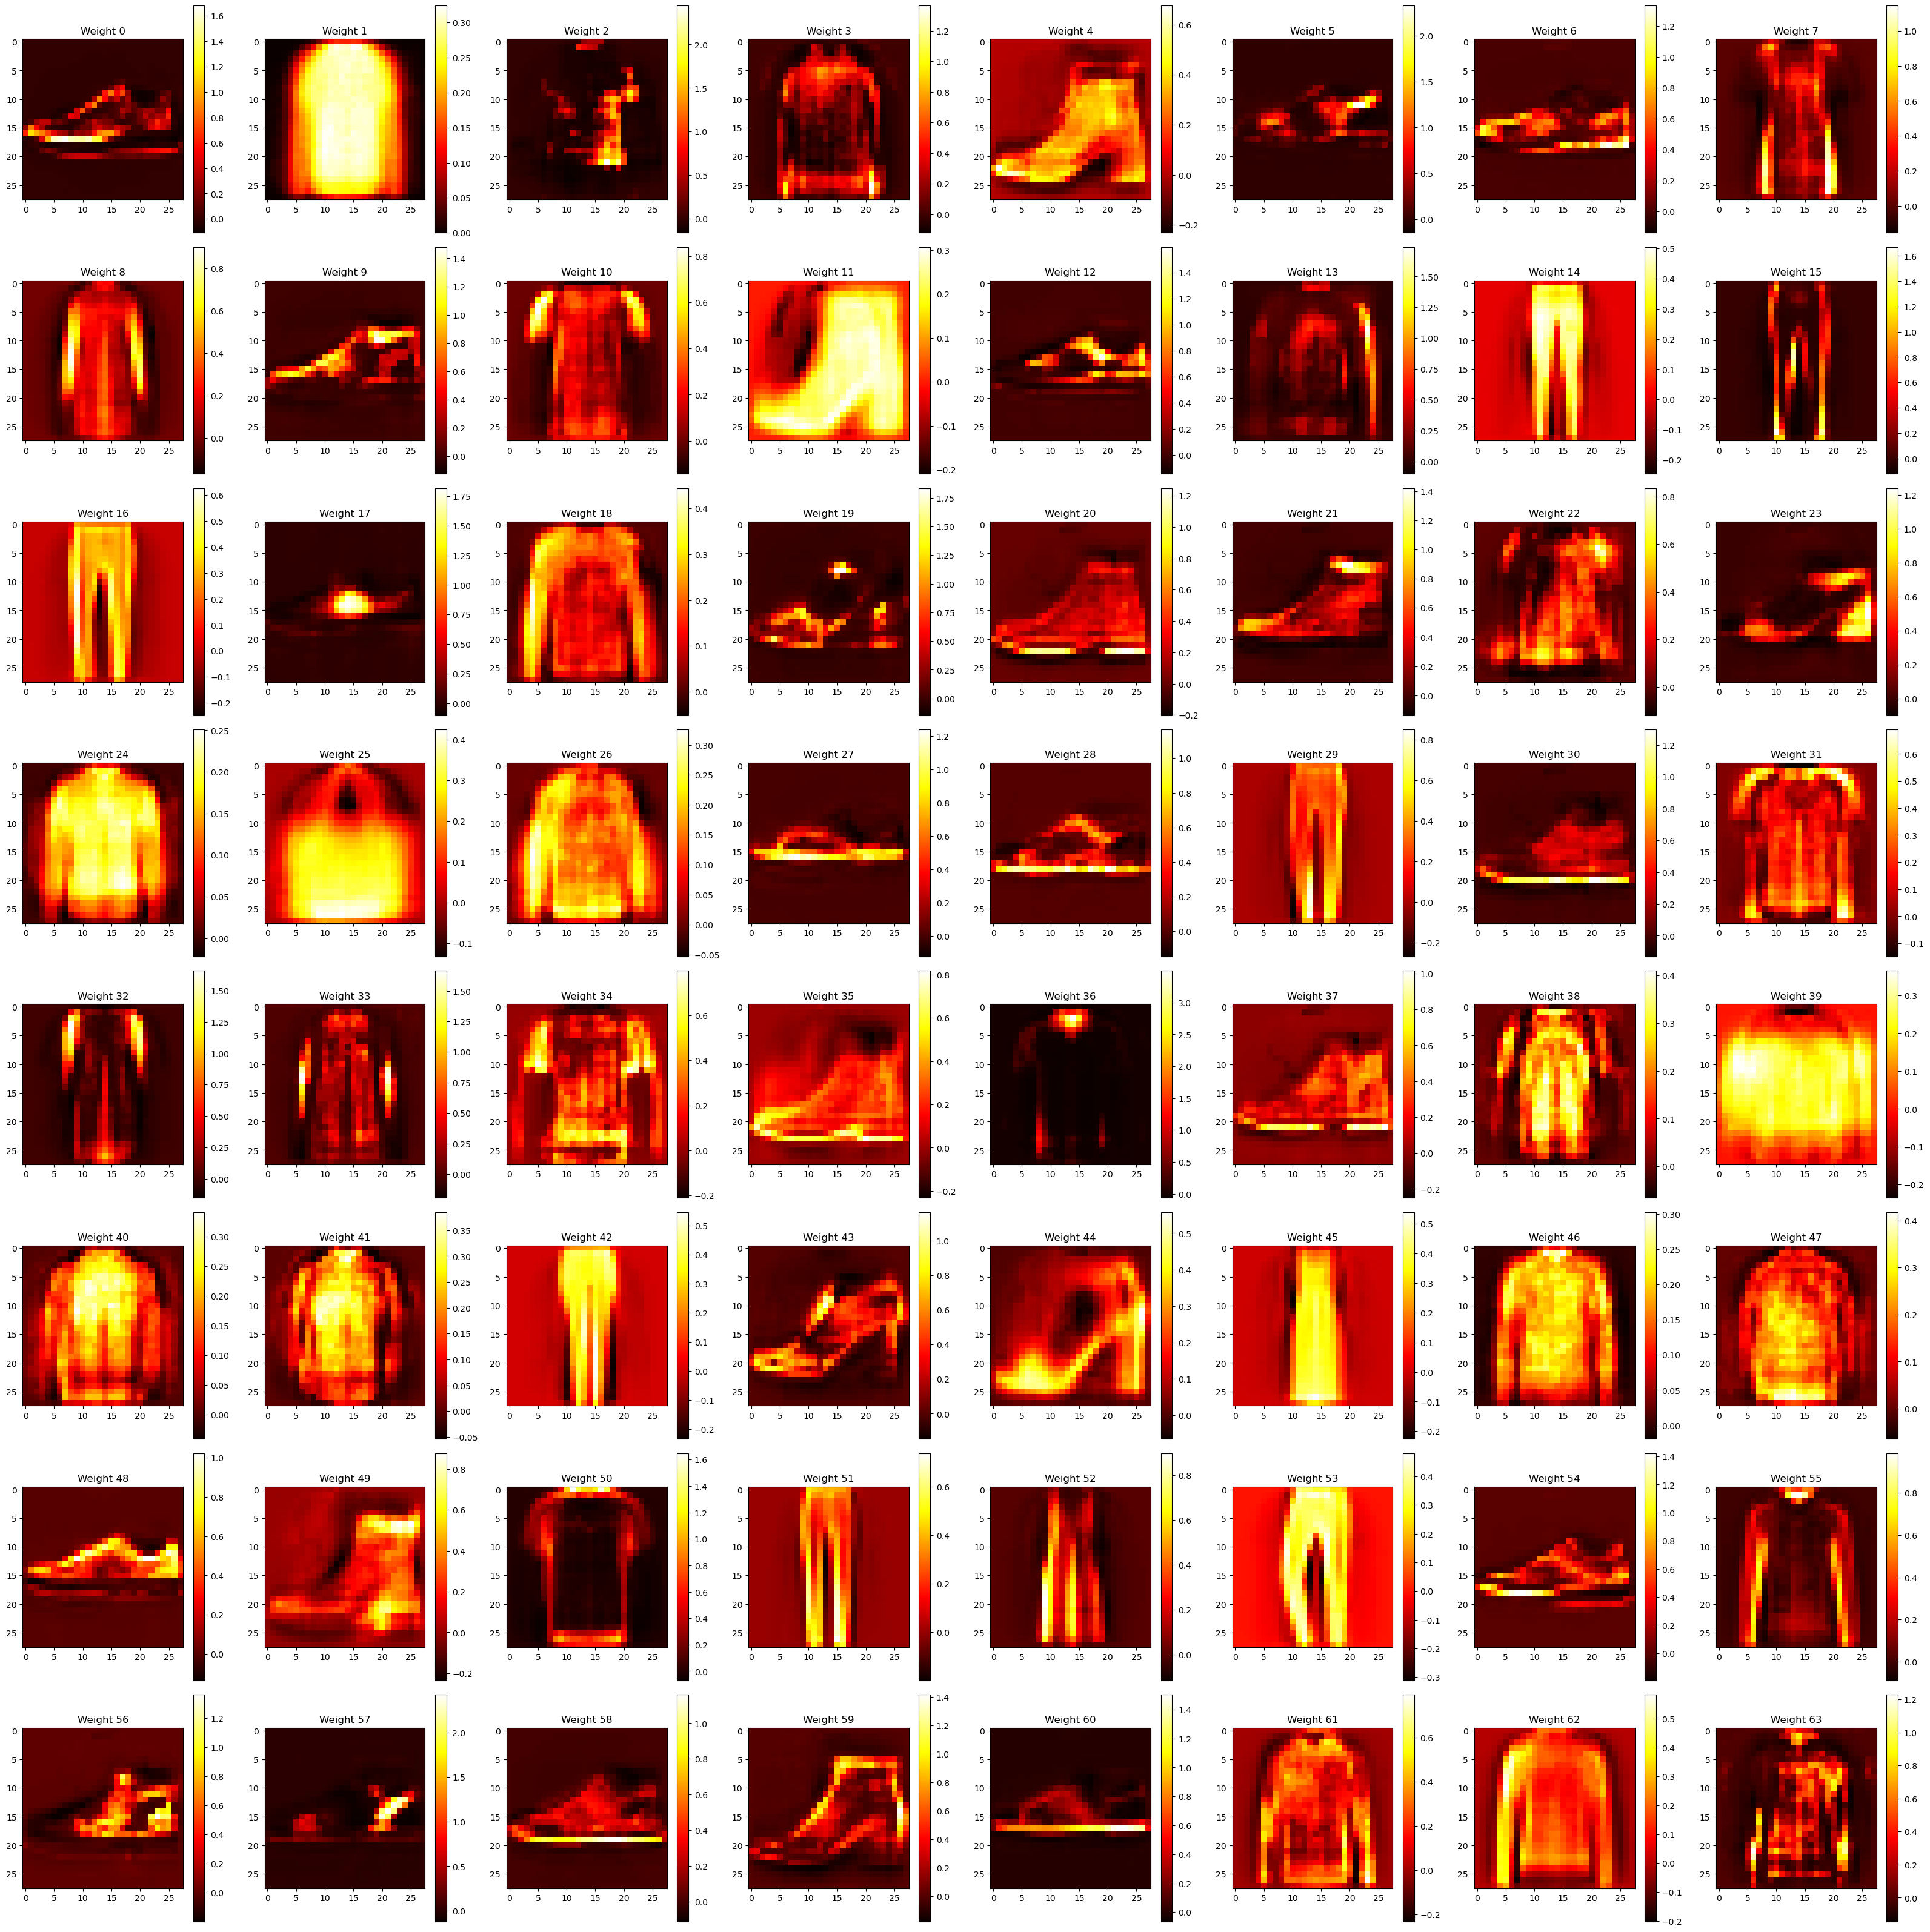

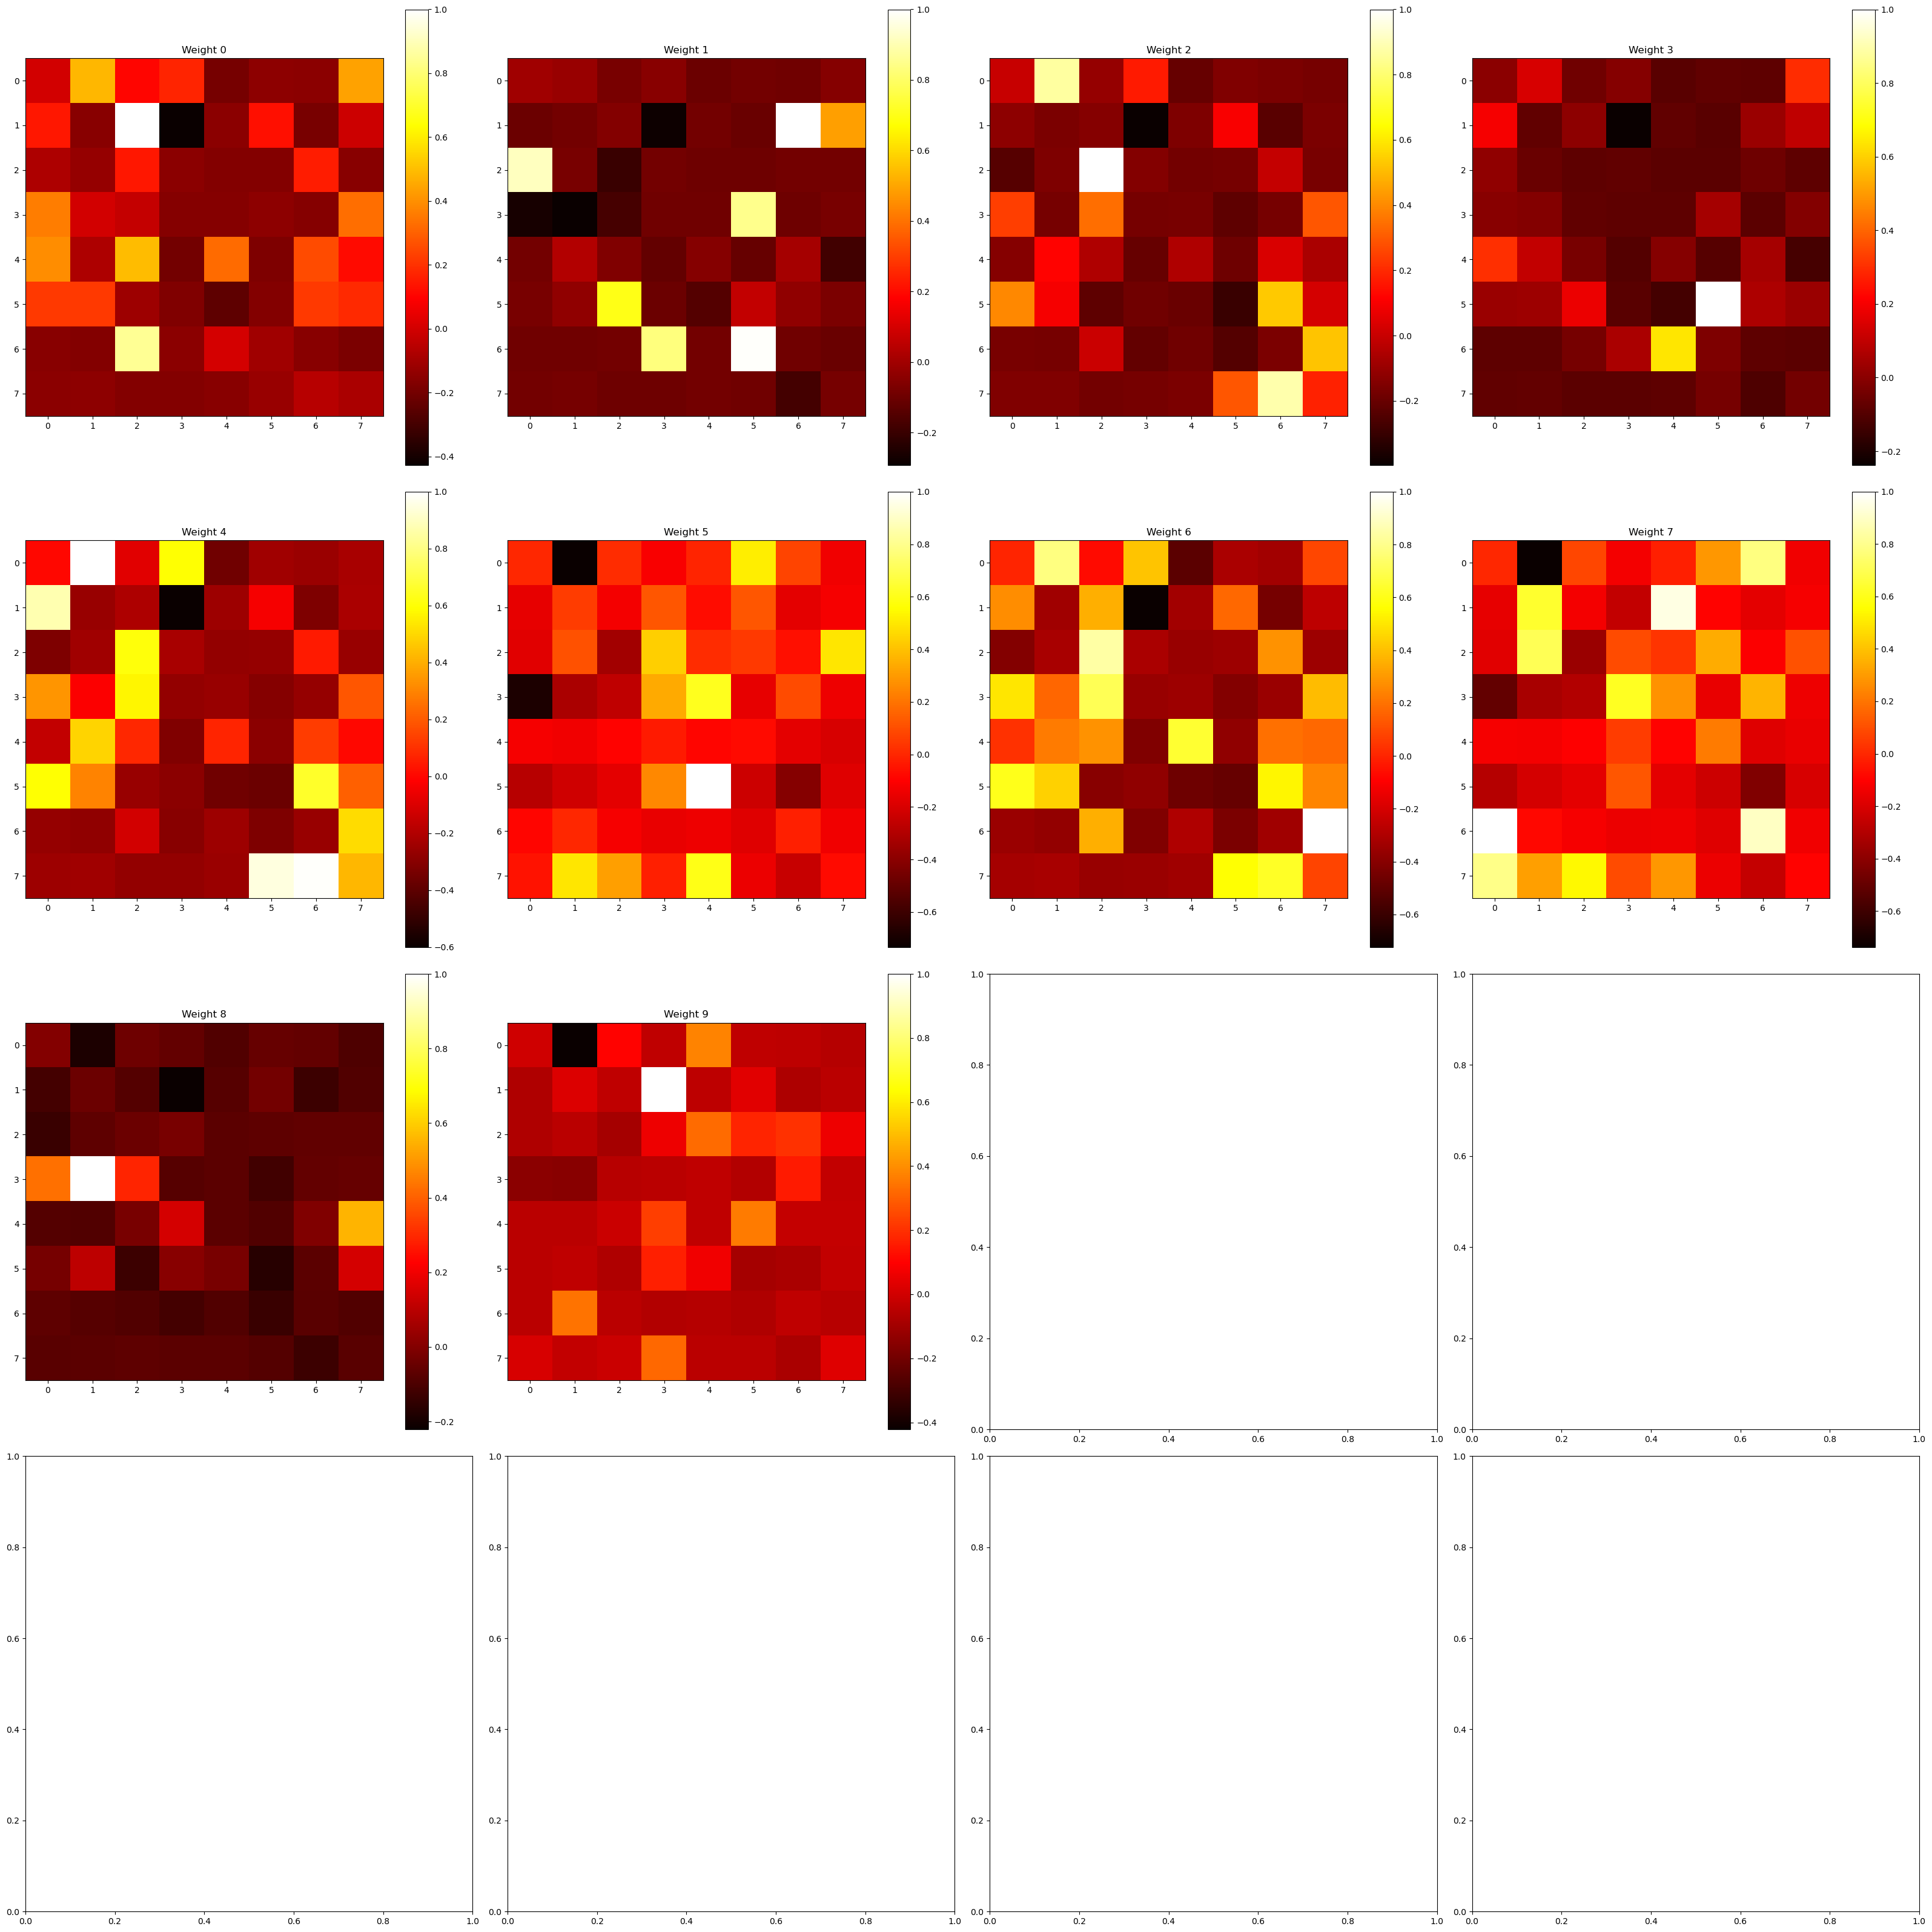

In [456]:
fashionmnist_td.visualize_weights()

In [457]:
print(TopDownBaseline_test_accuracy(fashionmnist_td, fashionmnist_test_loader))

  0%|          | 0/10000 [00:00<?, ?it/s]

(0.5056, {9: (807, 1000), 0: (4, 1000), 2: (0, 1000), 8: (757, 1000), 5: (653, 1000), 6: (58, 1000), 3: (158, 1000), 4: (972, 1000), 7: (898, 1000), 1: (749, 1000)})


## Noise

### Gaussian

In [681]:
fm_gaussian_mlp_mp = []
fm_gaussian_td = []
for idx in range(5):
    d1 = MLPBaseline_test_accuracy(MLPBaseline_fashionmnist, fashionmnist_test_dataloader_gaussian[idx])
    d2 = TopDownBaseline_test_accuracy(fashionmnist_td, fashionmnist_test_dataloader_gaussian[idx])
    fm_gaussian_mlp_mp.append(d1[0])
    fm_gaussian_td.append(d2[0])
    

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

### Speckle

In [682]:
fm_speckle_mlp_mp = []
fm_speckle_td = []
for idx in range(5):
    d1 = MLPBaseline_test_accuracy(MLPBaseline_fashionmnist, fashionmnist_test_dataloader_speckle[idx])
    d2 = TopDownBaseline_test_accuracy(fashionmnist_td, fashionmnist_test_dataloader_speckle[idx])
    fm_speckle_mlp_mp.append(d1[0])
    fm_speckle_td.append(d2[0])

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

### Occlusion

In [683]:
fm_occlusion_mlp_mp = []
fm_occlusion_td = []
for idx in range(5):
    d1 = MLPBaseline_test_accuracy(MLPBaseline_fashionmnist, fashionmnist_test_dataloader_occlusion[idx])
    d2 = TopDownBaseline_test_accuracy(fashionmnist_td, fashionmnist_test_dataloader_occlusion[idx])
    fm_occlusion_mlp_mp.append(d1[0])
    fm_occlusion_td.append(d2[0])

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

### Average Blur

In [684]:
fm_averageblur_mlp_mp = []
fm_averageblur_td = []
for idx in range(5):
    d1 = MLPBaseline_test_accuracy(MLPBaseline_fashionmnist, fashionmnist_test_dataloader_averageblur[idx])
    d2 = TopDownBaseline_test_accuracy(fashionmnist_td, fashionmnist_test_dataloader_averageblur[idx])
    fm_averageblur_mlp_mp.append(d1[0])
    fm_averageblur_td.append(d2[0])

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## Noise Graphs

### Gaussian

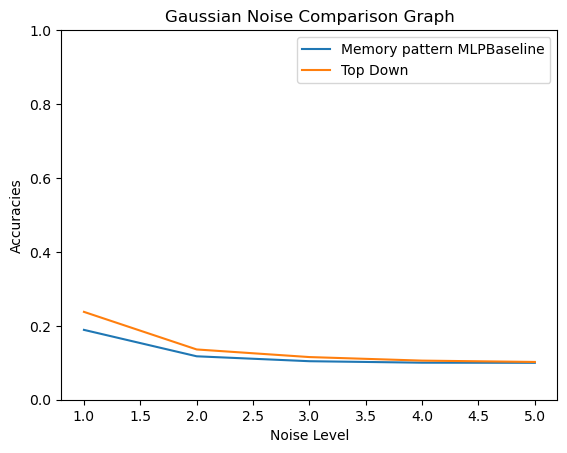

In [685]:
xs = [1,2,3,4,5]
plt.plot(xs, fm_gaussian_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, fm_gaussian_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Gaussian Noise Comparison Graph')
plt.show()

### Speckle

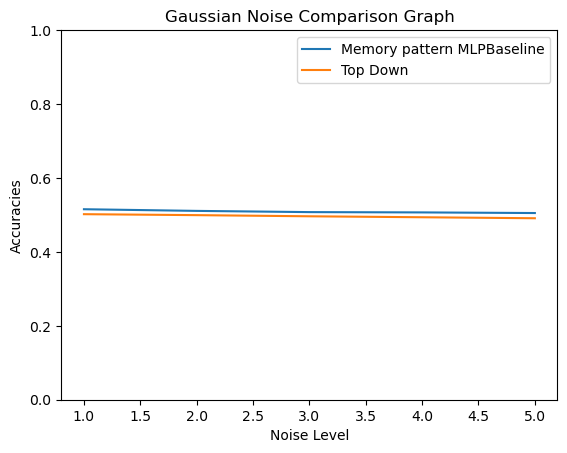

In [686]:
xs = [1,2,3,4,5]
plt.plot(xs, fm_speckle_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, fm_speckle_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Gaussian Noise Comparison Graph')
plt.show()

### Occlusion

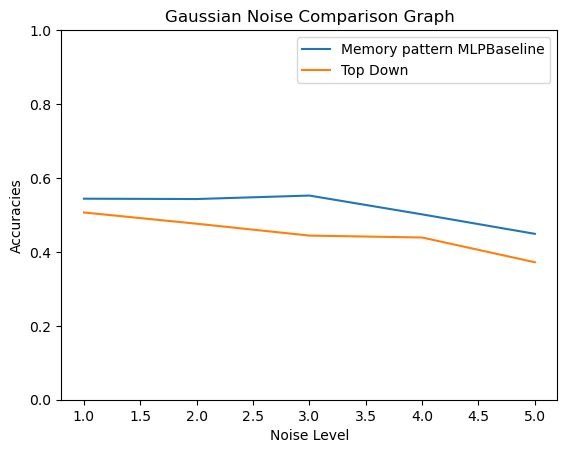

In [687]:
xs = [1,2,3,4,5]
plt.plot(xs, fm_occlusion_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, fm_occlusion_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Gaussian Noise Comparison Graph')
plt.show()

### Average Blur

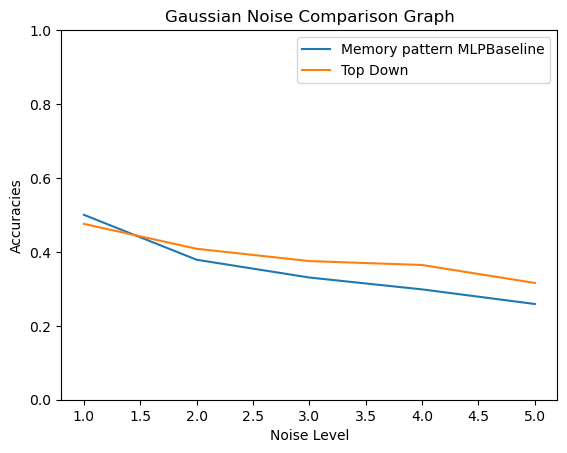

In [688]:
xs = [1,2,3,4,5]
plt.plot(xs, fm_averageblur_mlp_mp, label='Memory pattern MLPBaseline')
plt.plot(xs, fm_averageblur_td, label='Top Down')
plt.legend()
plt.ylim(0,1)
plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.title('Gaussian Noise Comparison Graph')
plt.show()

# CNN model

In [631]:
for data in cifar10_train_loader:
    inputs, label = data
    print(inputs.shape)
    print(inputs)
    print(label)
    iss = inputs.unfold(step=1, size=2, dimension=1)
    print(iss.shape)
    print(iss)
    break

torch.Size([1, 3, 32, 32])
tensor([[[[-0.6941, -0.6941, -0.6627,  ..., -0.8824, -0.7490, -0.3490],
          [-0.6000, -0.5922, -0.5529,  ..., -0.8353, -0.9059, -0.2941],
          [-0.5137, -0.4980, -0.4510,  ..., -0.4824, -0.8510, -0.3647],
          ...,
          [ 0.3490,  0.3490,  0.3725,  ..., -0.2392, -0.2941, -0.3961],
          [ 0.3255,  0.3412,  0.3647,  ..., -0.4431, -0.5451, -0.6471],
          [ 0.3176,  0.3412,  0.3569,  ..., -0.6863, -0.7882, -0.8745]],

         [[-0.6392, -0.6392, -0.6000,  ..., -0.8196, -0.6863, -0.2941],
          [-0.5294, -0.5216, -0.4824,  ..., -0.7961, -0.8667, -0.2549],
          [-0.4196, -0.4039, -0.3569,  ..., -0.6157, -0.8510, -0.3412],
          ...,
          [ 0.3412,  0.3412,  0.3647,  ..., -0.2314, -0.3020, -0.4039],
          [ 0.3176,  0.3333,  0.3569,  ..., -0.4431, -0.5451, -0.6471],
          [ 0.3098,  0.3333,  0.3490,  ..., -0.6863, -0.7725, -0.8588]],

         [[-0.4824, -0.4902, -0.4510,  ..., -0.7412, -0.5843, -0.2157],
   

In [675]:
class ConvolutionHebbianLayer(nn.Module):
    def __init__(self, kernel, stride, in_ch, out_ch):
        super(ConvolutionHebbianLayer, self).__init__()
        self.kernel = kernel
        self.stride = stride
        self.in_channel = in_ch
        self.out_channel = out_ch

        self.convolution = nn.Conv2d(stride=self.stride, kernel_size=self.kernel, in_channels=self.in_channel, out_channels=1, bias=False)
        
        self.convolution.weight = nn.Parameter(torch.ones_like(self.convolution.weight))


    def update_weight_Orthogonal(self, input, output):
        
        
    def inhibition(self, x):
        x=nn.ReLU()(x)
        max_ele=torch.max(x).item()
        x=torch.pow(x, self.lamb)
        x/=abs(max_ele)**self.lamb
        return x
        
    # x is torch.Size([batch_size, channel, height, width])
    def forward(self, x):
        conv_out = self.convolution(x)
        # print(conv_out)
        a_out = self.inhibition(conv_out)
        # print(out)





In [672]:
myconv = ConvolutionHebbianLayer(3, 1, 3, 1)

In [673]:
tensor3 = torch.full([1, 3, 32, 32], 1, dtype=torch.float32)

In [676]:
myconv.forward(tensor3)

tensor([[[[27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27.],
          [27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27.],
          [27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27.],
          [27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27.],
          [27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,
           27., 27.],
          [27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27., 27.,